In [1]:
import torch
import os
import math
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.backends.cudnn as cudnn 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms 
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
from IPython.display import display, Image, clear_output 
import ipywidgets as widgets
import threading

In [3]:
torch.manual_seed(111)

In [4]:
device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [5]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader 
from PIL import Image

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    # transforms.Resize((28, 28)),
    transforms.Resize((64, 64)), 
    #transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])
class SingleClassImageFolder(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_names = [img for img in os.listdir(root_dir) if img.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))] 
        
    def __len__(self):
        return len(self.img_names)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_names[idx])
        image = Image.open(img_path)
        image = image.convert('RGB') 
        if self.transform:
            image = self.transform(image)
        return image, 0 
data_dir = './data/train'
letters = os.listdir(data_dir)

gan_datasets = {}
gan_dataloaders = {}

for letter in letters:
    letter_path = os.path.join(data_dir, letter) 
    if os.path.isdir(letter_path):
        gan_datasets[letter] = SingleClassImageFolder(root_dir=letter_path, transform=transform)
        gan_dataloaders[letter] = DataLoader(gan_datasets[letter],batch_size=32, shuffle=True, num_workers=0)

print(gan_dataloaders['A'])

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0)) 
    mean = np.array([0.485, 0.456, 0.406]) 
    std = np.array([0.229, 0.224, 0.225]) 
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1) 
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

torch.Size([32, 1, 64, 64])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
torch.Size([3, 266, 530])


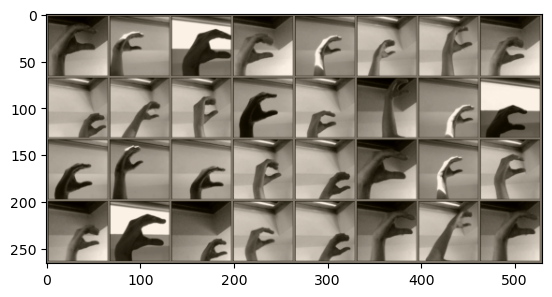

In [7]:
inputs, classes = next(iter(gan_dataloaders['C']))
print(inputs.shape)
print(classes)

out = torchvision.utils.make_grid(inputs)
print(out.shape)
imshow(out)

In [25]:
class Discriminator(nn.Module): 
    def __init__(self, dropout):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(4096, 2048),
            nn.Dropout(0.3),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        x = x.view(x.size(0), 4096)
        output = self.model(x)
        return output

In [26]:
class Generator(nn.Module): 
    def __init__(self, dropout):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 2048),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, 4096),
            nn.Tanh(),
        )
        
    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 64, 64) 
        return output

In [27]:
learning_rates = [0.0001, 0.0005]
batch_sizes = [16, 32]
epochs_list = [50, 100]
dropout_rates = [0.3, 0.5]

parameter_combinations = list(itertools.product(learning_rates, batch_sizes, epochs_list, dropout_rates))

print(len(parameter_combinations))

16


In [32]:
loss_function = nn.BCELoss()

def run_training(lr, batch_size, epochs, dropout):
    
    print("Currently trying combinations:")
    print(f"lr: {lr}, batch_size: {batch_size}, epochs: {epochs}, dropout: {dropout}")
    generator = Generator(dropout=dropout).to(device)
    discriminator = Discriminator(dropout=dropout).to(device)

    optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)
    optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
    
    total_discriminator_losses = []
    total_generator_losses = []

    for epoch in range(epochs):
        start_time_epoch = time.time()
        for n, (real_samples, _) in enumerate(gan_dataloaders['C']):
                start_time_batch = time.time()

                batch_size_current = real_samples.size(0)
                real_samples = real_samples.to(device=device)
                real_samples_labels = torch.ones((batch_size_current, 1), device=device)

                latent_space_samples = torch.randn((batch_size_current, 100), device=device)
                generated_samples = generator(latent_space_samples)
                generated_samples_labels = torch.zeros((batch_size_current, 1), device=device)

                all_samples = torch.cat((real_samples, generated_samples), dim=0)
                all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels), dim=0)

                discriminator.zero_grad()

                output_discriminator = discriminator(all_samples)
                loss_discriminator = loss_function(output_discriminator, all_samples_labels)
                loss_discriminator.backward()
                optimizer_discriminator.step()
                total_discriminator_losses.append(loss_discriminator.item())


                generator.zero_grad()
                latent_space_samples = torch.randn((batch_size_current, 100), device=device)
                generated_samples = generator(latent_space_samples)
                output_discriminator_generated = discriminator(generated_samples)
                loss_generator = loss_function(output_discriminator_generated, real_samples_labels) 
                loss_generator.backward()
                optimizer_generator.step()
                total_generator_losses.append(loss_generator.item())

                end_time_batch = time.time()
                batch_duration = end_time_batch - start_time_batch


        end_time_epoch = time.time()
        epoch_duration = end_time_epoch - start_time_epoch 
        print(f"Completed Epoch {epoch+1}/{epochs}, "
            f"Epoch Duration: {epoch_duration:.2f}s, "
            f"Total Loss D.: {loss_discriminator.item():.4f}, " 
            f"Total Loss G.: {loss_generator.item():.4f}")
        
    overall_avg_disc_loss = np.mean(total_discriminator_losses)
    overall_avg_gen_loss = np.mean(total_generator_losses)
    
    print(f"Overall Average Loss - Discriminator: {overall_avg_disc_loss:.4f}, Generator: {overall_avg_gen_loss:.4f}")
    
    latent_space_samples = torch.randn(batch_size, 100).to(device=device)
    generated_samples = generator(latent_space_samples)
    
    generated_samples = generated_samples.cpu().detach()
    
    plt.imshow(generated_samples[0].reshape(64, 64), cmap="gray_r")
    
    num_images = 16
    num_rows = 4
    num_cols = 4

    plt.figure(figsize=(64, 64))

    for i in range(num_images):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(generated_samples[i].reshape(64,64), cmap='gray')
        plt.axis('off') 

    plt.tight_layout()
    plt.show()

Currently trying combinations:
lr: 0.0001, batch_size: 16, epochs: 50, dropout: 0.3
Completed Epoch 1/50, Epoch Duration: 6.45s, Total Loss D.: 0.1123, Total Loss G.: 1.8097
Completed Epoch 2/50, Epoch Duration: 6.64s, Total Loss D.: 0.0280, Total Loss G.: 3.0302
Completed Epoch 3/50, Epoch Duration: 6.77s, Total Loss D.: 0.2449, Total Loss G.: 1.0570
Completed Epoch 4/50, Epoch Duration: 6.68s, Total Loss D.: 0.0213, Total Loss G.: 5.5175
Completed Epoch 5/50, Epoch Duration: 6.82s, Total Loss D.: 0.0478, Total Loss G.: 3.9312
Completed Epoch 6/50, Epoch Duration: 6.89s, Total Loss D.: 0.0056, Total Loss G.: 6.2609
Completed Epoch 7/50, Epoch Duration: 6.67s, Total Loss D.: 0.1996, Total Loss G.: 5.5549
Completed Epoch 8/50, Epoch Duration: 6.51s, Total Loss D.: 0.1850, Total Loss G.: 3.5057
Completed Epoch 9/50, Epoch Duration: 6.74s, Total Loss D.: 0.0634, Total Loss G.: 5.3221
Completed Epoch 10/50, Epoch Duration: 6.45s, Total Loss D.: 0.4528, Total Loss G.: 0.8560
Completed Epoch

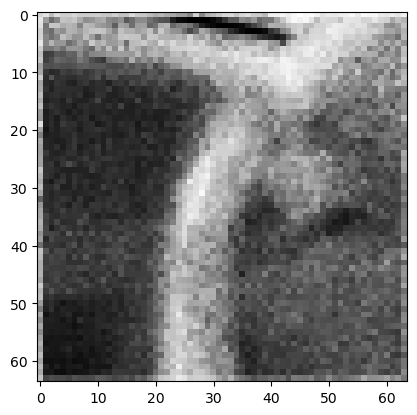

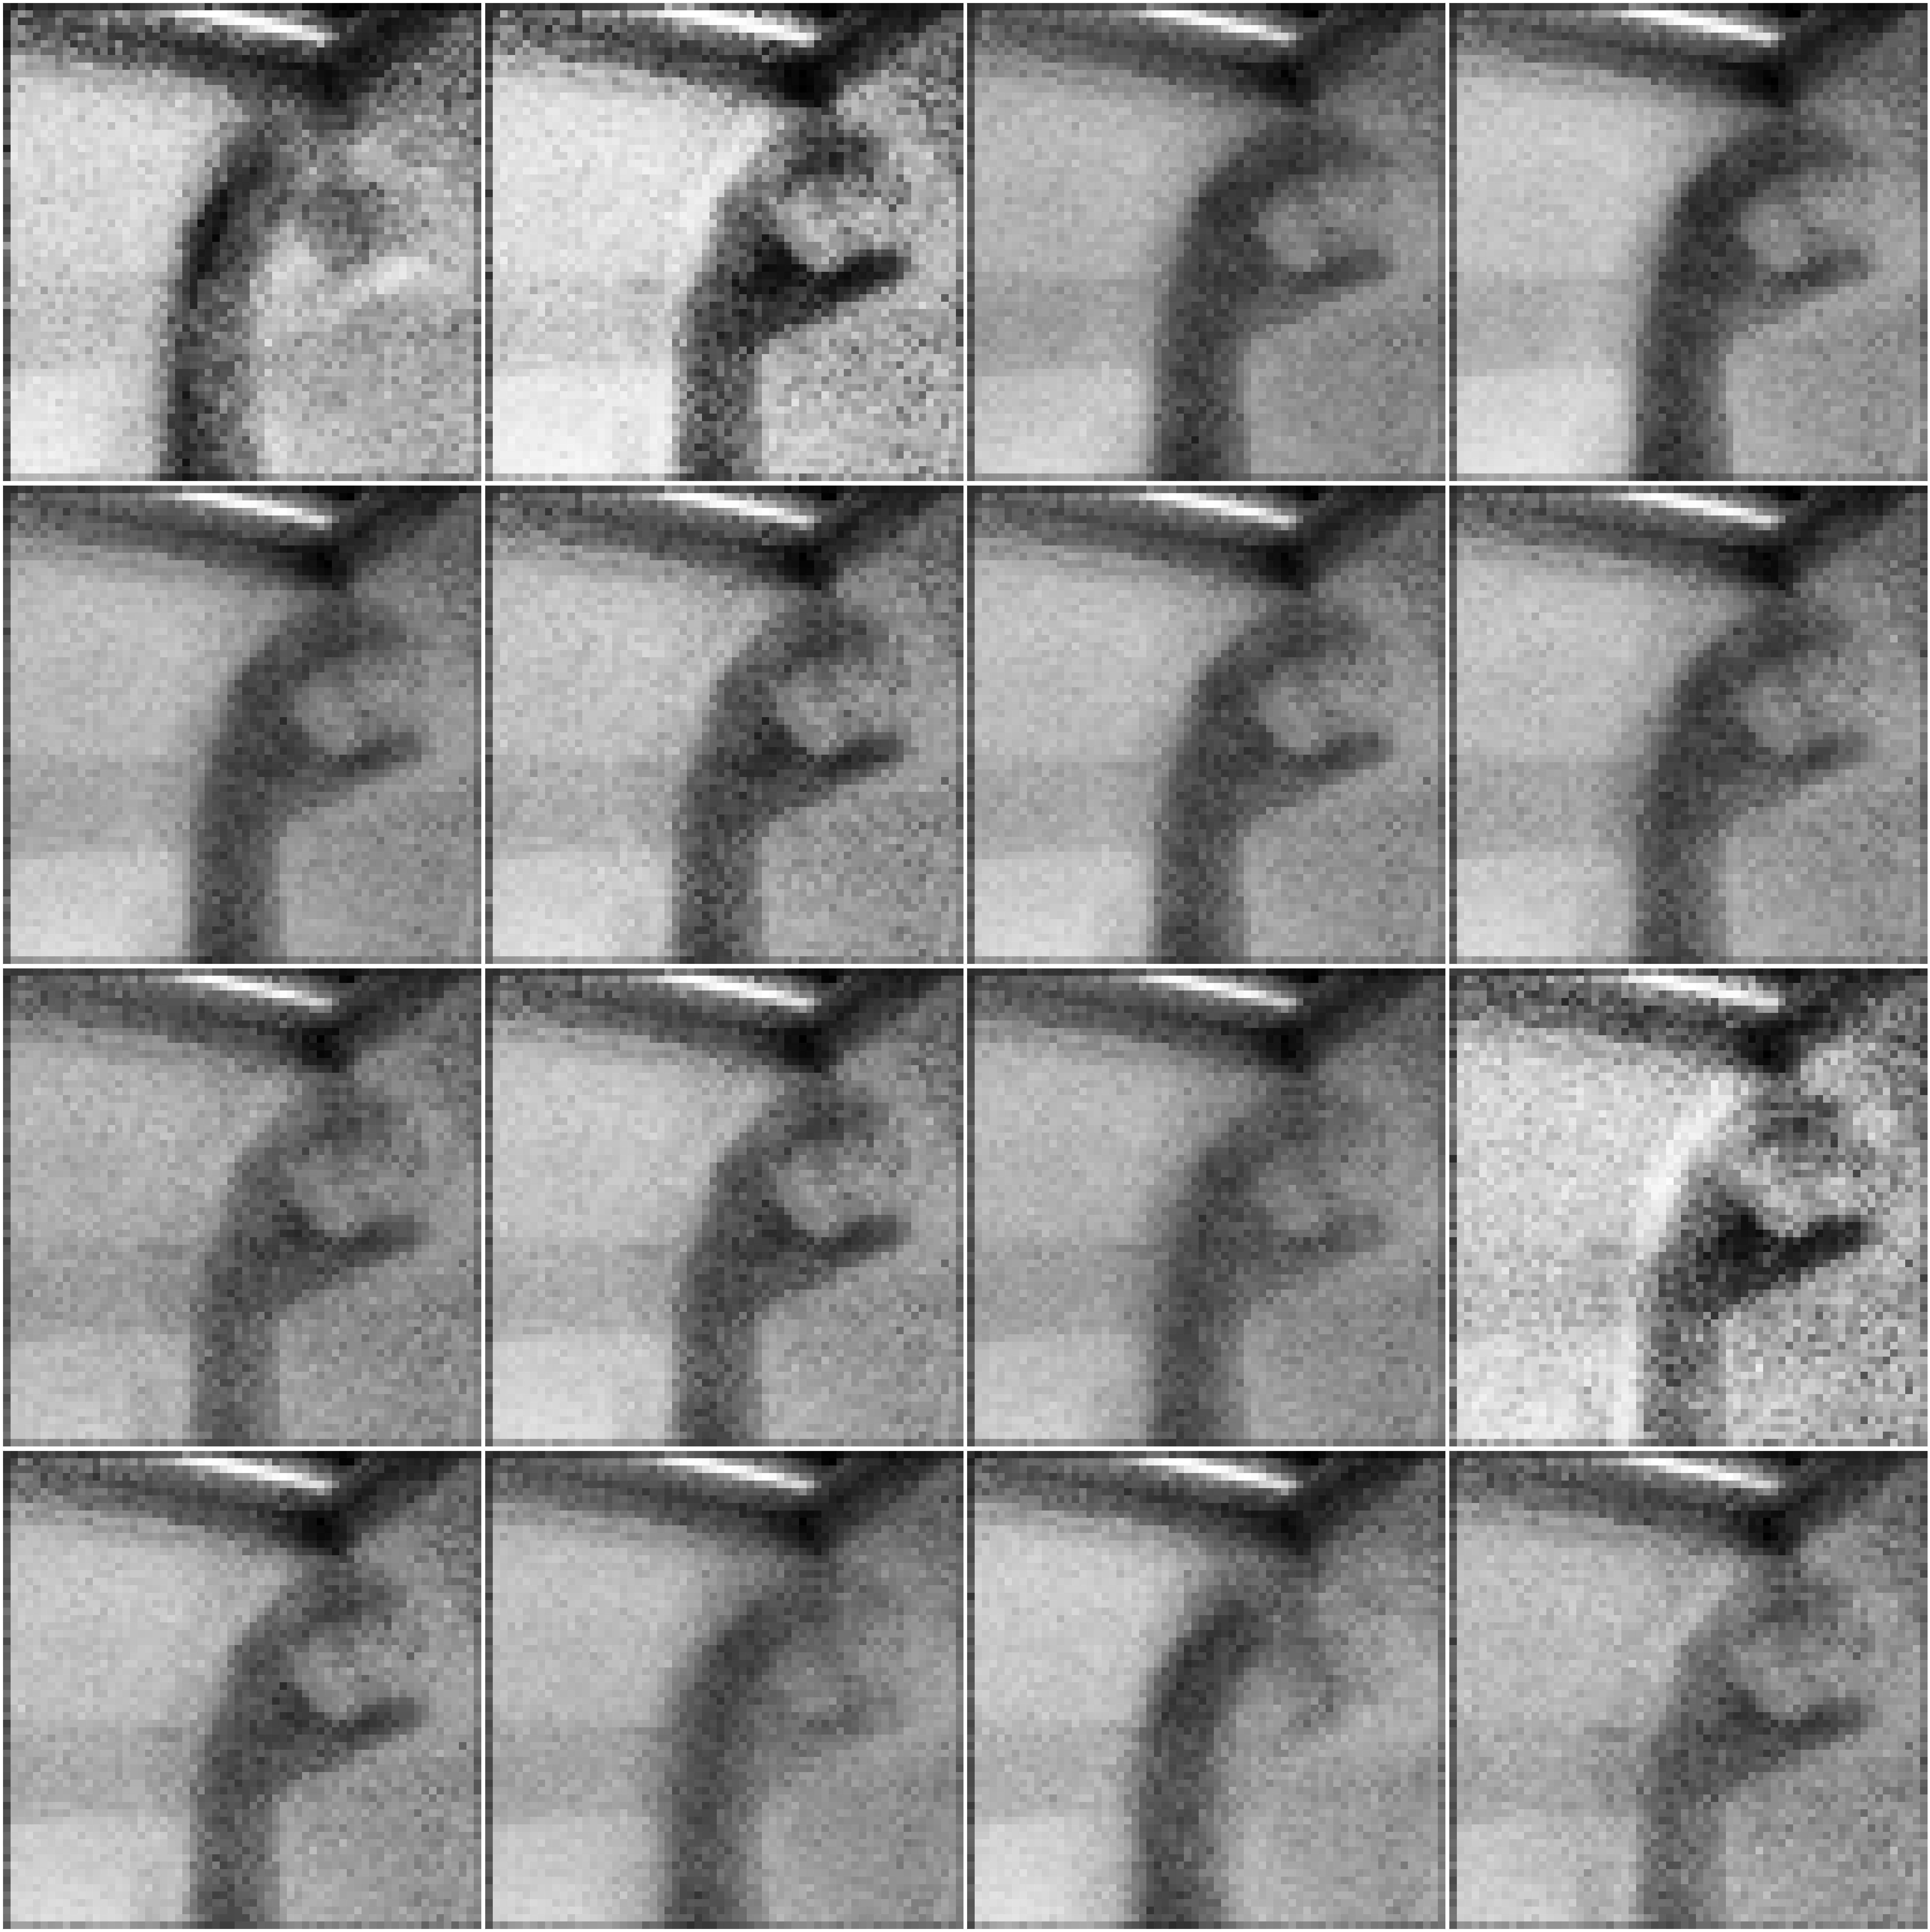

Currently trying combinations:
lr: 0.0001, batch_size: 16, epochs: 50, dropout: 0.5
Completed Epoch 1/50, Epoch Duration: 6.59s, Total Loss D.: 0.0376, Total Loss G.: 3.2856
Completed Epoch 2/50, Epoch Duration: 6.50s, Total Loss D.: 0.0585, Total Loss G.: 2.4972
Completed Epoch 3/50, Epoch Duration: 6.38s, Total Loss D.: 0.0432, Total Loss G.: 3.4651
Completed Epoch 4/50, Epoch Duration: 6.45s, Total Loss D.: 0.0518, Total Loss G.: 2.3383
Completed Epoch 5/50, Epoch Duration: 6.48s, Total Loss D.: 0.4584, Total Loss G.: 3.4239
Completed Epoch 6/50, Epoch Duration: 6.33s, Total Loss D.: 0.0163, Total Loss G.: 7.0173
Completed Epoch 7/50, Epoch Duration: 6.35s, Total Loss D.: 0.4683, Total Loss G.: 2.2076
Completed Epoch 8/50, Epoch Duration: 6.35s, Total Loss D.: 0.2281, Total Loss G.: 2.9417
Completed Epoch 9/50, Epoch Duration: 6.36s, Total Loss D.: 0.0549, Total Loss G.: 5.3916
Completed Epoch 10/50, Epoch Duration: 6.36s, Total Loss D.: 0.0585, Total Loss G.: 3.0175
Completed Epoch

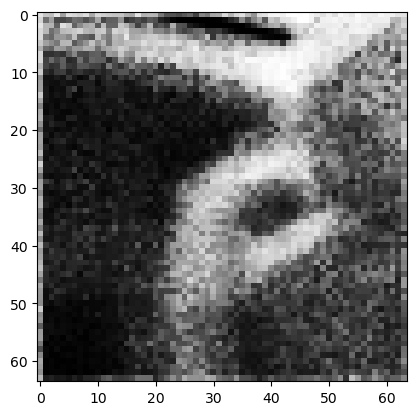

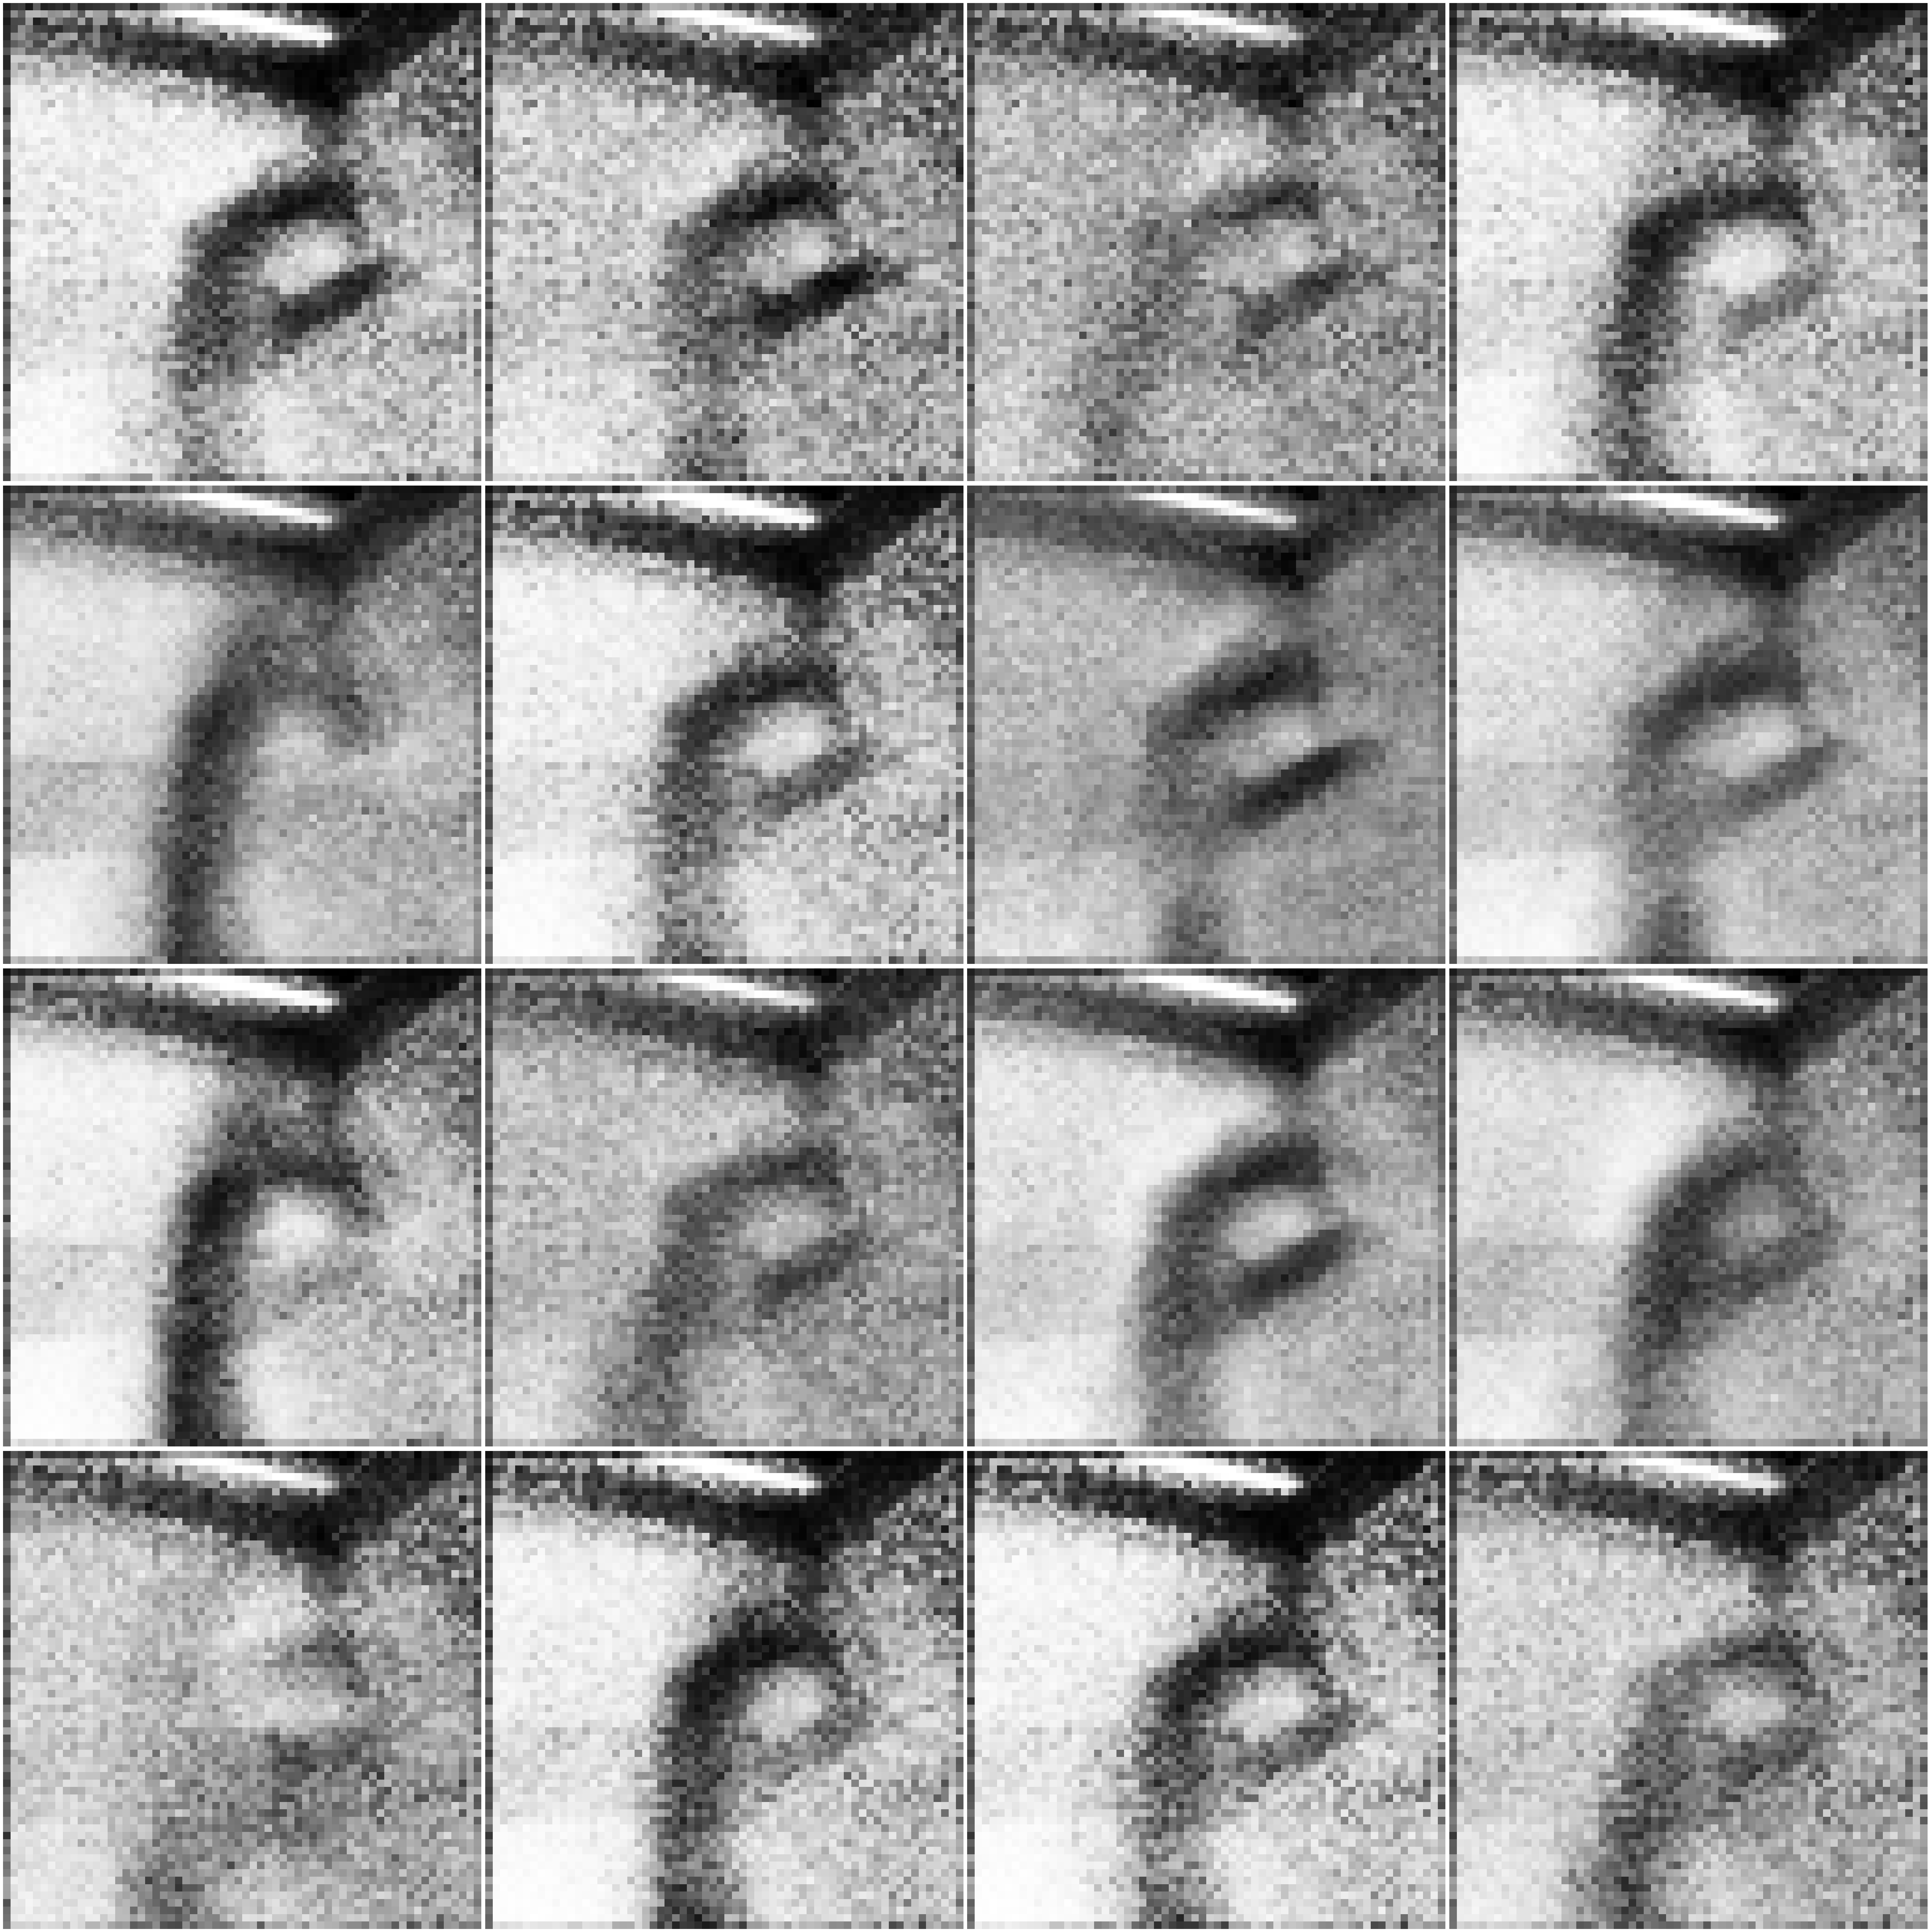

Currently trying combinations:
lr: 0.0001, batch_size: 16, epochs: 100, dropout: 0.3
Completed Epoch 1/100, Epoch Duration: 6.74s, Total Loss D.: 0.0873, Total Loss G.: 2.2142
Completed Epoch 2/100, Epoch Duration: 6.70s, Total Loss D.: 0.0276, Total Loss G.: 3.2872
Completed Epoch 3/100, Epoch Duration: 6.90s, Total Loss D.: 0.0758, Total Loss G.: 2.1501
Completed Epoch 4/100, Epoch Duration: 6.78s, Total Loss D.: 0.2044, Total Loss G.: 2.7750
Completed Epoch 5/100, Epoch Duration: 6.71s, Total Loss D.: 0.1062, Total Loss G.: 2.4318
Completed Epoch 6/100, Epoch Duration: 6.73s, Total Loss D.: 0.3473, Total Loss G.: 7.4202
Completed Epoch 7/100, Epoch Duration: 6.84s, Total Loss D.: 0.1775, Total Loss G.: 37.7854
Completed Epoch 8/100, Epoch Duration: 6.69s, Total Loss D.: 0.4052, Total Loss G.: 6.4462
Completed Epoch 9/100, Epoch Duration: 6.71s, Total Loss D.: 0.0555, Total Loss G.: 4.5392
Completed Epoch 10/100, Epoch Duration: 6.73s, Total Loss D.: 0.0292, Total Loss G.: 5.0329
Com

Completed Epoch 90/100, Epoch Duration: 7.36s, Total Loss D.: 0.0041, Total Loss G.: 6.4957
Completed Epoch 91/100, Epoch Duration: 7.43s, Total Loss D.: 0.0048, Total Loss G.: 6.5872
Completed Epoch 92/100, Epoch Duration: 7.45s, Total Loss D.: 0.0264, Total Loss G.: 5.2485
Completed Epoch 93/100, Epoch Duration: 7.27s, Total Loss D.: 0.0059, Total Loss G.: 5.5310
Completed Epoch 94/100, Epoch Duration: 7.59s, Total Loss D.: 0.0064, Total Loss G.: 6.9511
Completed Epoch 95/100, Epoch Duration: 7.25s, Total Loss D.: 0.0199, Total Loss G.: 4.2466
Completed Epoch 96/100, Epoch Duration: 7.30s, Total Loss D.: 0.0110, Total Loss G.: 4.7074
Completed Epoch 97/100, Epoch Duration: 7.39s, Total Loss D.: 0.0499, Total Loss G.: 7.2847
Completed Epoch 98/100, Epoch Duration: 7.18s, Total Loss D.: 0.0070, Total Loss G.: 6.6683
Completed Epoch 99/100, Epoch Duration: 7.30s, Total Loss D.: 0.0485, Total Loss G.: 7.3645
Completed Epoch 100/100, Epoch Duration: 7.32s, Total Loss D.: 0.0317, Total Los

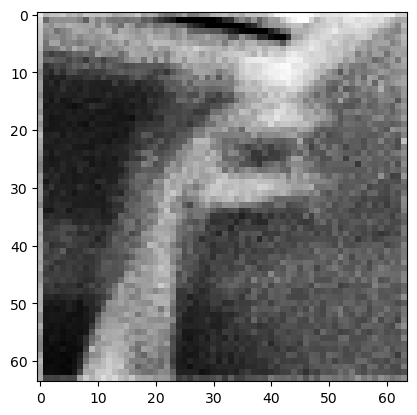

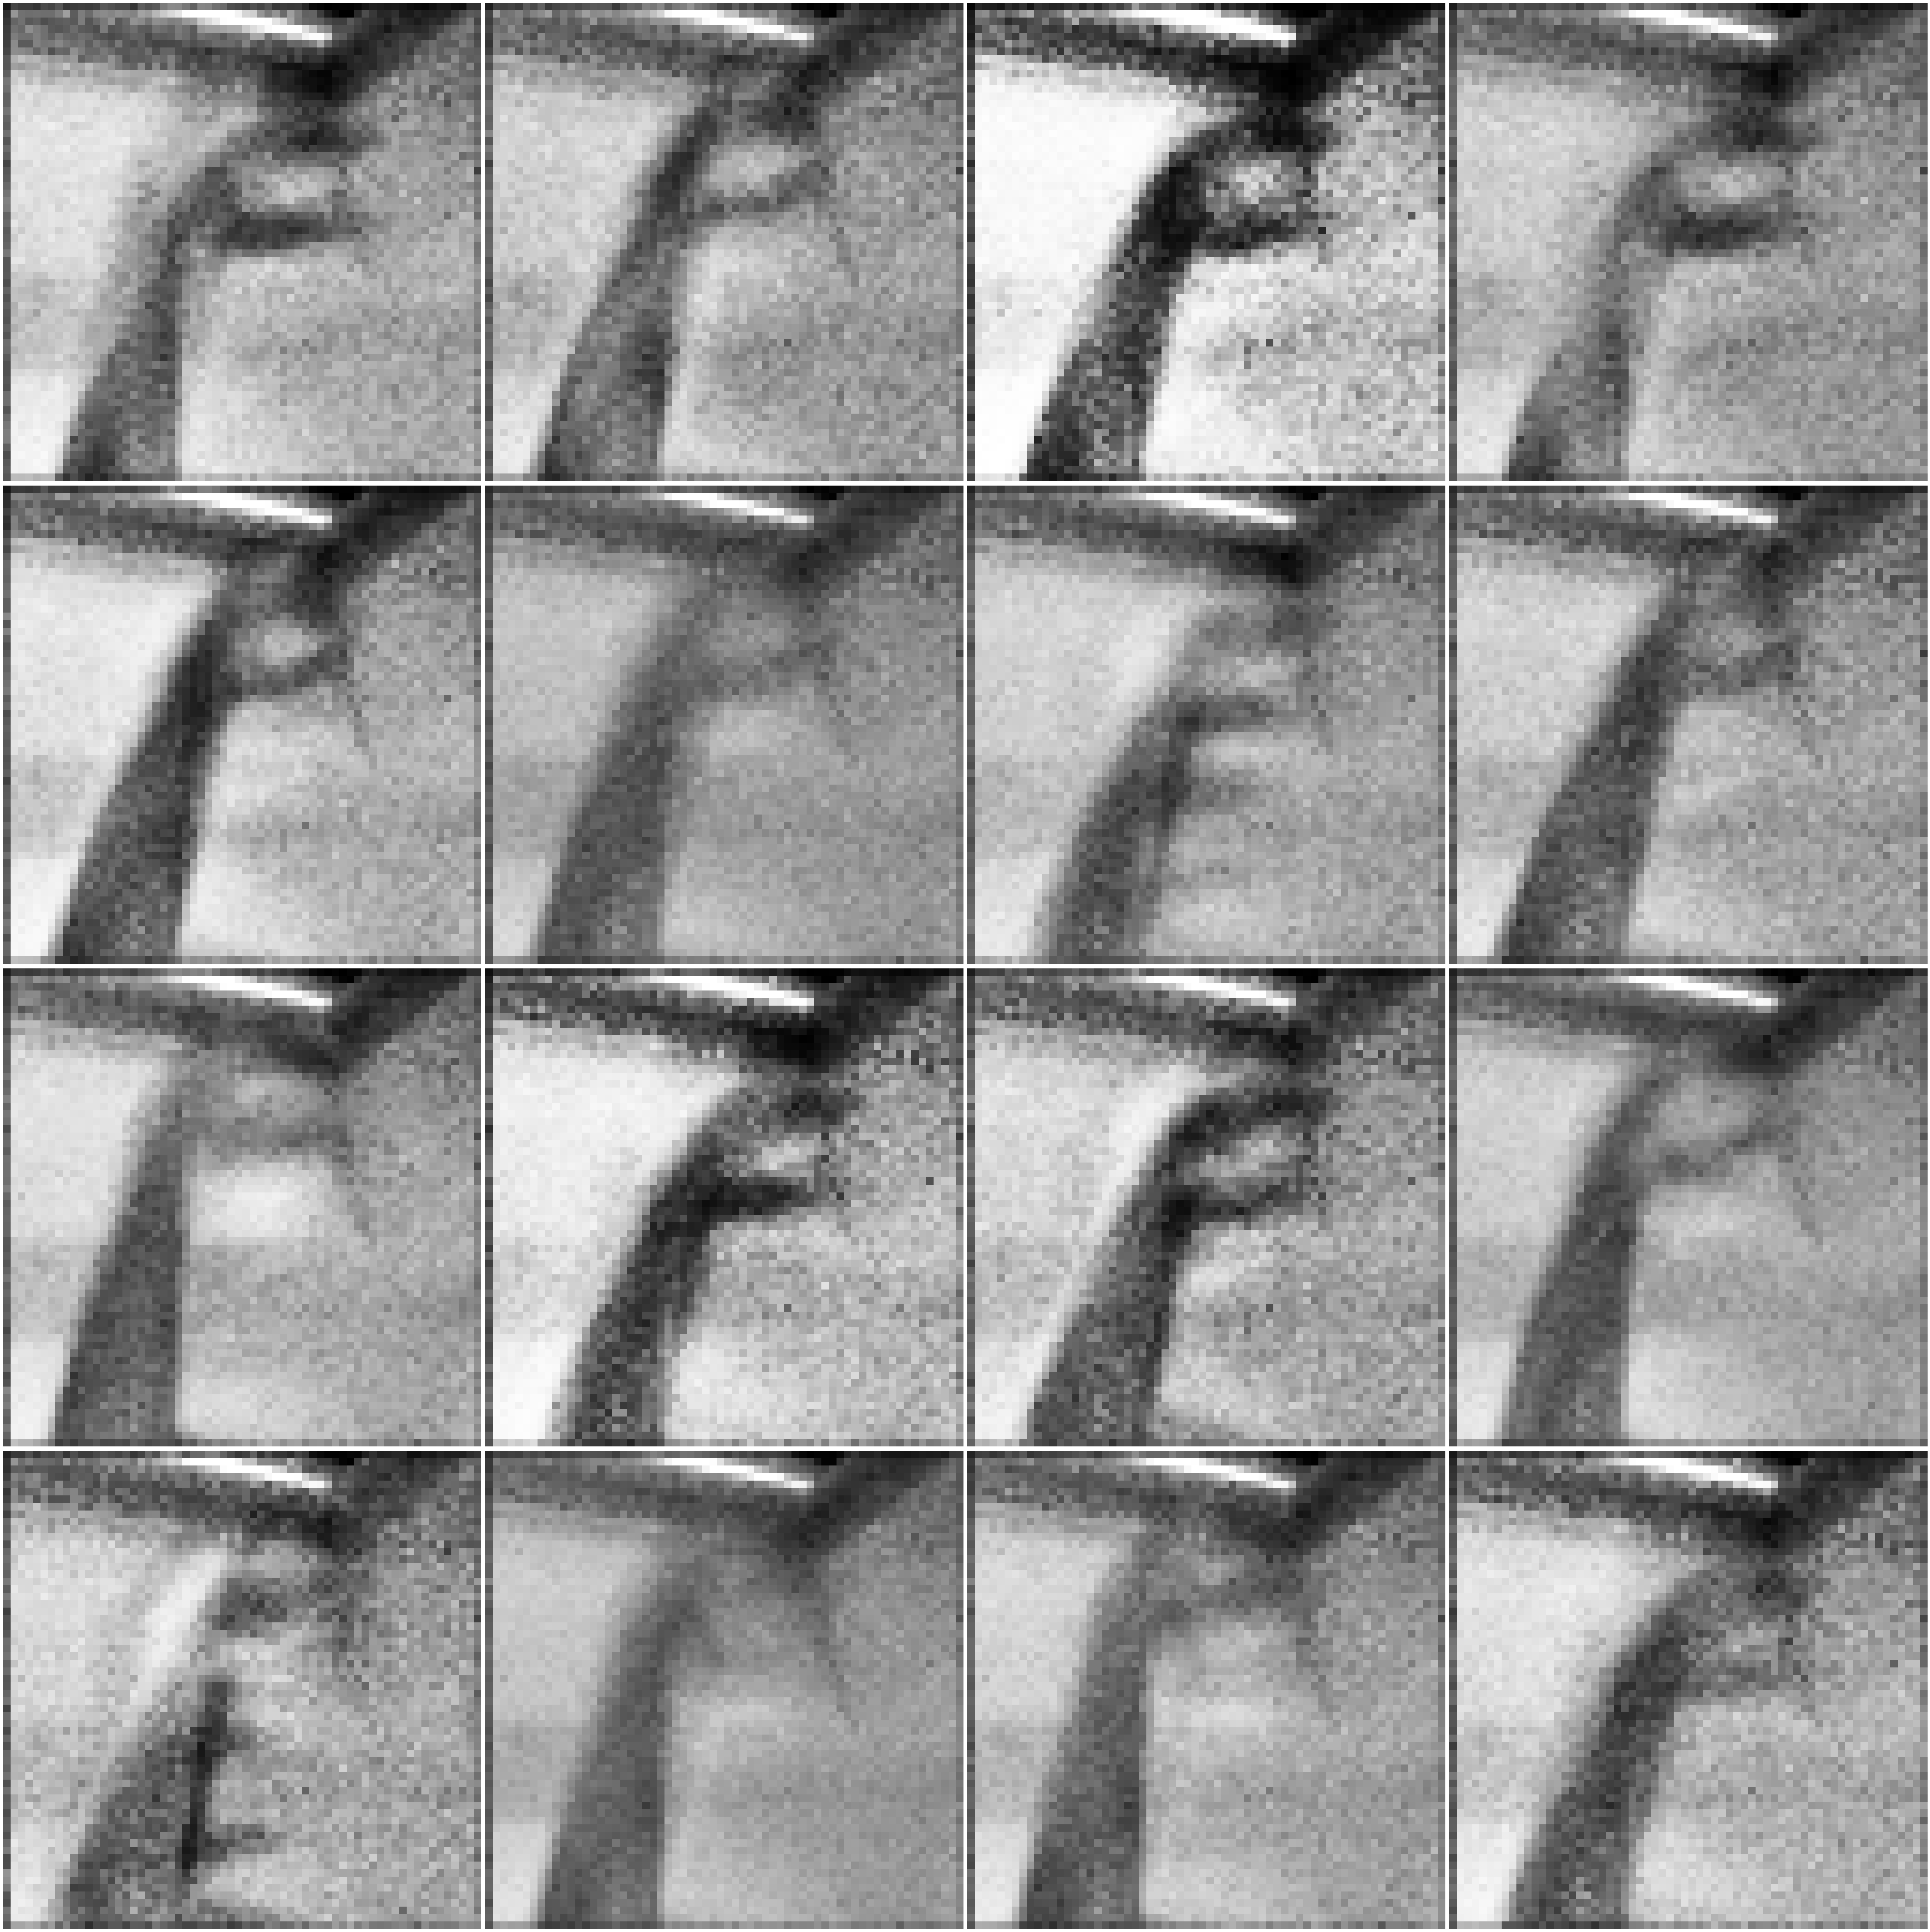

Currently trying combinations:
lr: 0.0001, batch_size: 16, epochs: 100, dropout: 0.5
Completed Epoch 1/100, Epoch Duration: 7.55s, Total Loss D.: 0.0421, Total Loss G.: 3.4566
Completed Epoch 2/100, Epoch Duration: 7.49s, Total Loss D.: 0.0246, Total Loss G.: 3.4718
Completed Epoch 3/100, Epoch Duration: 7.26s, Total Loss D.: 0.0473, Total Loss G.: 3.1519
Completed Epoch 4/100, Epoch Duration: 7.44s, Total Loss D.: 0.0338, Total Loss G.: 3.1432
Completed Epoch 5/100, Epoch Duration: 7.40s, Total Loss D.: 0.0339, Total Loss G.: 4.6754
Completed Epoch 6/100, Epoch Duration: 7.95s, Total Loss D.: 0.0242, Total Loss G.: 4.8909
Completed Epoch 7/100, Epoch Duration: 7.15s, Total Loss D.: 0.3849, Total Loss G.: 1.1525
Completed Epoch 8/100, Epoch Duration: 7.14s, Total Loss D.: 0.1444, Total Loss G.: 2.6535
Completed Epoch 9/100, Epoch Duration: 7.07s, Total Loss D.: 0.2074, Total Loss G.: 5.1673
Completed Epoch 10/100, Epoch Duration: 7.21s, Total Loss D.: 0.1581, Total Loss G.: 7.0553
Comp

Completed Epoch 90/100, Epoch Duration: 7.00s, Total Loss D.: 0.0008, Total Loss G.: 6.4314
Completed Epoch 91/100, Epoch Duration: 6.92s, Total Loss D.: 0.0398, Total Loss G.: 3.6241
Completed Epoch 92/100, Epoch Duration: 6.97s, Total Loss D.: 0.0522, Total Loss G.: 5.1125
Completed Epoch 93/100, Epoch Duration: 6.85s, Total Loss D.: 0.0093, Total Loss G.: 5.3134
Completed Epoch 94/100, Epoch Duration: 6.87s, Total Loss D.: 0.0333, Total Loss G.: 5.1098
Completed Epoch 95/100, Epoch Duration: 6.95s, Total Loss D.: 0.0211, Total Loss G.: 5.8971
Completed Epoch 96/100, Epoch Duration: 7.09s, Total Loss D.: 0.0103, Total Loss G.: 5.0372
Completed Epoch 97/100, Epoch Duration: 6.91s, Total Loss D.: 0.0624, Total Loss G.: 4.8232
Completed Epoch 98/100, Epoch Duration: 6.89s, Total Loss D.: 0.0788, Total Loss G.: 4.0525
Completed Epoch 99/100, Epoch Duration: 6.90s, Total Loss D.: 0.0185, Total Loss G.: 4.9386
Completed Epoch 100/100, Epoch Duration: 6.91s, Total Loss D.: 0.1315, Total Los

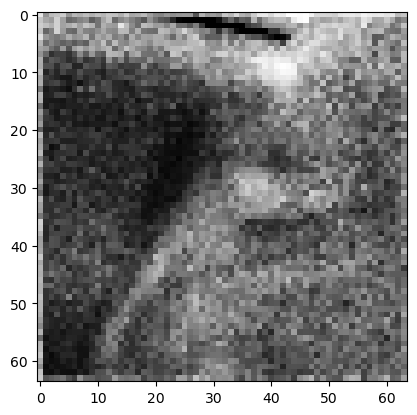

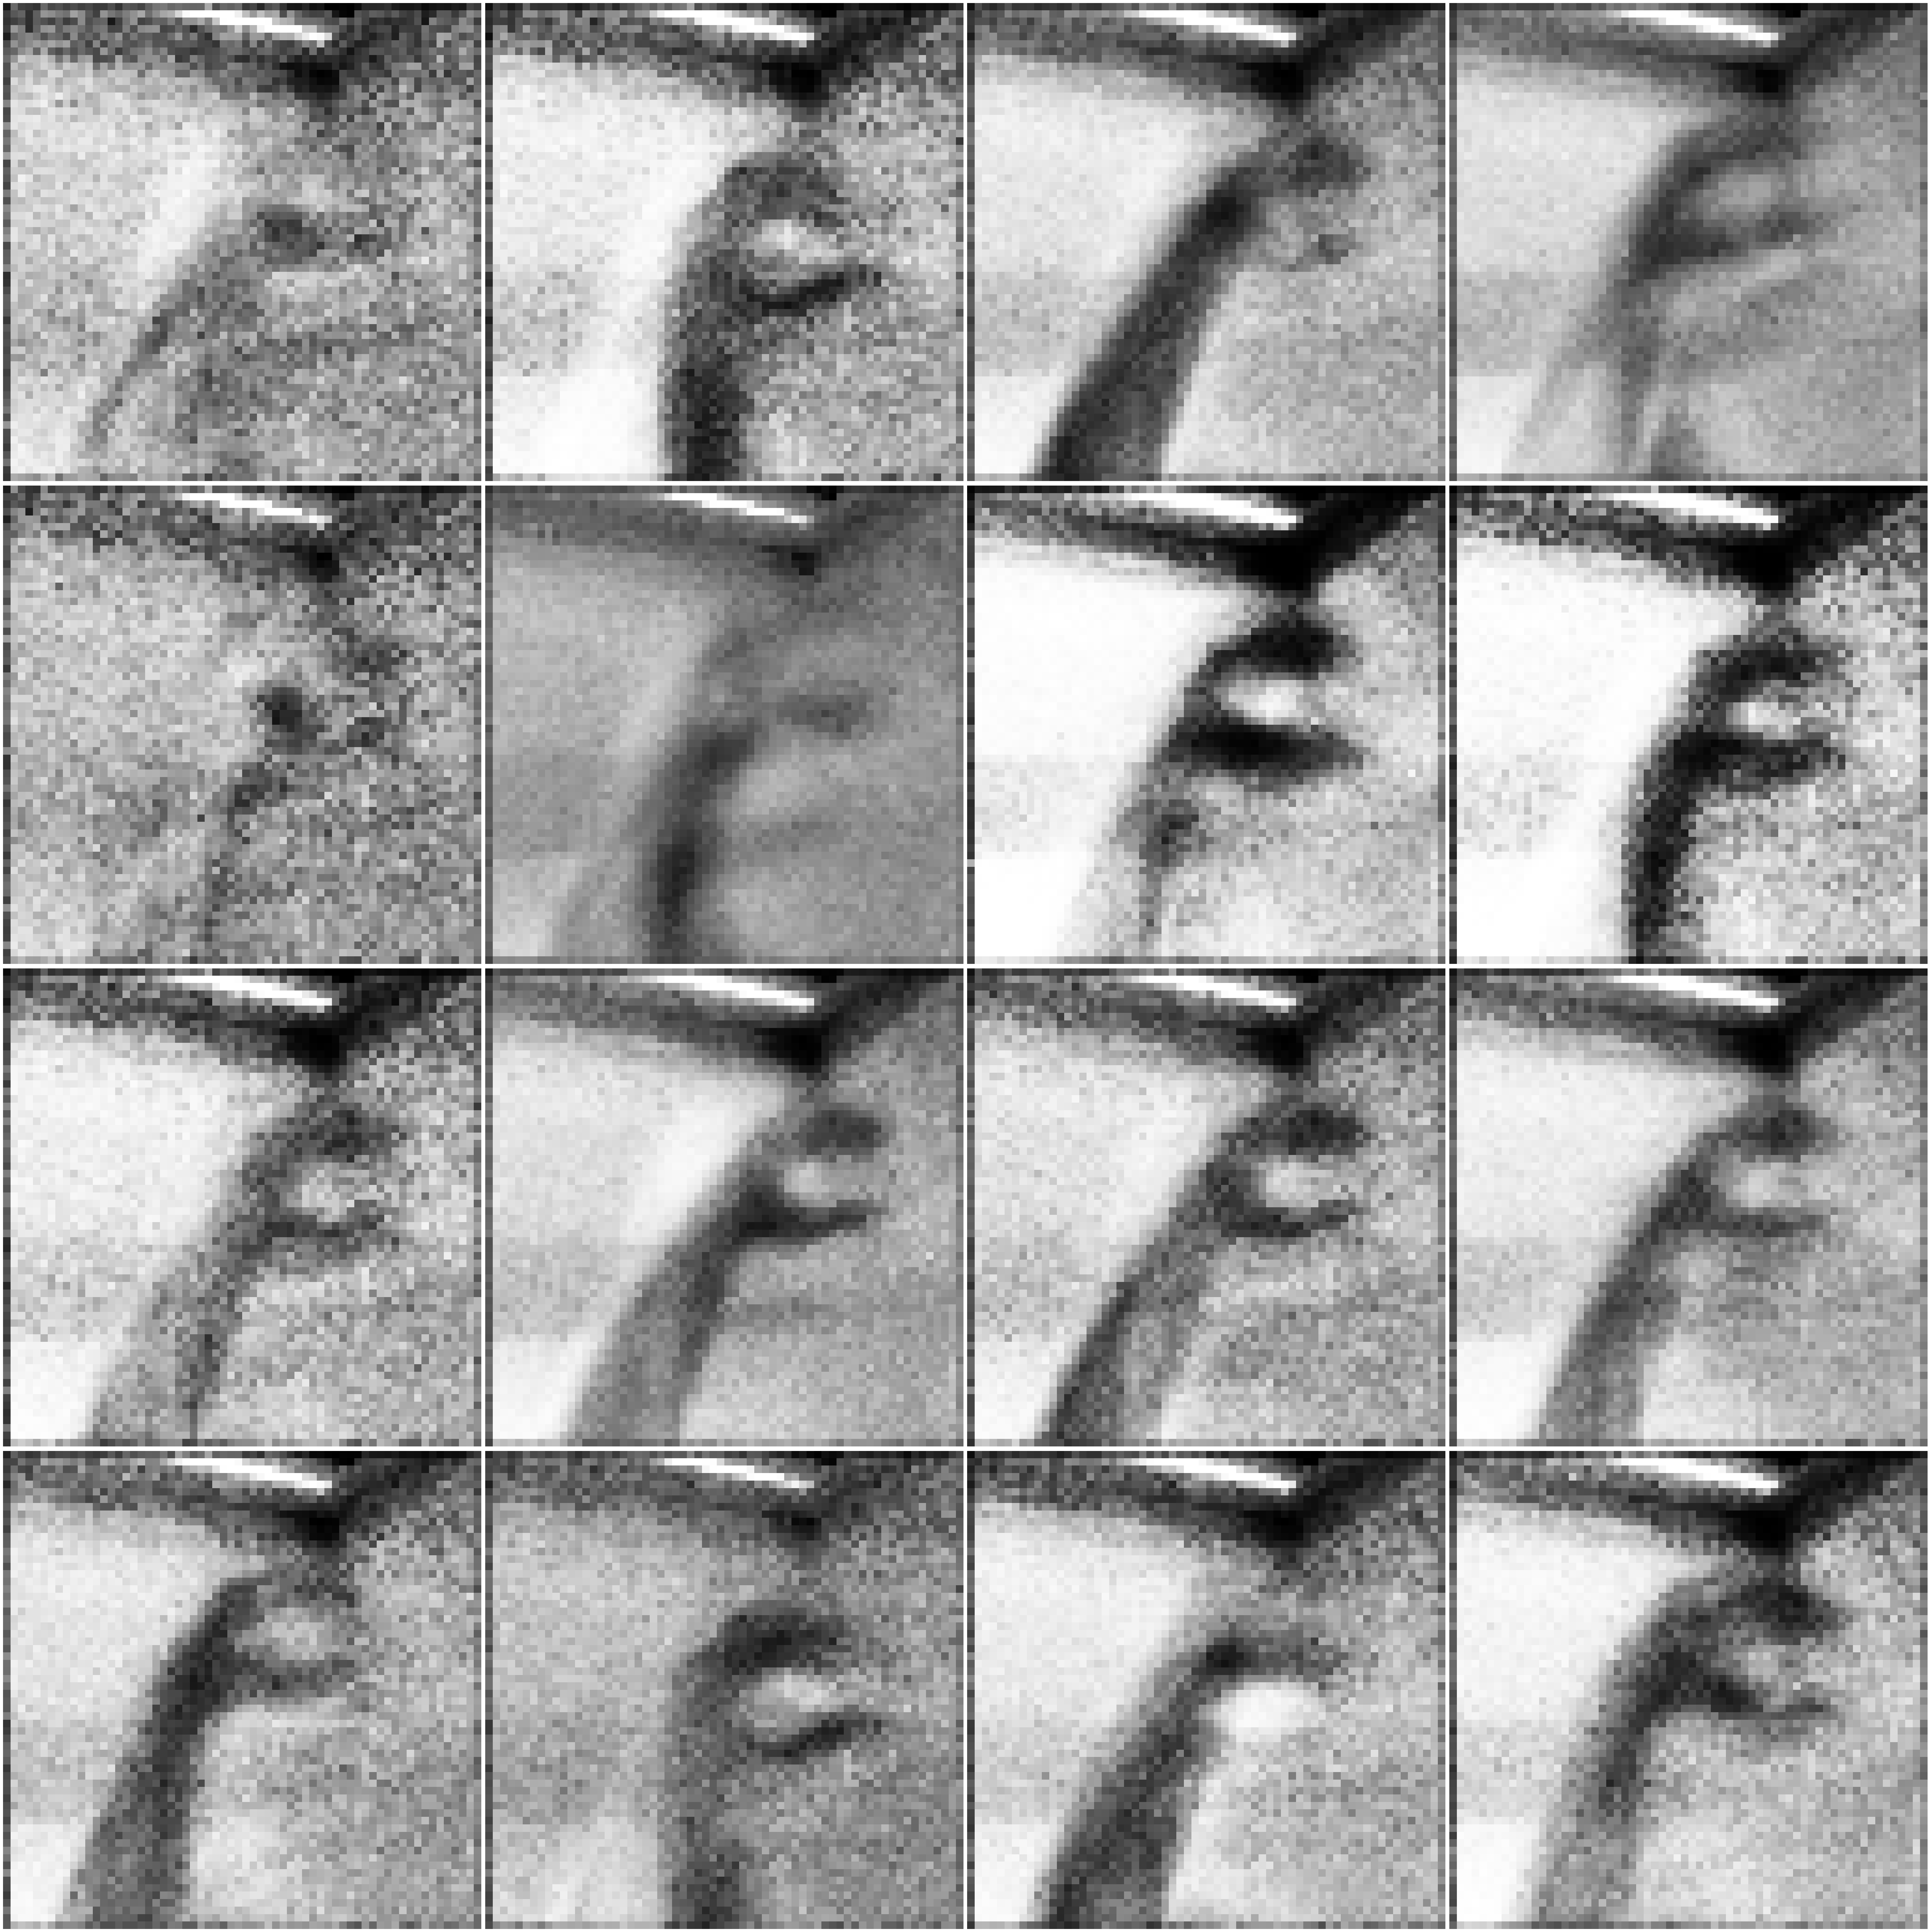

Currently trying combinations:
lr: 0.0001, batch_size: 32, epochs: 50, dropout: 0.3
Completed Epoch 1/50, Epoch Duration: 6.96s, Total Loss D.: 0.0838, Total Loss G.: 2.1453
Completed Epoch 2/50, Epoch Duration: 6.90s, Total Loss D.: 0.0313, Total Loss G.: 3.4287
Completed Epoch 3/50, Epoch Duration: 7.07s, Total Loss D.: 0.1748, Total Loss G.: 1.7618
Completed Epoch 4/50, Epoch Duration: 7.38s, Total Loss D.: 0.0264, Total Loss G.: 4.6701
Completed Epoch 5/50, Epoch Duration: 7.29s, Total Loss D.: 0.0264, Total Loss G.: 4.5573
Completed Epoch 6/50, Epoch Duration: 7.03s, Total Loss D.: 0.3992, Total Loss G.: 8.7902
Completed Epoch 7/50, Epoch Duration: 6.93s, Total Loss D.: 0.3442, Total Loss G.: 4.4974
Completed Epoch 8/50, Epoch Duration: 6.90s, Total Loss D.: 0.4631, Total Loss G.: 6.4586
Completed Epoch 9/50, Epoch Duration: 6.92s, Total Loss D.: 0.0159, Total Loss G.: 4.2105
Completed Epoch 10/50, Epoch Duration: 6.92s, Total Loss D.: 0.0525, Total Loss G.: 2.9121
Completed Epoch

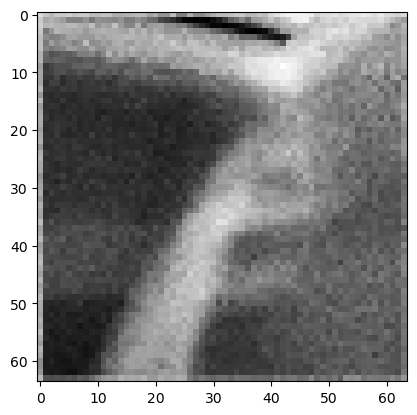

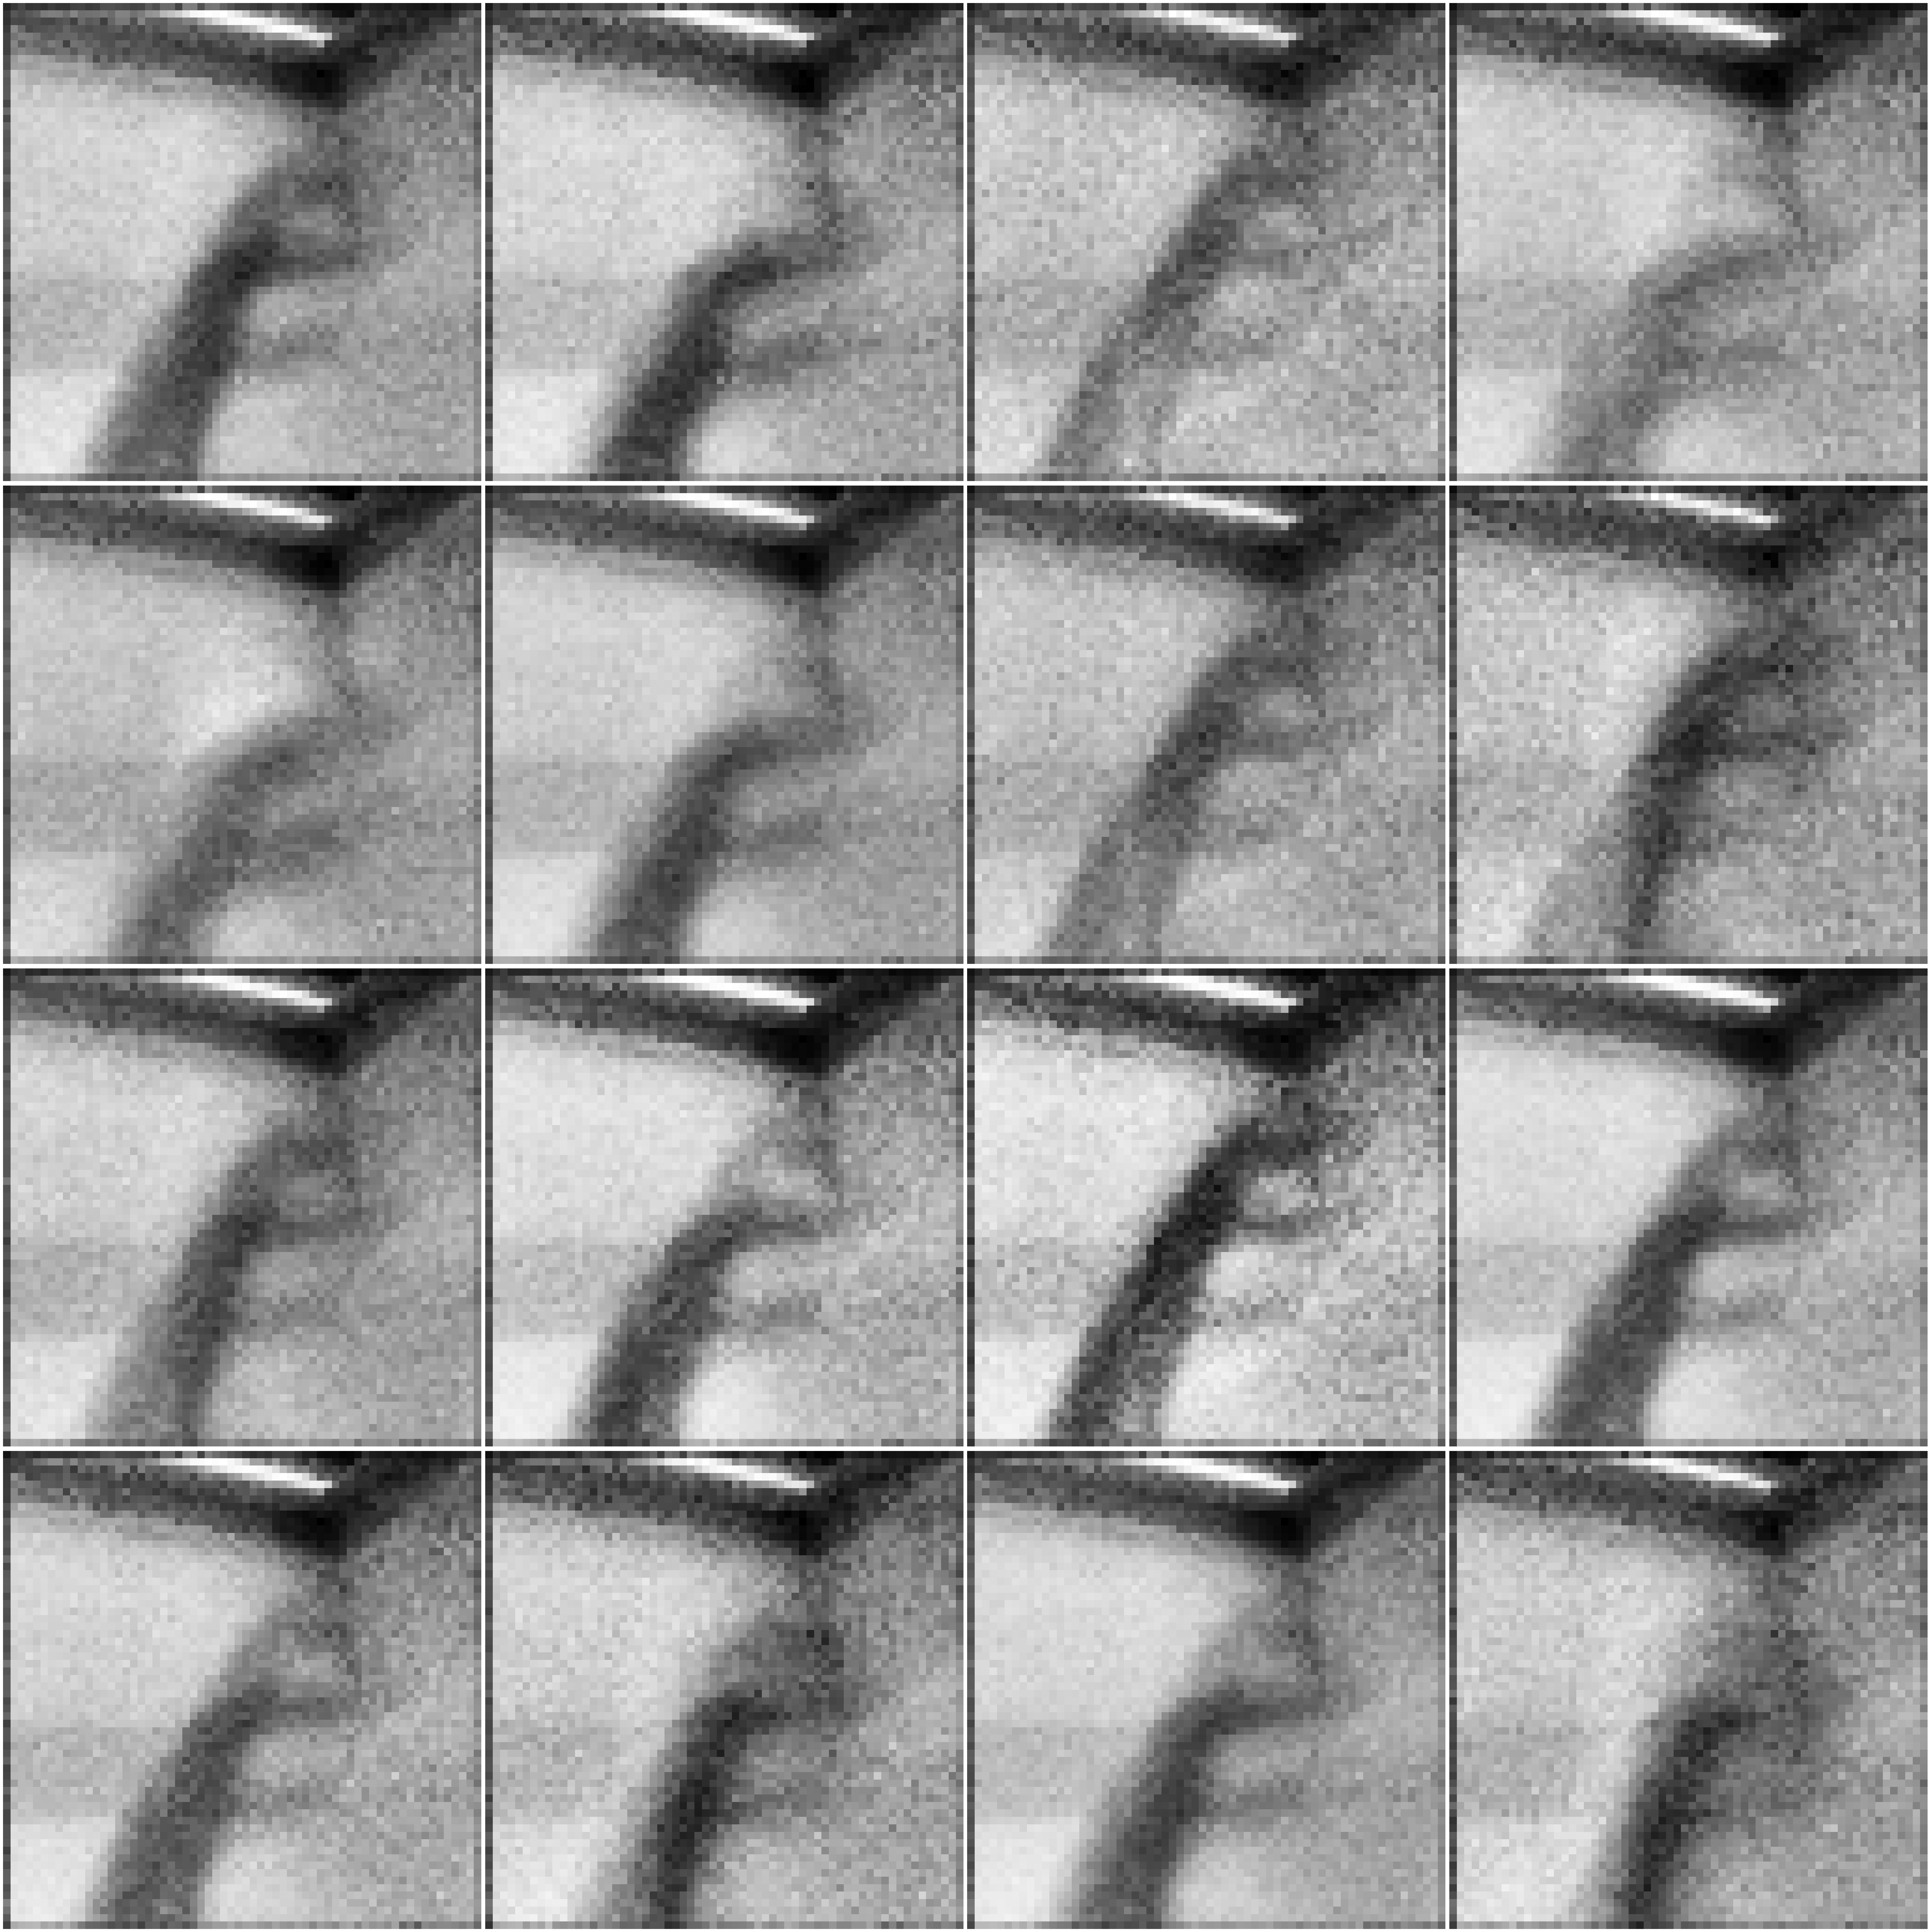

Currently trying combinations:
lr: 0.0001, batch_size: 32, epochs: 50, dropout: 0.5
Completed Epoch 1/50, Epoch Duration: 6.89s, Total Loss D.: 0.0516, Total Loss G.: 3.2244
Completed Epoch 2/50, Epoch Duration: 6.94s, Total Loss D.: 0.0295, Total Loss G.: 3.3239
Completed Epoch 3/50, Epoch Duration: 6.86s, Total Loss D.: 0.0277, Total Loss G.: 3.5505
Completed Epoch 4/50, Epoch Duration: 6.96s, Total Loss D.: 0.0157, Total Loss G.: 5.0874
Completed Epoch 5/50, Epoch Duration: 6.93s, Total Loss D.: 0.0092, Total Loss G.: 4.6128
Completed Epoch 6/50, Epoch Duration: 7.03s, Total Loss D.: 0.2405, Total Loss G.: 3.5352
Completed Epoch 7/50, Epoch Duration: 6.92s, Total Loss D.: 0.2739, Total Loss G.: 2.0897
Completed Epoch 8/50, Epoch Duration: 6.91s, Total Loss D.: 0.4139, Total Loss G.: 1.3406
Completed Epoch 9/50, Epoch Duration: 6.92s, Total Loss D.: 0.0346, Total Loss G.: 5.4484
Completed Epoch 10/50, Epoch Duration: 6.95s, Total Loss D.: 0.1634, Total Loss G.: 8.2519
Completed Epoch

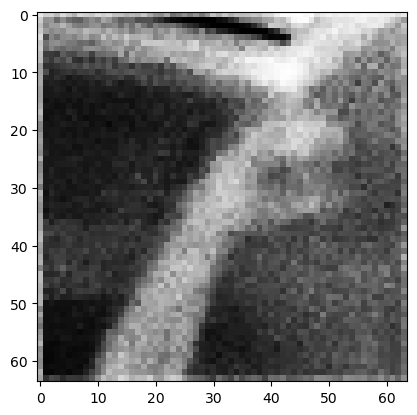

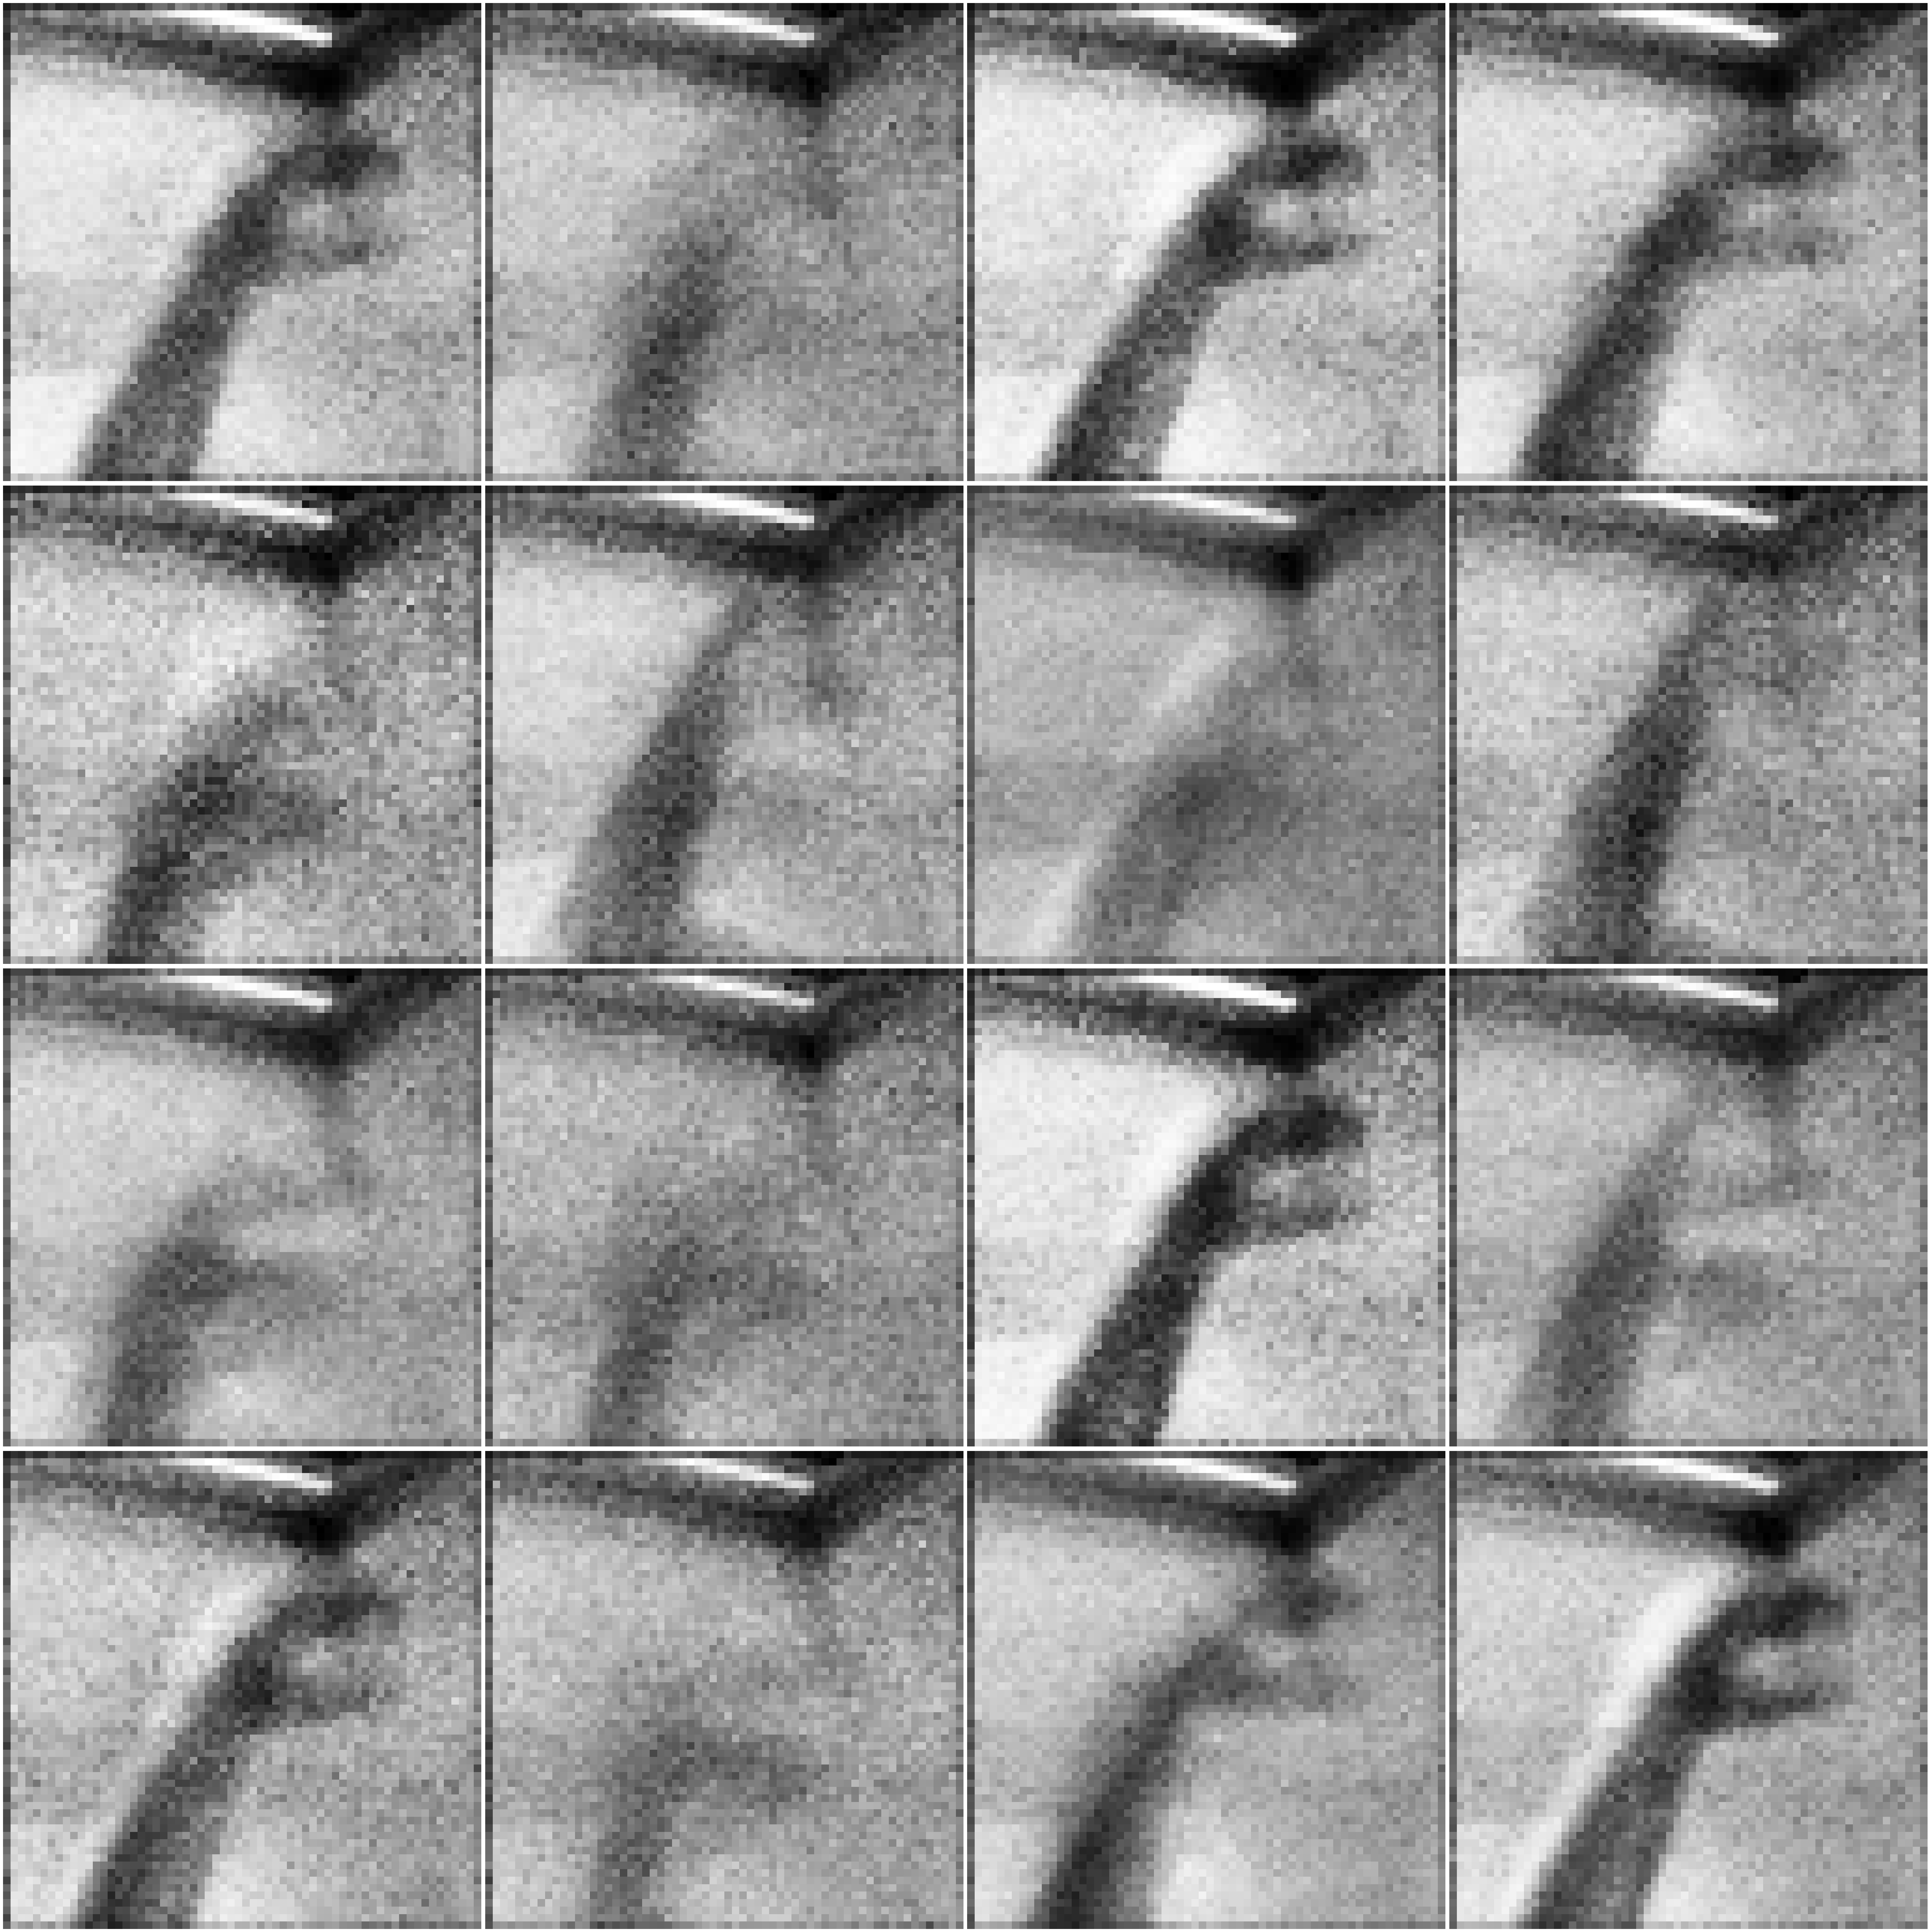

Currently trying combinations:
lr: 0.0001, batch_size: 32, epochs: 100, dropout: 0.3
Completed Epoch 1/100, Epoch Duration: 7.14s, Total Loss D.: 0.0849, Total Loss G.: 2.3942
Completed Epoch 2/100, Epoch Duration: 7.28s, Total Loss D.: 0.0441, Total Loss G.: 2.7225
Completed Epoch 3/100, Epoch Duration: 7.18s, Total Loss D.: 0.0422, Total Loss G.: 2.8846
Completed Epoch 4/100, Epoch Duration: 6.92s, Total Loss D.: 0.5446, Total Loss G.: 2.6447
Completed Epoch 5/100, Epoch Duration: 6.98s, Total Loss D.: 0.0514, Total Loss G.: 4.2415
Completed Epoch 6/100, Epoch Duration: 7.07s, Total Loss D.: 0.0705, Total Loss G.: 7.1281
Completed Epoch 7/100, Epoch Duration: 6.88s, Total Loss D.: 0.0489, Total Loss G.: 3.9538
Completed Epoch 8/100, Epoch Duration: 6.90s, Total Loss D.: 0.9806, Total Loss G.: 4.1330
Completed Epoch 9/100, Epoch Duration: 6.90s, Total Loss D.: 0.4455, Total Loss G.: 2.1267
Completed Epoch 10/100, Epoch Duration: 6.91s, Total Loss D.: 0.0763, Total Loss G.: 3.0230
Comp

Completed Epoch 90/100, Epoch Duration: 6.86s, Total Loss D.: 0.1286, Total Loss G.: 6.7770
Completed Epoch 91/100, Epoch Duration: 6.84s, Total Loss D.: 0.0318, Total Loss G.: 5.6394
Completed Epoch 92/100, Epoch Duration: 6.92s, Total Loss D.: 0.0575, Total Loss G.: 5.6339
Completed Epoch 93/100, Epoch Duration: 6.89s, Total Loss D.: 0.0061, Total Loss G.: 5.8555
Completed Epoch 94/100, Epoch Duration: 6.81s, Total Loss D.: 0.0051, Total Loss G.: 5.4790
Completed Epoch 95/100, Epoch Duration: 6.83s, Total Loss D.: 0.0100, Total Loss G.: 4.7654
Completed Epoch 96/100, Epoch Duration: 6.77s, Total Loss D.: 0.0251, Total Loss G.: 4.8848
Completed Epoch 97/100, Epoch Duration: 6.83s, Total Loss D.: 0.0667, Total Loss G.: 6.7443
Completed Epoch 98/100, Epoch Duration: 6.86s, Total Loss D.: 0.0097, Total Loss G.: 5.6930
Completed Epoch 99/100, Epoch Duration: 7.05s, Total Loss D.: 0.0303, Total Loss G.: 5.2212
Completed Epoch 100/100, Epoch Duration: 6.86s, Total Loss D.: 0.0149, Total Los

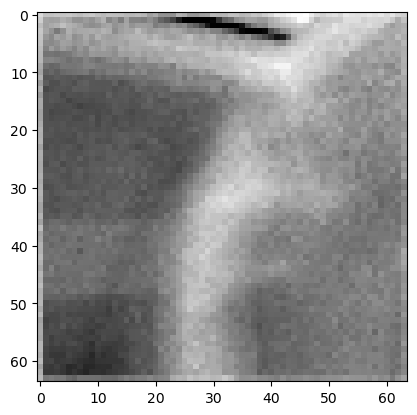

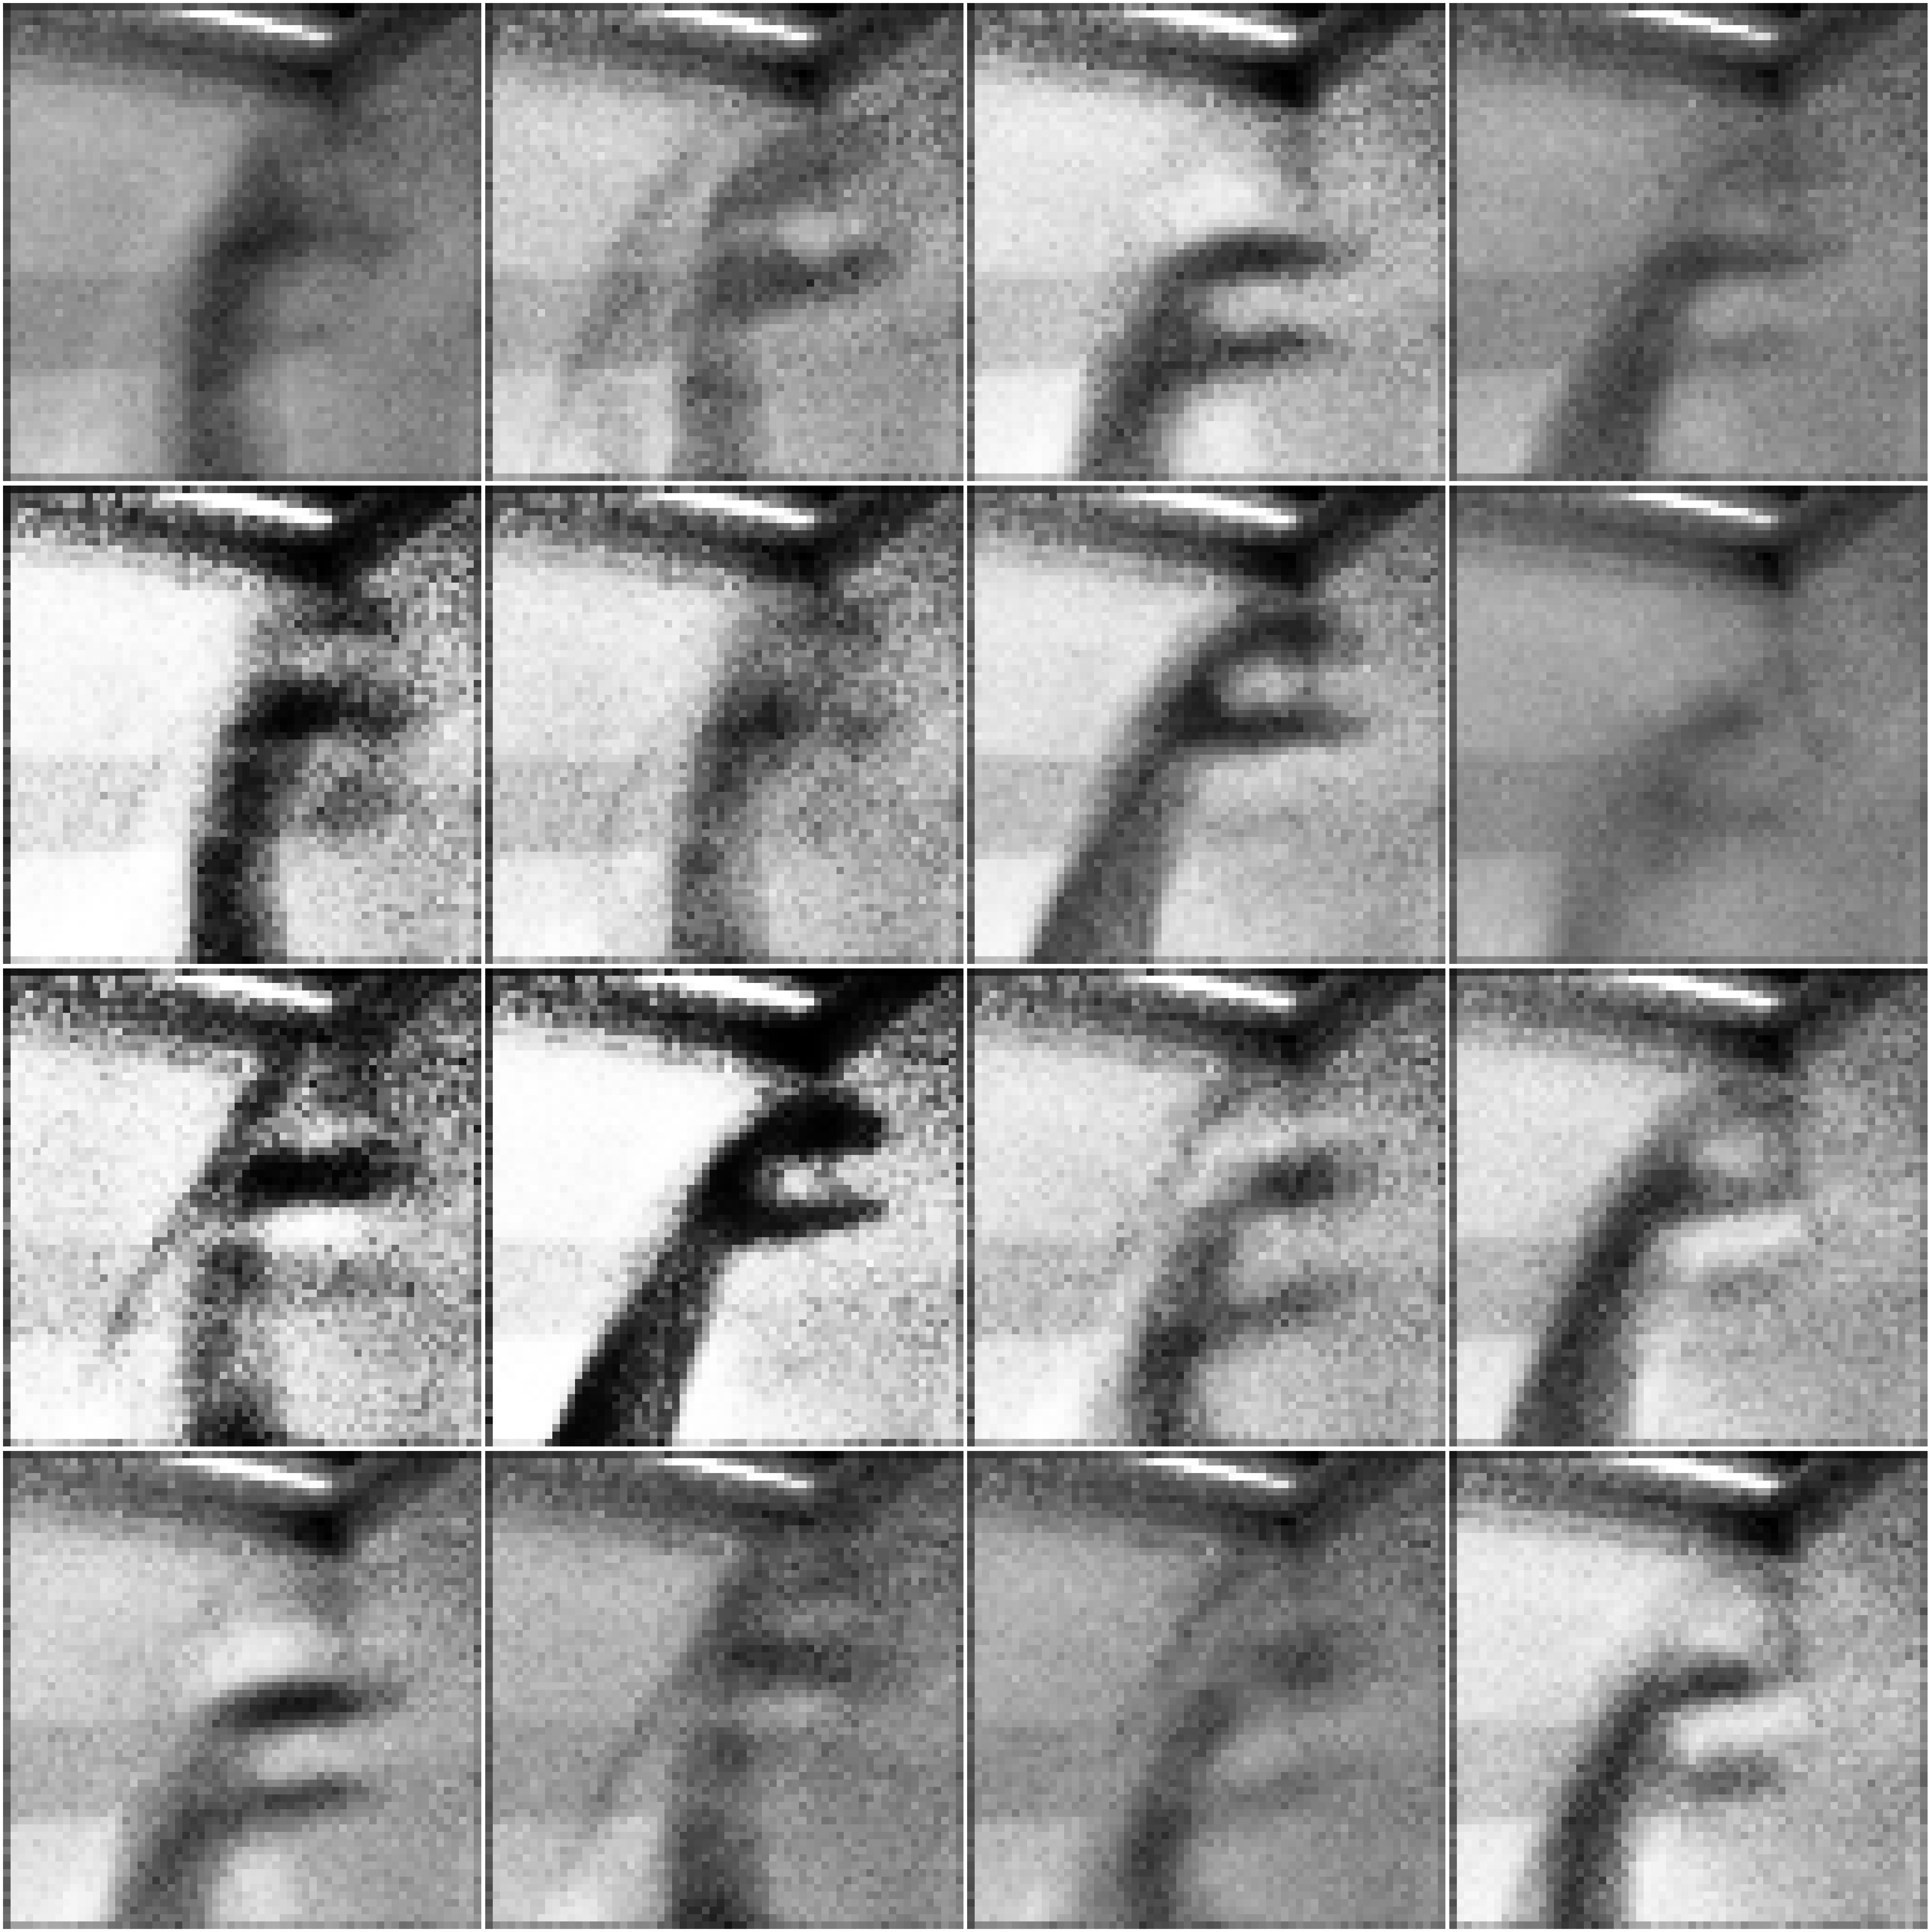

Currently trying combinations:
lr: 0.0001, batch_size: 32, epochs: 100, dropout: 0.5
Completed Epoch 1/100, Epoch Duration: 6.83s, Total Loss D.: 0.0283, Total Loss G.: 3.6275
Completed Epoch 2/100, Epoch Duration: 6.60s, Total Loss D.: 0.0348, Total Loss G.: 2.9531
Completed Epoch 3/100, Epoch Duration: 6.70s, Total Loss D.: 0.0065, Total Loss G.: 4.8424
Completed Epoch 4/100, Epoch Duration: 6.68s, Total Loss D.: 0.0212, Total Loss G.: 3.5885
Completed Epoch 5/100, Epoch Duration: 6.71s, Total Loss D.: 0.0047, Total Loss G.: 6.1020
Completed Epoch 6/100, Epoch Duration: 6.69s, Total Loss D.: 0.4562, Total Loss G.: 5.7912
Completed Epoch 7/100, Epoch Duration: 6.67s, Total Loss D.: 0.1187, Total Loss G.: 4.3496
Completed Epoch 8/100, Epoch Duration: 6.72s, Total Loss D.: 0.0843, Total Loss G.: 5.7917
Completed Epoch 9/100, Epoch Duration: 6.77s, Total Loss D.: 0.0456, Total Loss G.: 3.9881
Completed Epoch 10/100, Epoch Duration: 6.76s, Total Loss D.: 0.2147, Total Loss G.: 2.3122
Comp

Completed Epoch 90/100, Epoch Duration: 6.83s, Total Loss D.: 0.0967, Total Loss G.: 4.4561
Completed Epoch 91/100, Epoch Duration: 6.69s, Total Loss D.: 0.0195, Total Loss G.: 6.2209
Completed Epoch 92/100, Epoch Duration: 6.63s, Total Loss D.: 0.0304, Total Loss G.: 4.8700
Completed Epoch 93/100, Epoch Duration: 6.64s, Total Loss D.: 0.0113, Total Loss G.: 5.2060
Completed Epoch 94/100, Epoch Duration: 6.65s, Total Loss D.: 0.0445, Total Loss G.: 5.8912
Completed Epoch 95/100, Epoch Duration: 6.73s, Total Loss D.: 0.0157, Total Loss G.: 3.9885
Completed Epoch 96/100, Epoch Duration: 6.71s, Total Loss D.: 0.0116, Total Loss G.: 5.5259
Completed Epoch 97/100, Epoch Duration: 6.82s, Total Loss D.: 0.0295, Total Loss G.: 3.8662
Completed Epoch 98/100, Epoch Duration: 6.73s, Total Loss D.: 0.0849, Total Loss G.: 4.9876
Completed Epoch 99/100, Epoch Duration: 6.78s, Total Loss D.: 0.1056, Total Loss G.: 5.0568
Completed Epoch 100/100, Epoch Duration: 6.67s, Total Loss D.: 0.0146, Total Los

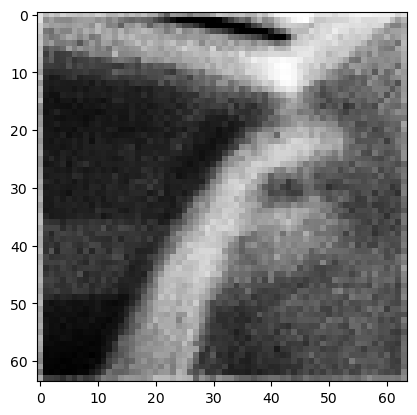

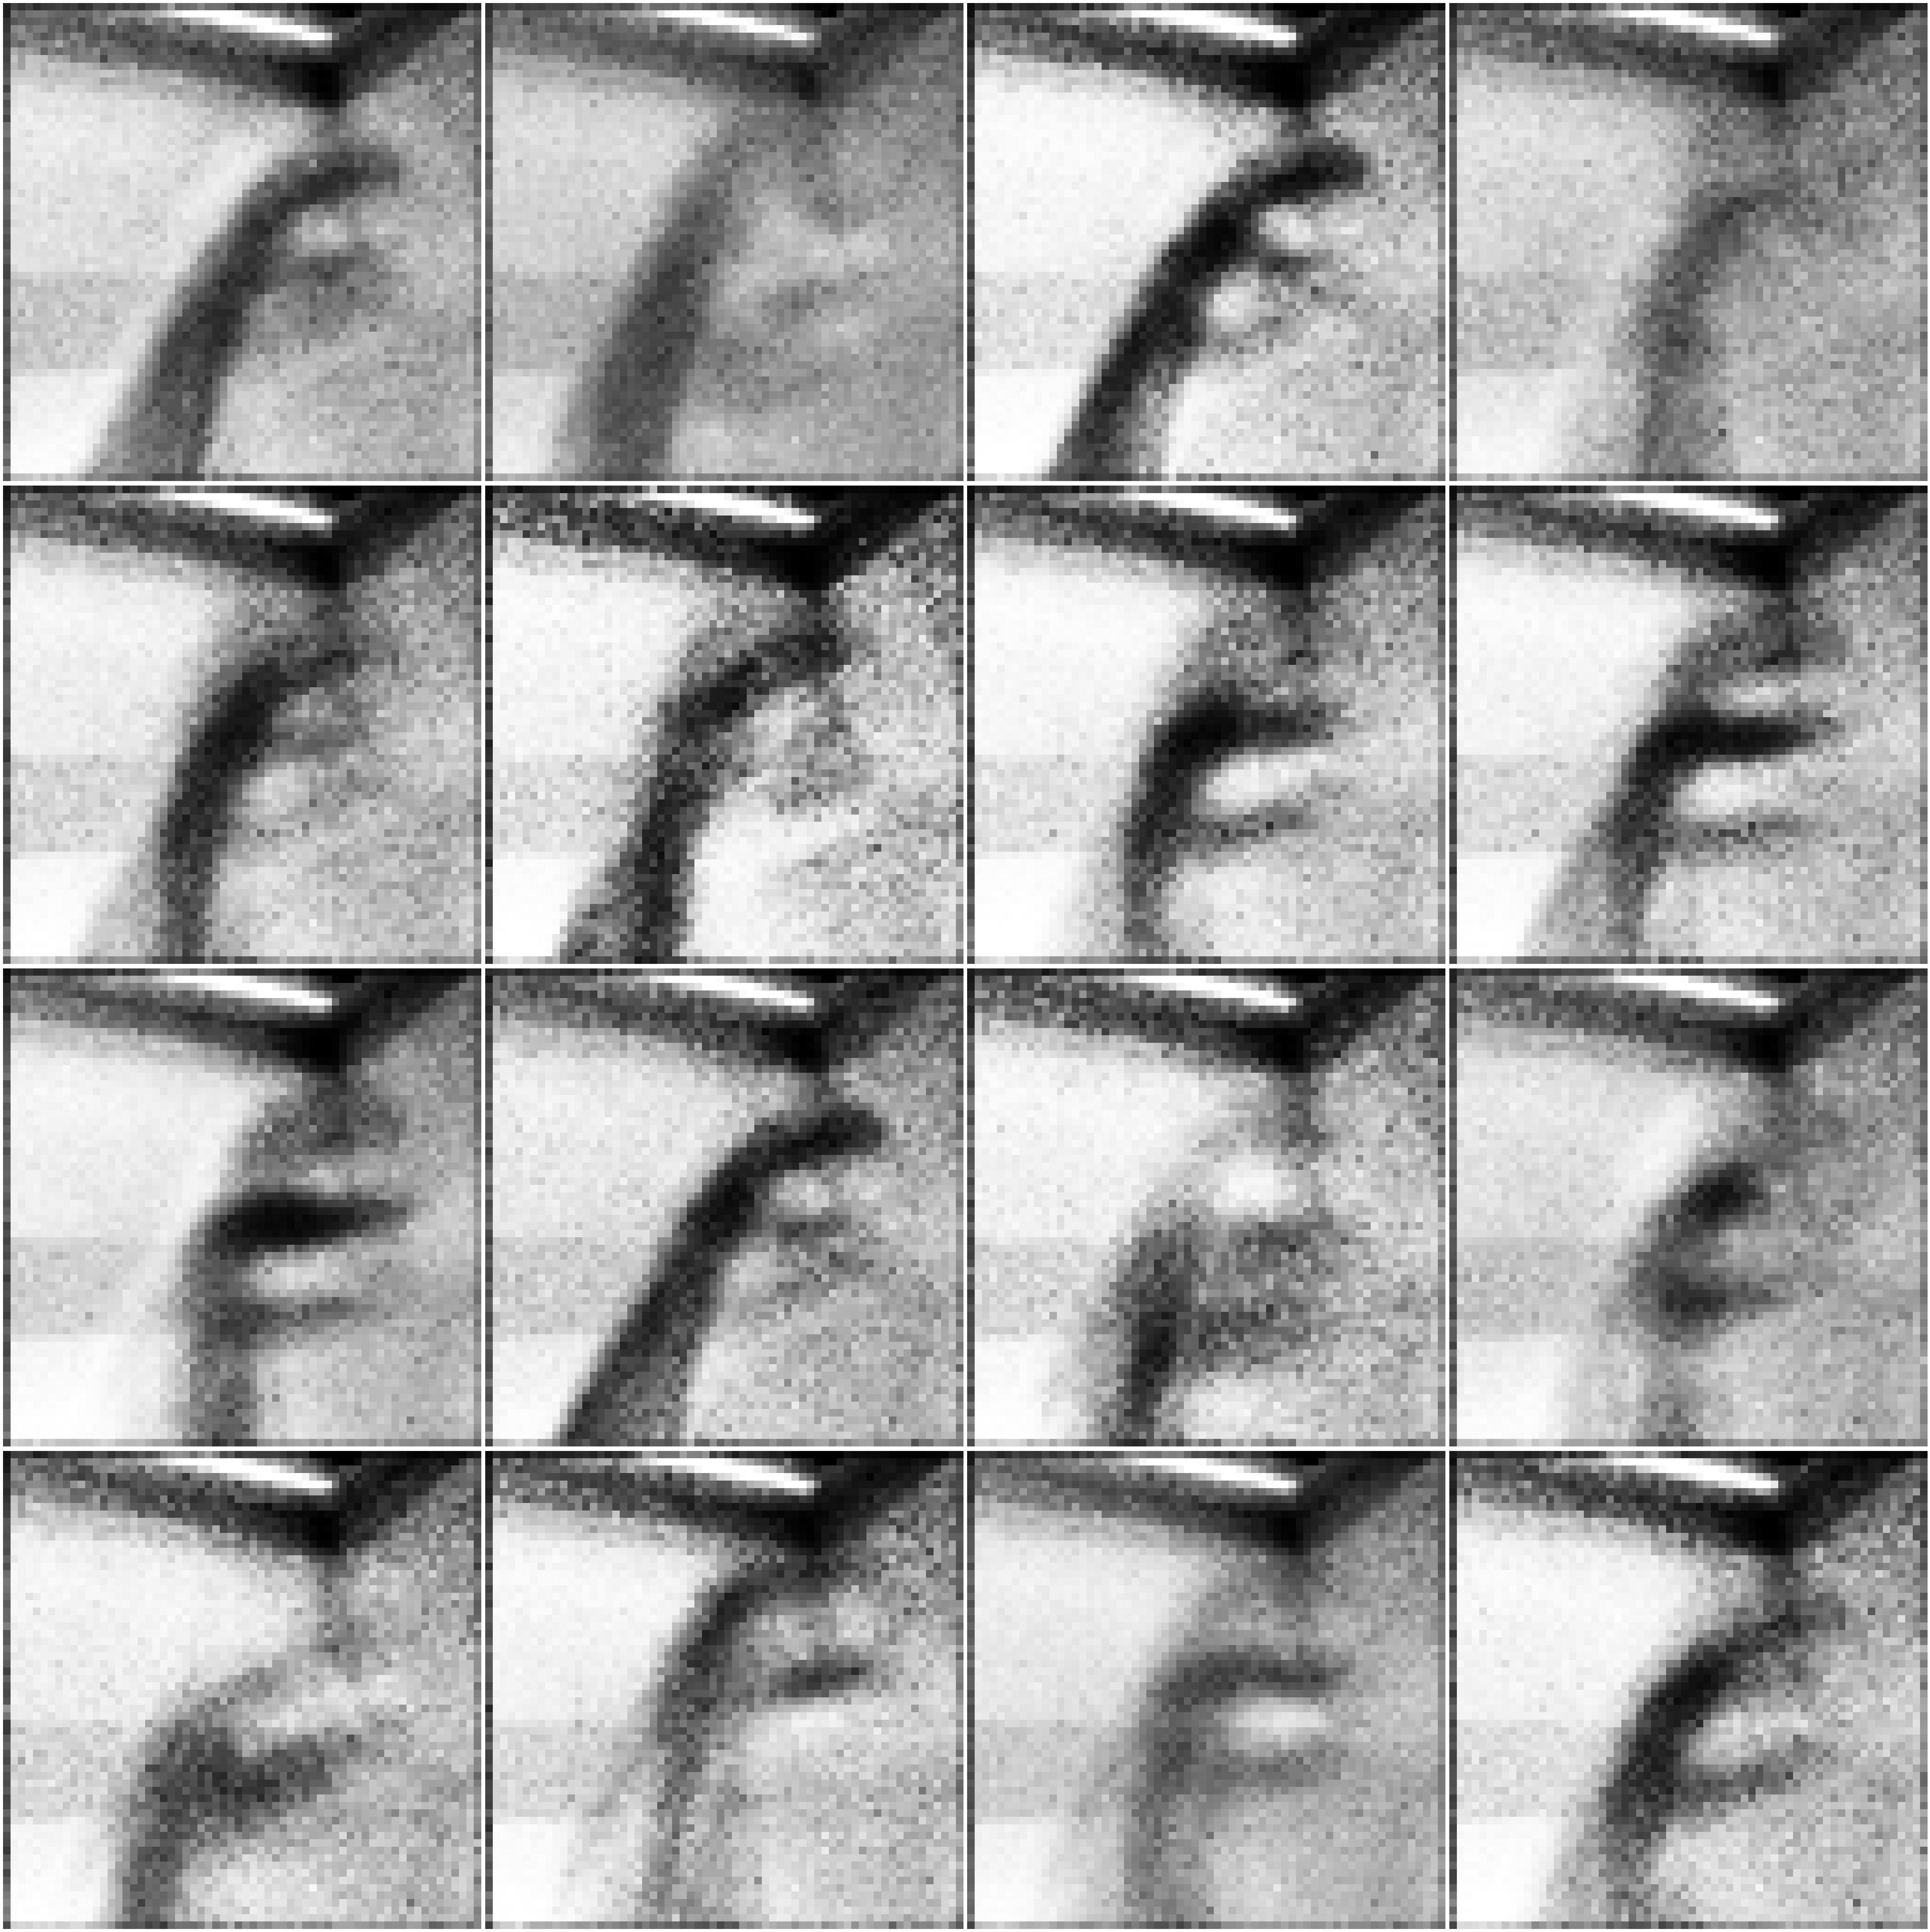

Currently trying combinations:
lr: 0.0005, batch_size: 16, epochs: 50, dropout: 0.3
Completed Epoch 1/50, Epoch Duration: 6.70s, Total Loss D.: 1.9823, Total Loss G.: 1.5505
Completed Epoch 2/50, Epoch Duration: 7.22s, Total Loss D.: 1.3054, Total Loss G.: 3.8742
Completed Epoch 3/50, Epoch Duration: 7.14s, Total Loss D.: 0.7951, Total Loss G.: 0.5598
Completed Epoch 4/50, Epoch Duration: 7.38s, Total Loss D.: 0.3813, Total Loss G.: 1.2005
Completed Epoch 5/50, Epoch Duration: 6.74s, Total Loss D.: 0.3410, Total Loss G.: 0.7633
Completed Epoch 6/50, Epoch Duration: 6.86s, Total Loss D.: 1.2414, Total Loss G.: 2.4102
Completed Epoch 7/50, Epoch Duration: 6.90s, Total Loss D.: 0.1920, Total Loss G.: 1.4124
Completed Epoch 8/50, Epoch Duration: 6.81s, Total Loss D.: 1.9731, Total Loss G.: 2.1866
Completed Epoch 9/50, Epoch Duration: 6.76s, Total Loss D.: 7.5262, Total Loss G.: 0.8638
Completed Epoch 10/50, Epoch Duration: 6.81s, Total Loss D.: 0.9136, Total Loss G.: 1.3882
Completed Epoch

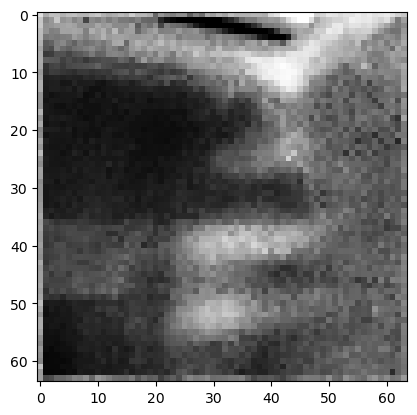

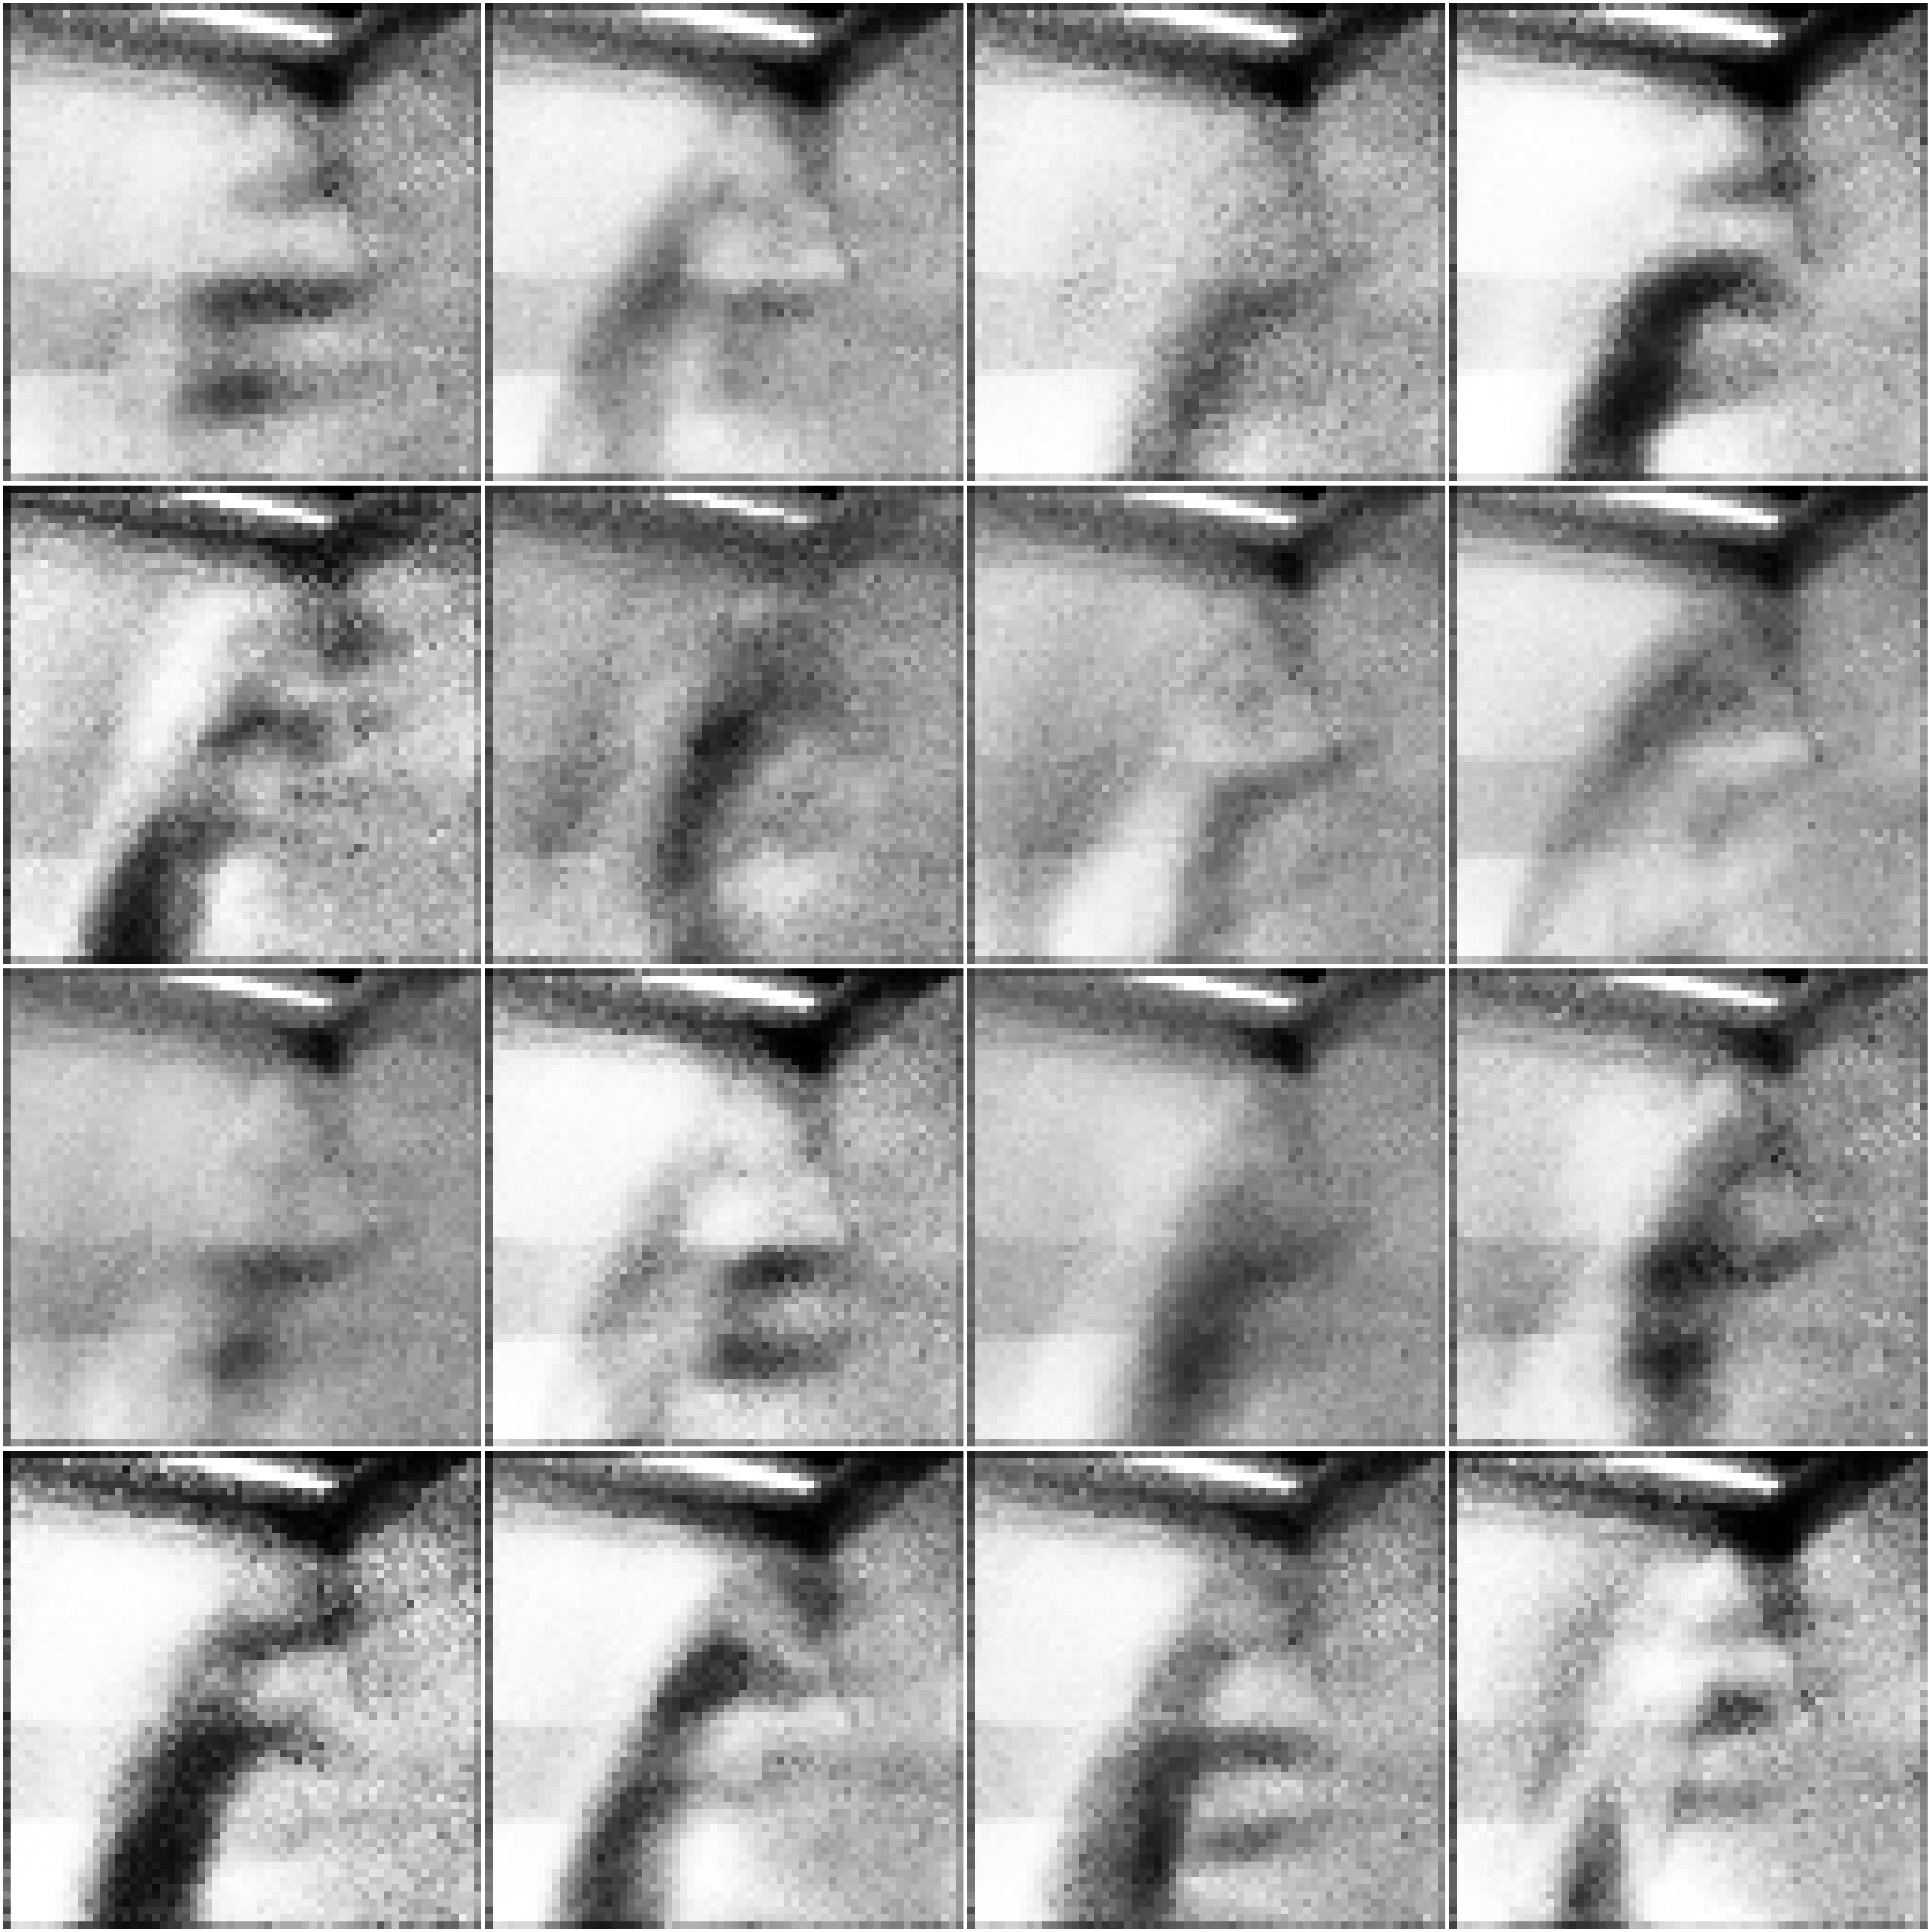

Currently trying combinations:
lr: 0.0005, batch_size: 16, epochs: 50, dropout: 0.5
Completed Epoch 1/50, Epoch Duration: 6.82s, Total Loss D.: 0.5613, Total Loss G.: 5.2072
Completed Epoch 2/50, Epoch Duration: 6.79s, Total Loss D.: 4.9994, Total Loss G.: 2.1687
Completed Epoch 3/50, Epoch Duration: 6.86s, Total Loss D.: 2.6630, Total Loss G.: 2.0707
Completed Epoch 4/50, Epoch Duration: 6.83s, Total Loss D.: 0.2379, Total Loss G.: 0.9187
Completed Epoch 5/50, Epoch Duration: 6.83s, Total Loss D.: 0.2764, Total Loss G.: 1.1239
Completed Epoch 6/50, Epoch Duration: 6.84s, Total Loss D.: 0.2503, Total Loss G.: 1.9222
Completed Epoch 7/50, Epoch Duration: 6.81s, Total Loss D.: 0.1793, Total Loss G.: 2.3032
Completed Epoch 8/50, Epoch Duration: 6.86s, Total Loss D.: 0.2933, Total Loss G.: 1.3660
Completed Epoch 9/50, Epoch Duration: 6.82s, Total Loss D.: 0.1070, Total Loss G.: 2.2537
Completed Epoch 10/50, Epoch Duration: 6.86s, Total Loss D.: 0.2099, Total Loss G.: 1.2619
Completed Epoch

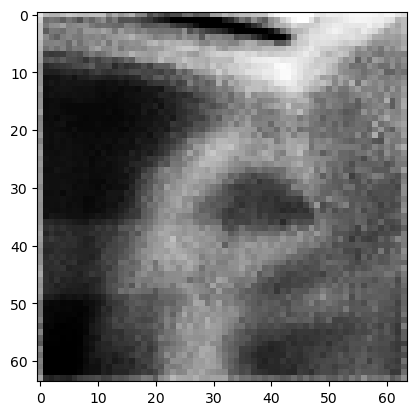

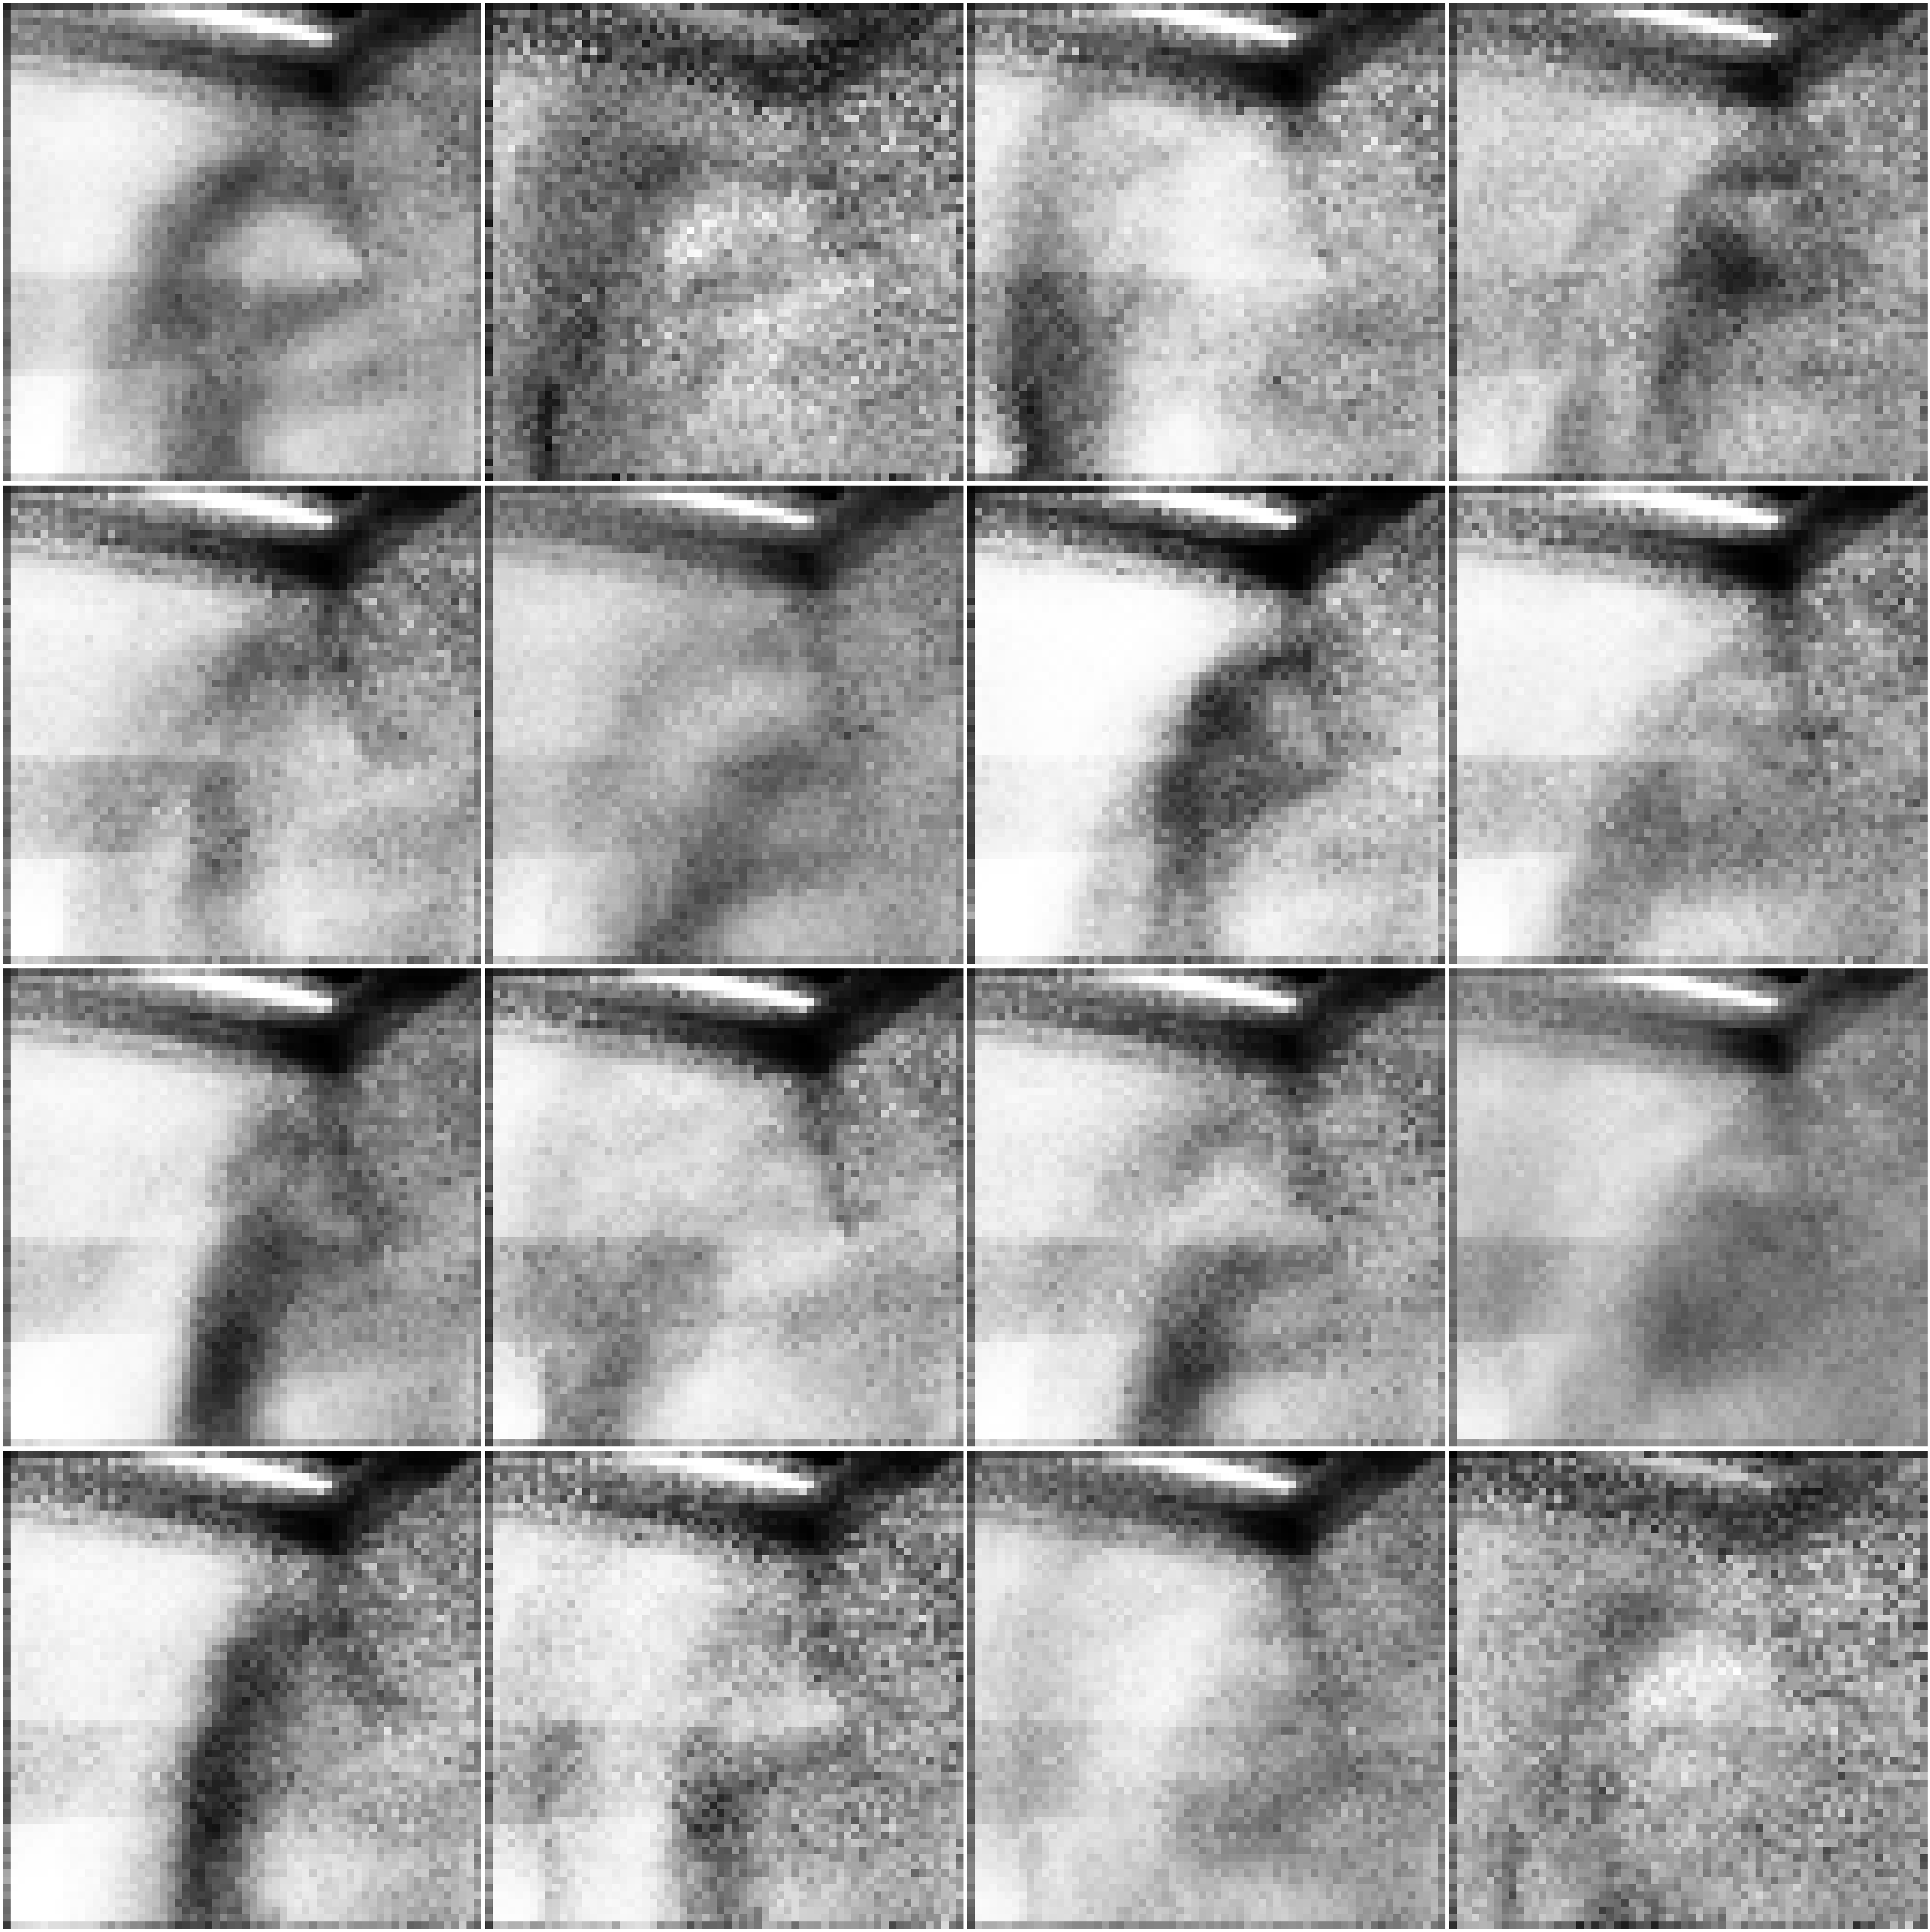

Currently trying combinations:
lr: 0.0005, batch_size: 16, epochs: 100, dropout: 0.3
Completed Epoch 1/100, Epoch Duration: 7.18s, Total Loss D.: 1.0988, Total Loss G.: 1.9386
Completed Epoch 2/100, Epoch Duration: 7.32s, Total Loss D.: 0.0920, Total Loss G.: 2.4785
Completed Epoch 3/100, Epoch Duration: 7.10s, Total Loss D.: 0.4084, Total Loss G.: 1.1244
Completed Epoch 4/100, Epoch Duration: 7.03s, Total Loss D.: 0.4309, Total Loss G.: 1.2789
Completed Epoch 5/100, Epoch Duration: 6.91s, Total Loss D.: 0.3955, Total Loss G.: 0.9554
Completed Epoch 6/100, Epoch Duration: 6.96s, Total Loss D.: 0.3586, Total Loss G.: 1.3268
Completed Epoch 7/100, Epoch Duration: 6.98s, Total Loss D.: 1.1097, Total Loss G.: 1.3268
Completed Epoch 8/100, Epoch Duration: 6.99s, Total Loss D.: 0.2375, Total Loss G.: 1.3361
Completed Epoch 9/100, Epoch Duration: 6.99s, Total Loss D.: 0.1263, Total Loss G.: 2.7123
Completed Epoch 10/100, Epoch Duration: 7.15s, Total Loss D.: 0.2493, Total Loss G.: 1.2178
Comp

Completed Epoch 90/100, Epoch Duration: 6.95s, Total Loss D.: 0.1342, Total Loss G.: 3.0047
Completed Epoch 91/100, Epoch Duration: 7.08s, Total Loss D.: 0.0607, Total Loss G.: 2.5358
Completed Epoch 92/100, Epoch Duration: 7.32s, Total Loss D.: 0.0453, Total Loss G.: 3.9624
Completed Epoch 93/100, Epoch Duration: 7.01s, Total Loss D.: 0.1099, Total Loss G.: 2.5769
Completed Epoch 94/100, Epoch Duration: 6.94s, Total Loss D.: 0.0235, Total Loss G.: 3.9478
Completed Epoch 95/100, Epoch Duration: 6.94s, Total Loss D.: 0.1062, Total Loss G.: 3.6714
Completed Epoch 96/100, Epoch Duration: 6.93s, Total Loss D.: 0.1034, Total Loss G.: 3.3040
Completed Epoch 97/100, Epoch Duration: 7.05s, Total Loss D.: 0.1443, Total Loss G.: 3.1162
Completed Epoch 98/100, Epoch Duration: 7.05s, Total Loss D.: 0.1502, Total Loss G.: 3.1152
Completed Epoch 99/100, Epoch Duration: 6.98s, Total Loss D.: 0.0628, Total Loss G.: 3.5928
Completed Epoch 100/100, Epoch Duration: 7.09s, Total Loss D.: 0.1791, Total Los

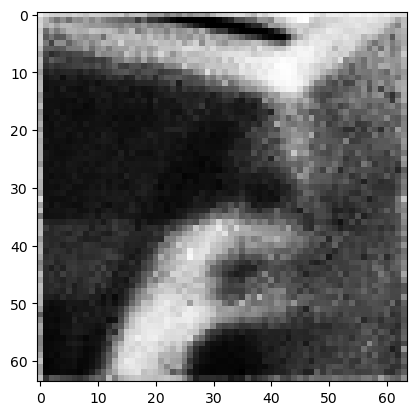

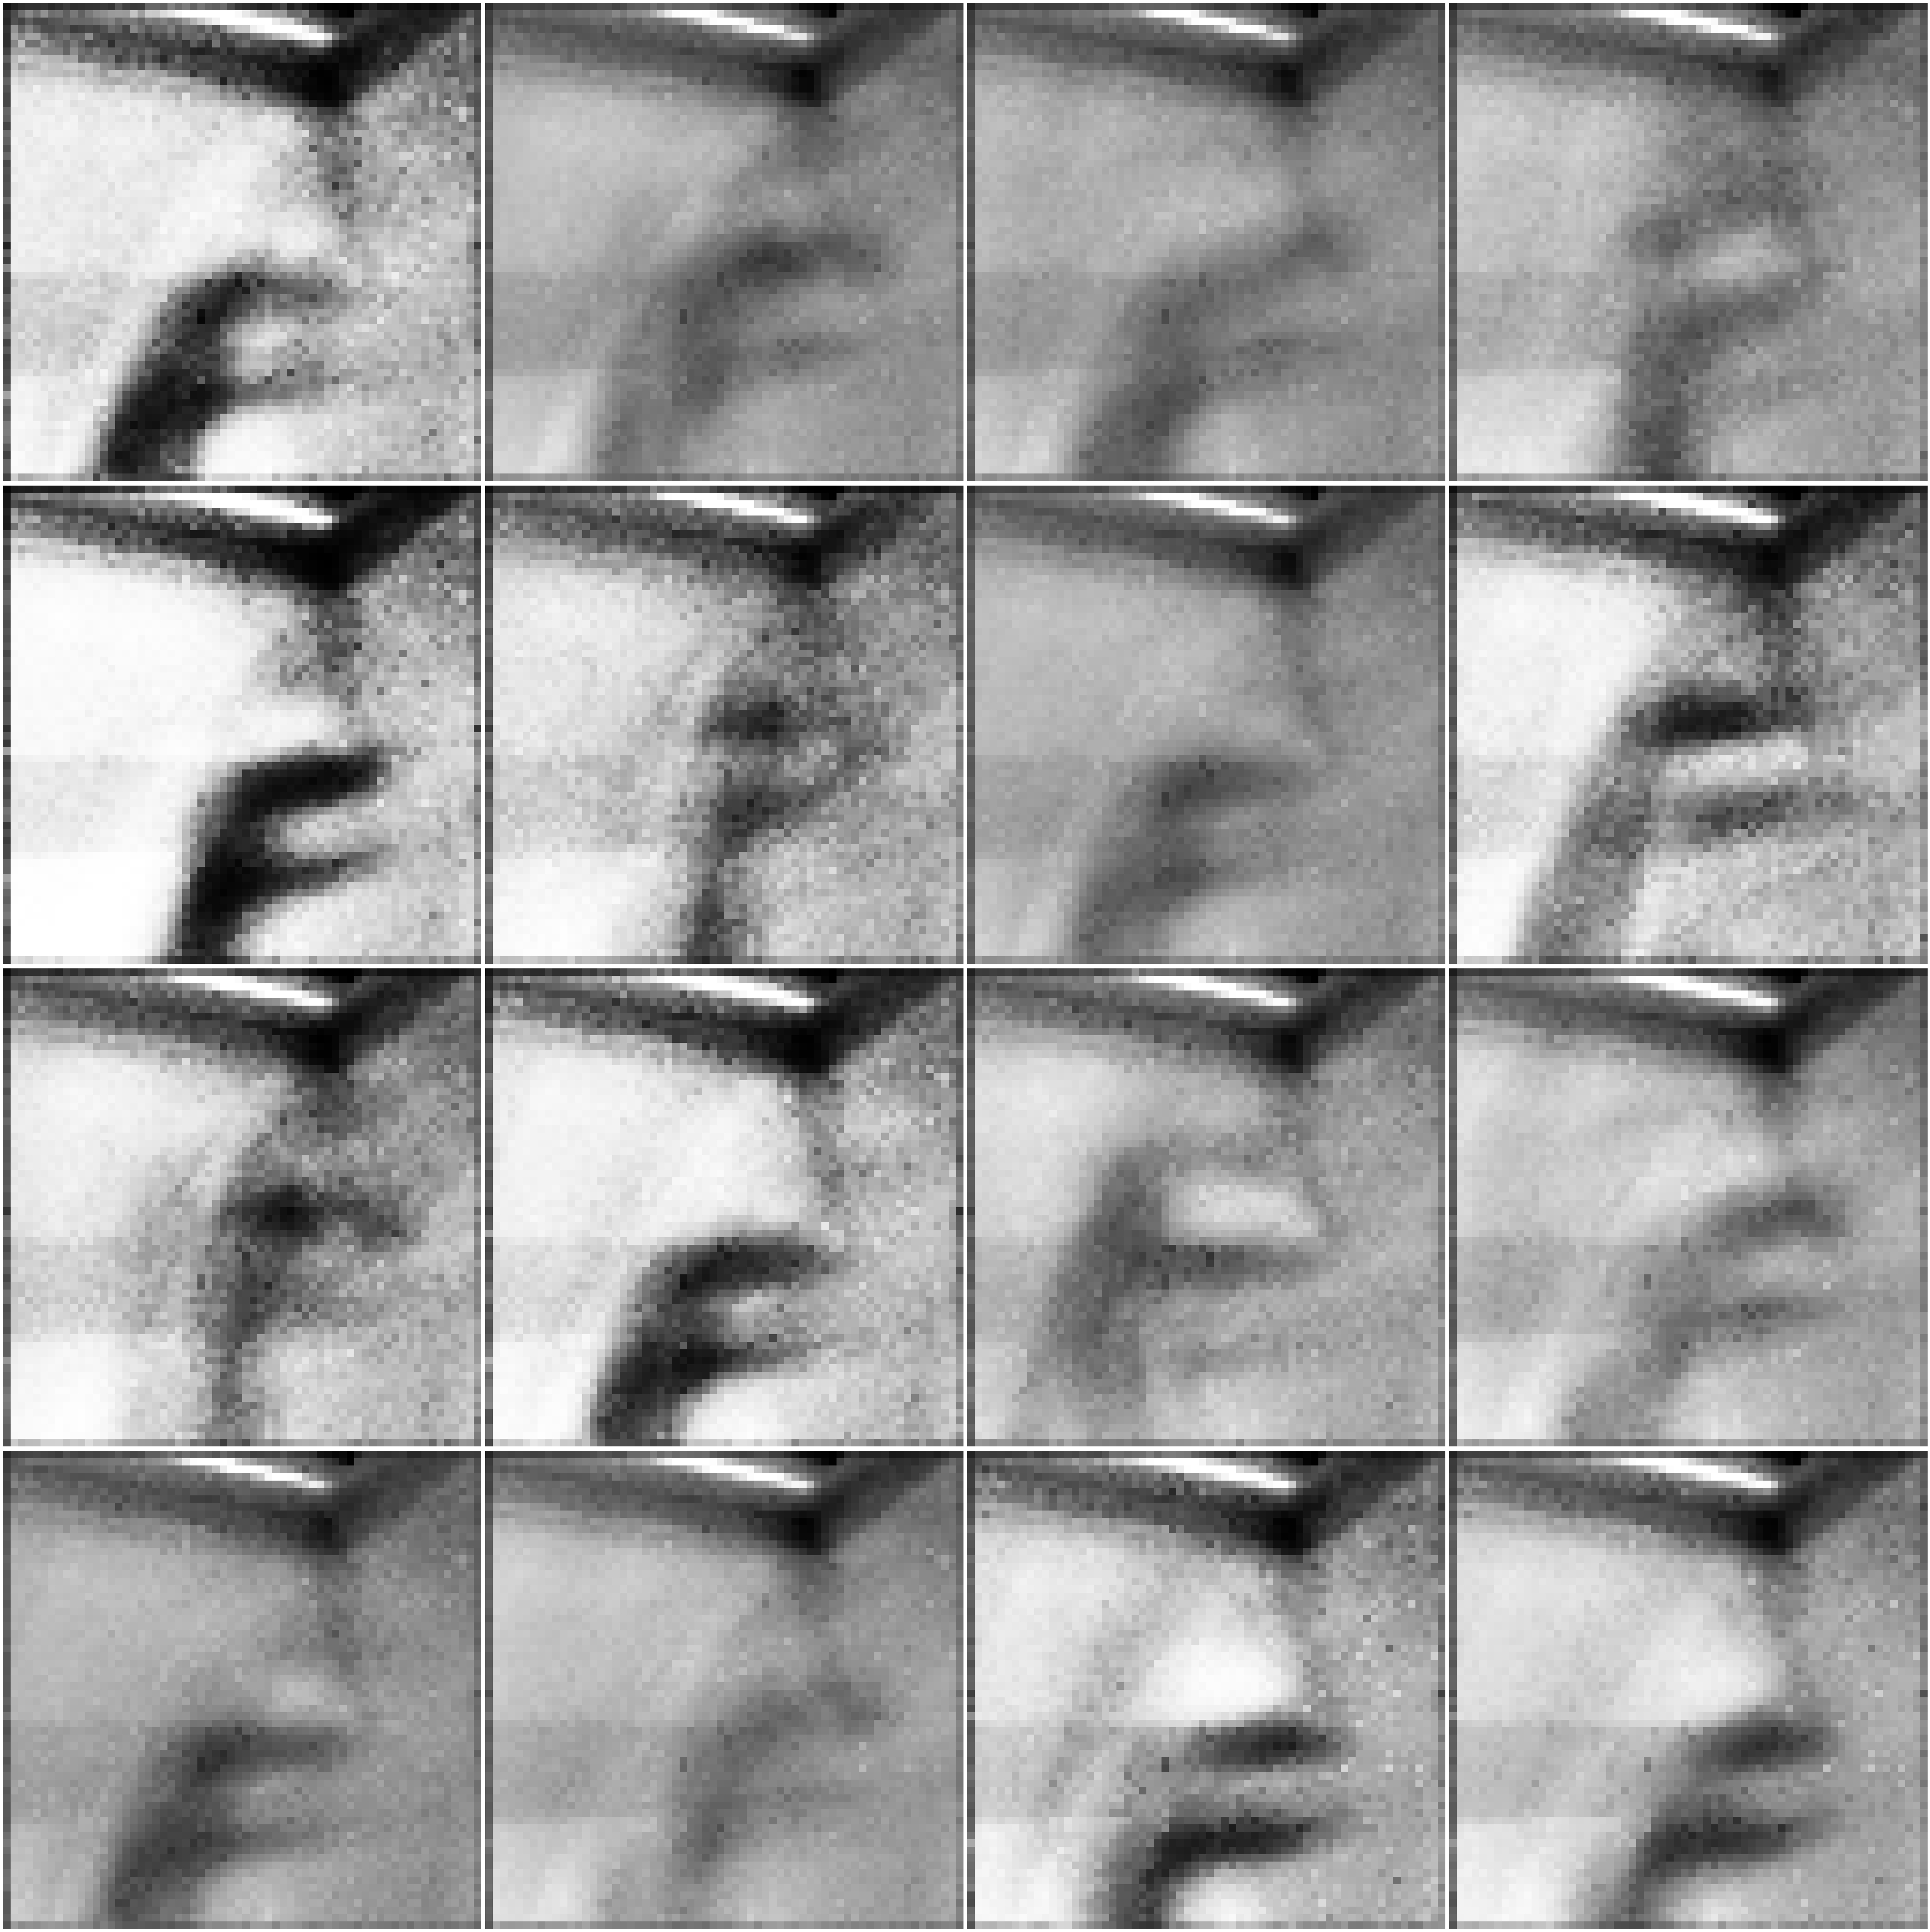

Currently trying combinations:
lr: 0.0005, batch_size: 16, epochs: 100, dropout: 0.5
Completed Epoch 1/100, Epoch Duration: 7.29s, Total Loss D.: 0.0047, Total Loss G.: 6.5161
Completed Epoch 2/100, Epoch Duration: 7.22s, Total Loss D.: 0.1560, Total Loss G.: 14.4599
Completed Epoch 3/100, Epoch Duration: 7.28s, Total Loss D.: 6.9843, Total Loss G.: 9.4242
Completed Epoch 4/100, Epoch Duration: 6.99s, Total Loss D.: 25.5927, Total Loss G.: 5.4352
Completed Epoch 5/100, Epoch Duration: 7.00s, Total Loss D.: 29.5019, Total Loss G.: 0.4708
Completed Epoch 6/100, Epoch Duration: 7.10s, Total Loss D.: 0.4782, Total Loss G.: 0.7217
Completed Epoch 7/100, Epoch Duration: 6.91s, Total Loss D.: 0.4602, Total Loss G.: 1.2606
Completed Epoch 8/100, Epoch Duration: 6.95s, Total Loss D.: 0.4786, Total Loss G.: 0.8996
Completed Epoch 9/100, Epoch Duration: 6.88s, Total Loss D.: 0.4627, Total Loss G.: 0.8894
Completed Epoch 10/100, Epoch Duration: 7.04s, Total Loss D.: 0.6157, Total Loss G.: 0.9239
C

Completed Epoch 90/100, Epoch Duration: 6.94s, Total Loss D.: 0.2413, Total Loss G.: 2.8681
Completed Epoch 91/100, Epoch Duration: 6.99s, Total Loss D.: 0.0904, Total Loss G.: 2.9307
Completed Epoch 92/100, Epoch Duration: 7.05s, Total Loss D.: 0.1075, Total Loss G.: 2.7493
Completed Epoch 93/100, Epoch Duration: 6.99s, Total Loss D.: 0.2494, Total Loss G.: 3.1125
Completed Epoch 94/100, Epoch Duration: 6.92s, Total Loss D.: 0.0406, Total Loss G.: 4.1746
Completed Epoch 95/100, Epoch Duration: 7.04s, Total Loss D.: 0.0792, Total Loss G.: 3.4981
Completed Epoch 96/100, Epoch Duration: 6.98s, Total Loss D.: 0.2472, Total Loss G.: 3.6196
Completed Epoch 97/100, Epoch Duration: 7.02s, Total Loss D.: 0.1608, Total Loss G.: 2.9982
Completed Epoch 98/100, Epoch Duration: 6.91s, Total Loss D.: 0.0319, Total Loss G.: 3.2594
Completed Epoch 99/100, Epoch Duration: 7.21s, Total Loss D.: 0.0866, Total Loss G.: 3.4157
Completed Epoch 100/100, Epoch Duration: 7.31s, Total Loss D.: 0.0988, Total Los

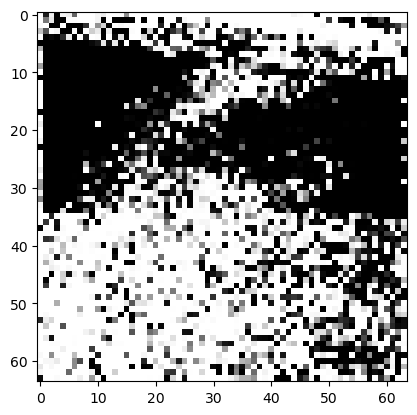

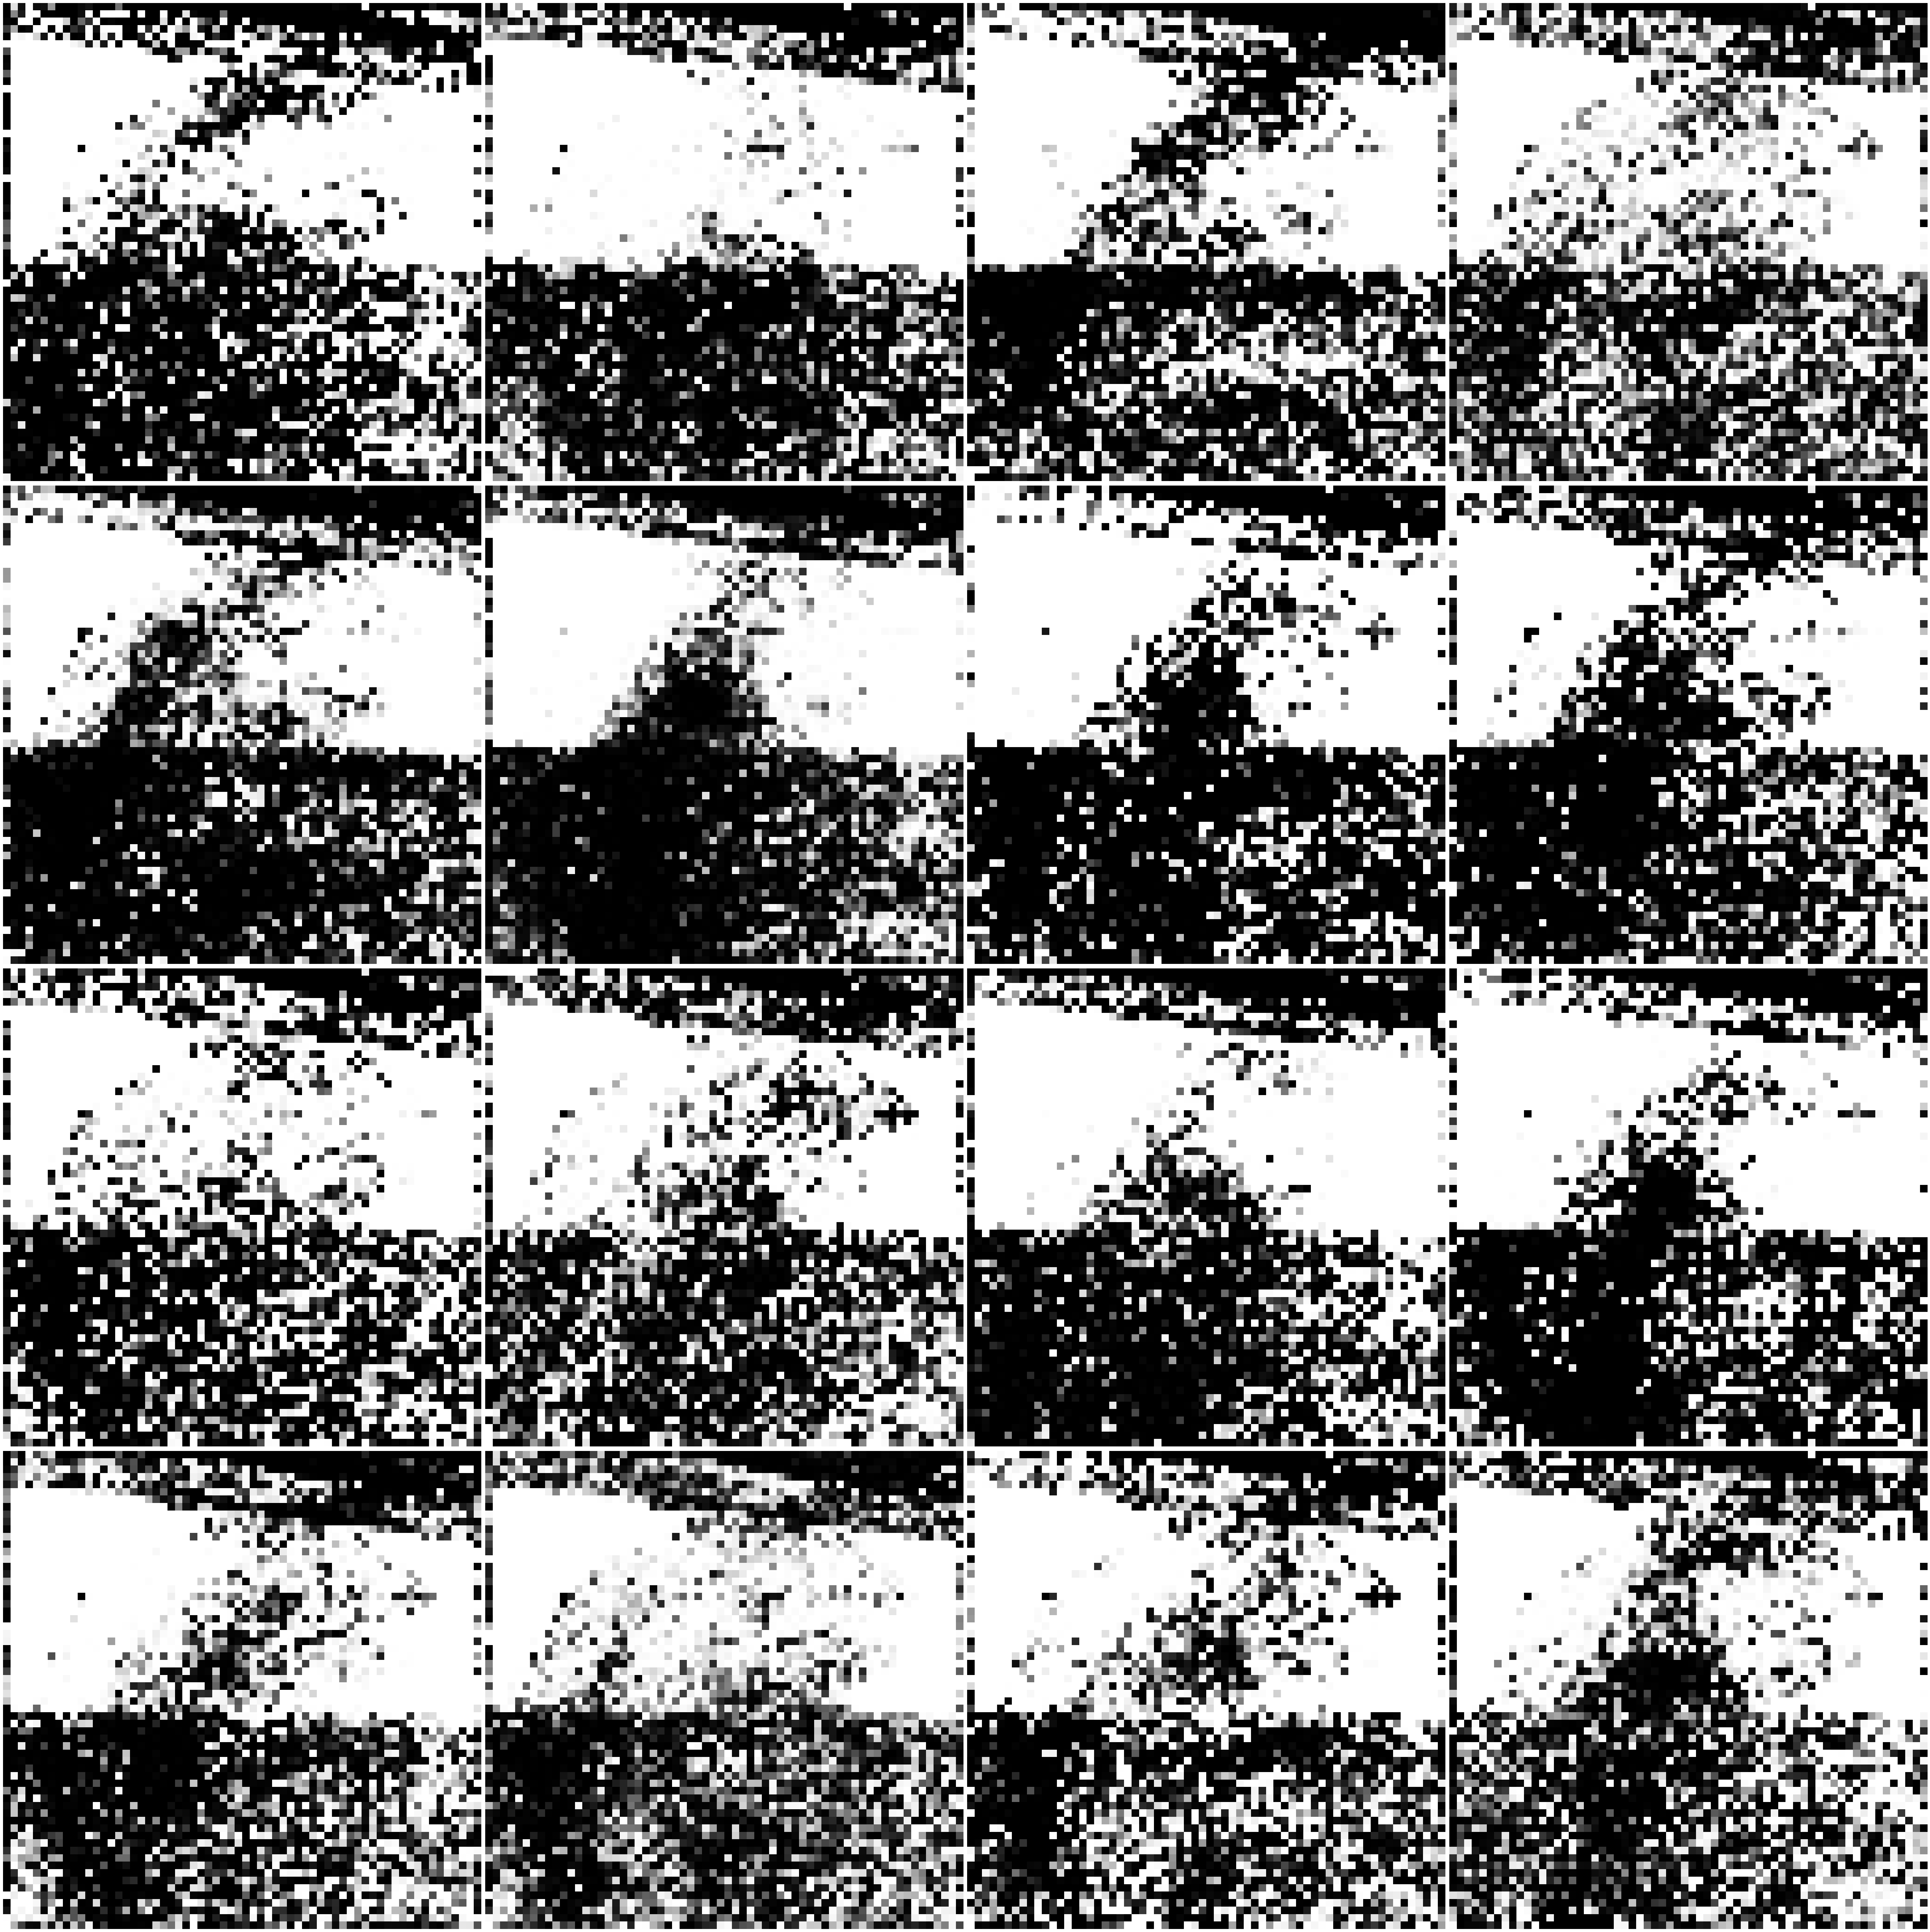

Currently trying combinations:
lr: 0.0005, batch_size: 32, epochs: 50, dropout: 0.3
Completed Epoch 1/50, Epoch Duration: 7.11s, Total Loss D.: 16.6039, Total Loss G.: 0.7606
Completed Epoch 2/50, Epoch Duration: 6.83s, Total Loss D.: 0.1566, Total Loss G.: 4.4755
Completed Epoch 3/50, Epoch Duration: 6.83s, Total Loss D.: 0.4547, Total Loss G.: 1.9786
Completed Epoch 4/50, Epoch Duration: 6.73s, Total Loss D.: 0.4663, Total Loss G.: 1.0513
Completed Epoch 5/50, Epoch Duration: 6.84s, Total Loss D.: 0.3778, Total Loss G.: 0.8205
Completed Epoch 6/50, Epoch Duration: 6.89s, Total Loss D.: 0.7708, Total Loss G.: 0.9876
Completed Epoch 7/50, Epoch Duration: 6.77s, Total Loss D.: 0.2702, Total Loss G.: 1.6526
Completed Epoch 8/50, Epoch Duration: 6.85s, Total Loss D.: 0.1885, Total Loss G.: 2.3449
Completed Epoch 9/50, Epoch Duration: 6.80s, Total Loss D.: 0.3784, Total Loss G.: 0.8454
Completed Epoch 10/50, Epoch Duration: 6.79s, Total Loss D.: 0.2806, Total Loss G.: 1.0257
Completed Epoc

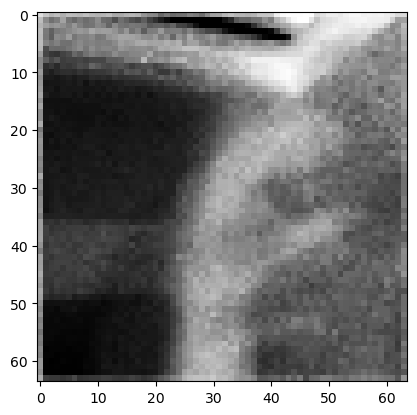

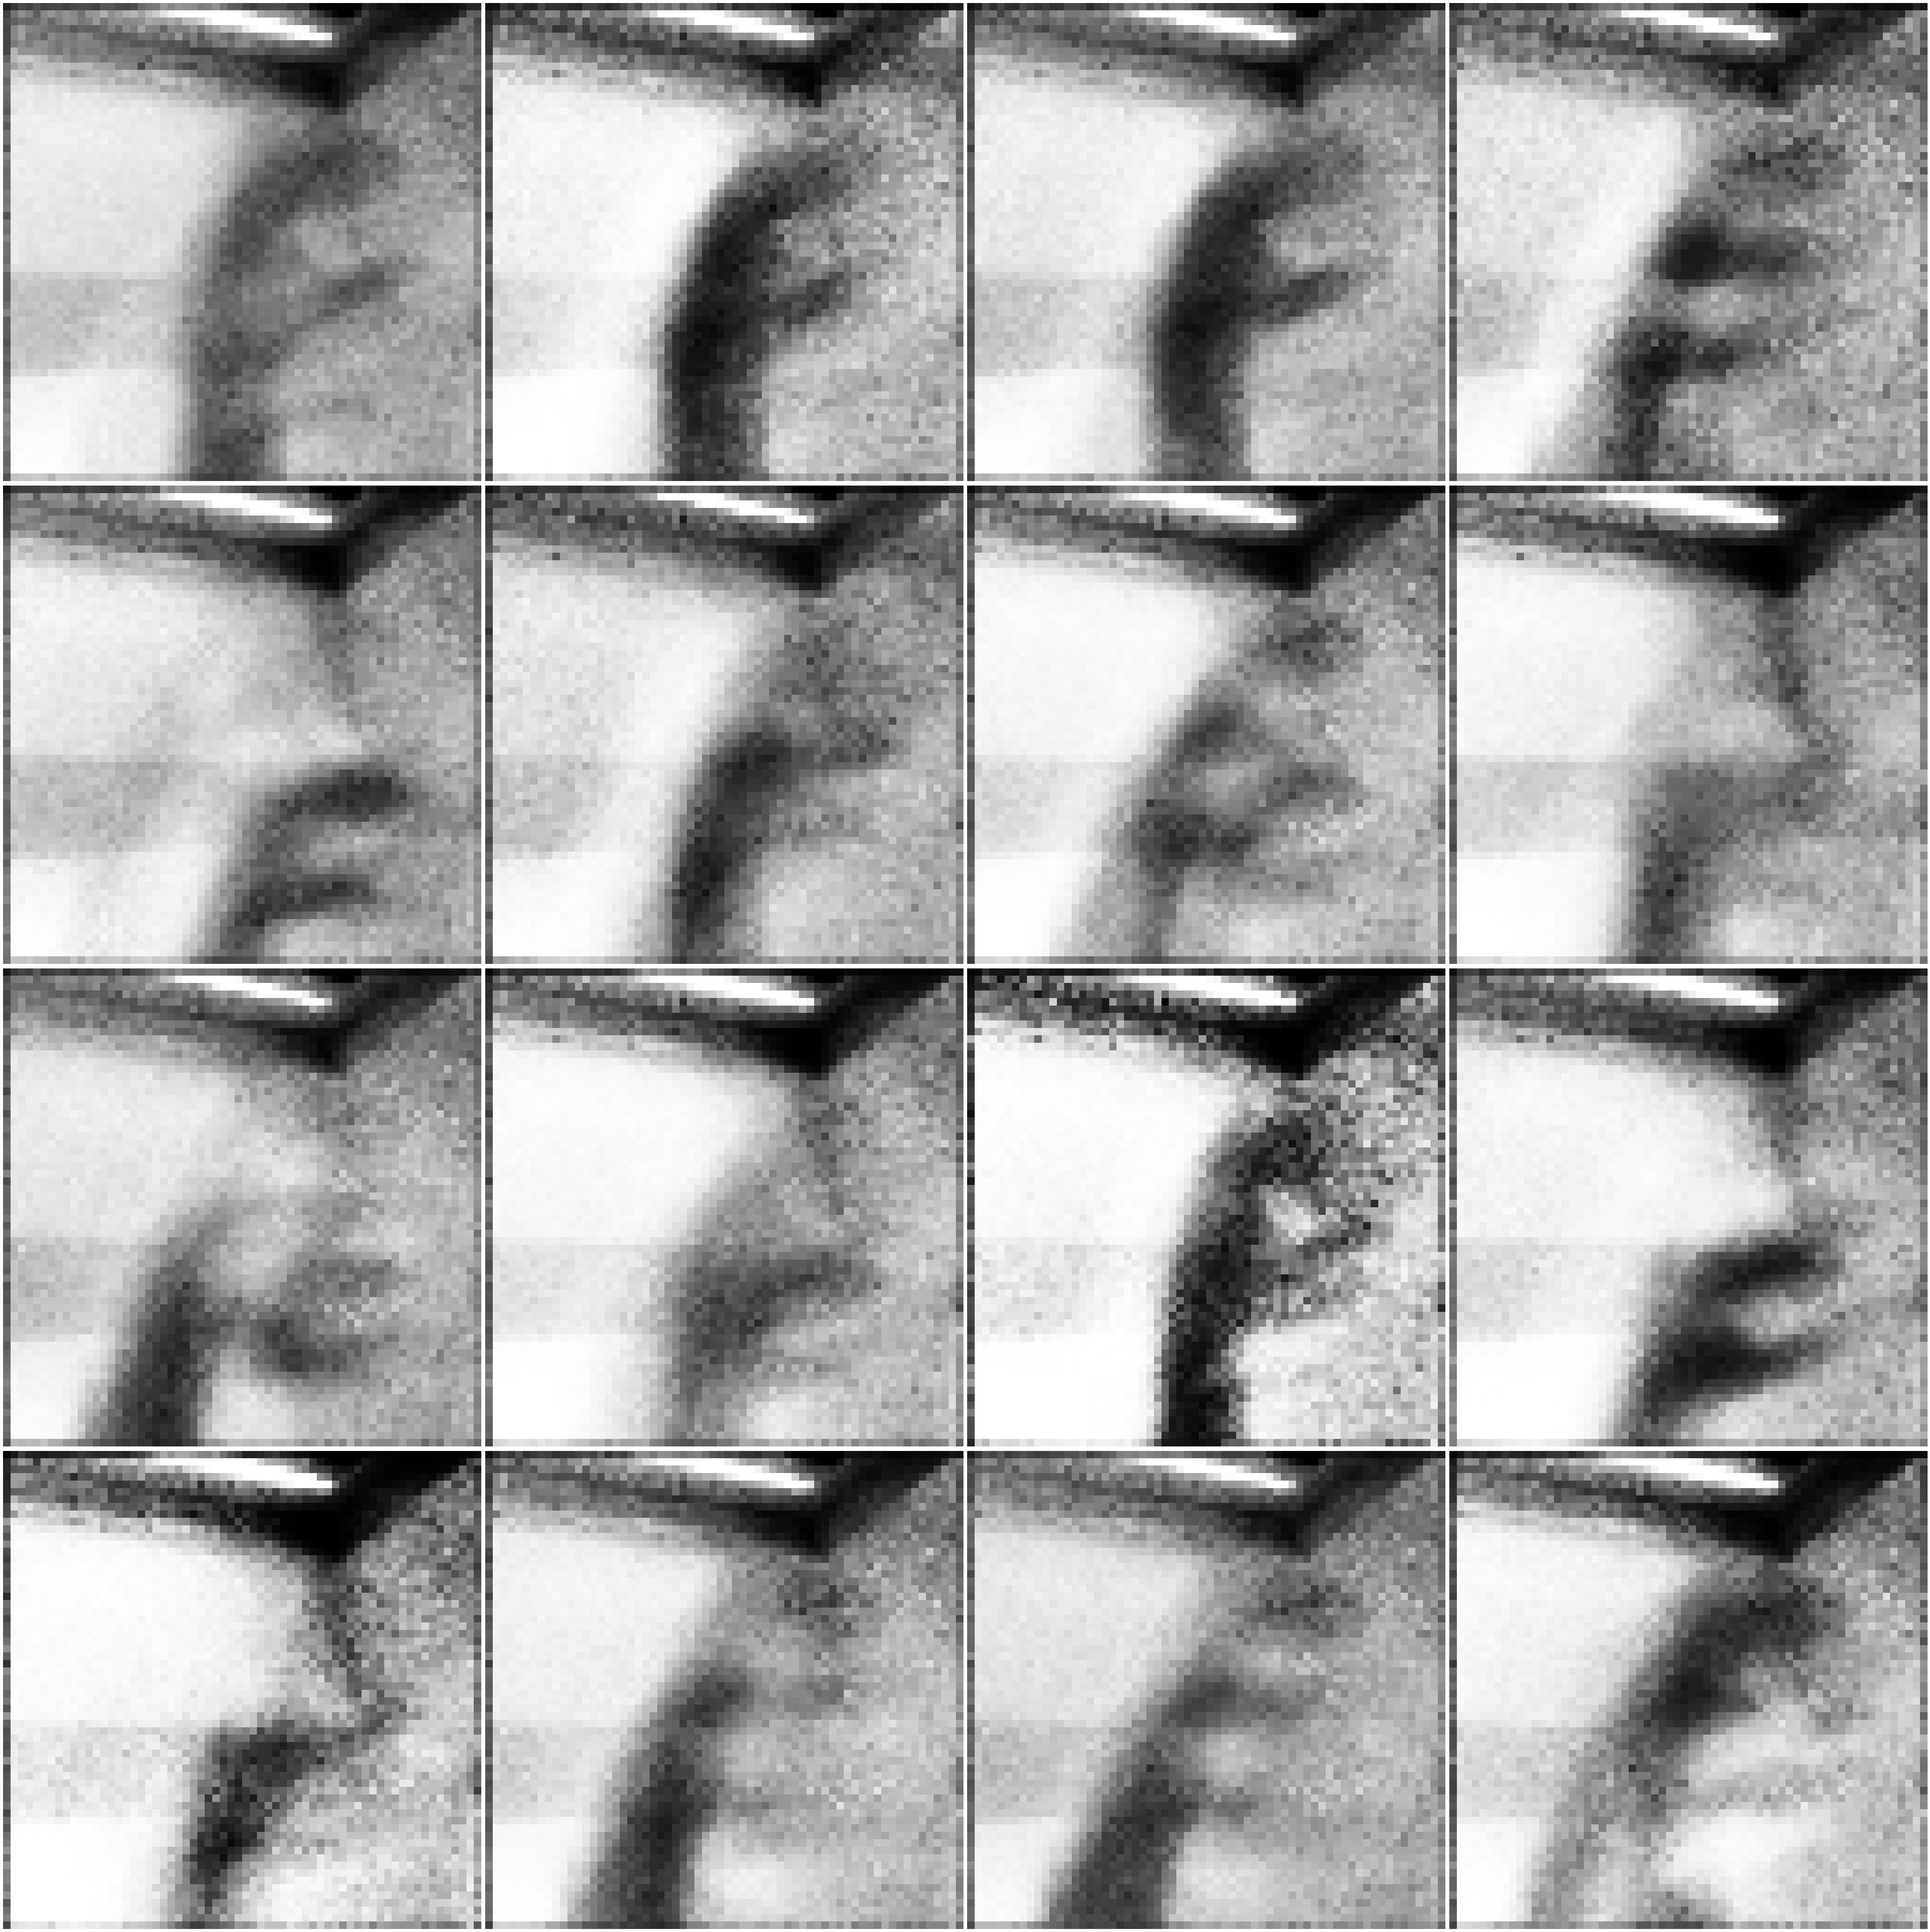

Currently trying combinations:
lr: 0.0005, batch_size: 32, epochs: 50, dropout: 0.5
Completed Epoch 1/50, Epoch Duration: 7.03s, Total Loss D.: 4.7205, Total Loss G.: 0.3222
Completed Epoch 2/50, Epoch Duration: 6.96s, Total Loss D.: 0.4687, Total Loss G.: 1.2404
Completed Epoch 3/50, Epoch Duration: 7.03s, Total Loss D.: 10.4425, Total Loss G.: 0.9329
Completed Epoch 4/50, Epoch Duration: 7.02s, Total Loss D.: 0.2874, Total Loss G.: 1.2028
Completed Epoch 5/50, Epoch Duration: 7.05s, Total Loss D.: 0.4955, Total Loss G.: 1.5343
Completed Epoch 6/50, Epoch Duration: 7.24s, Total Loss D.: 0.5197, Total Loss G.: 1.0720
Completed Epoch 7/50, Epoch Duration: 6.98s, Total Loss D.: 0.4702, Total Loss G.: 0.6165
Completed Epoch 8/50, Epoch Duration: 6.98s, Total Loss D.: 0.4307, Total Loss G.: 0.8602
Completed Epoch 9/50, Epoch Duration: 7.32s, Total Loss D.: 0.3946, Total Loss G.: 1.2402
Completed Epoch 10/50, Epoch Duration: 7.10s, Total Loss D.: 0.3062, Total Loss G.: 0.9368
Completed Epoc

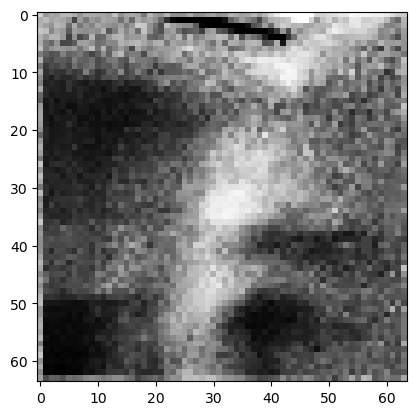

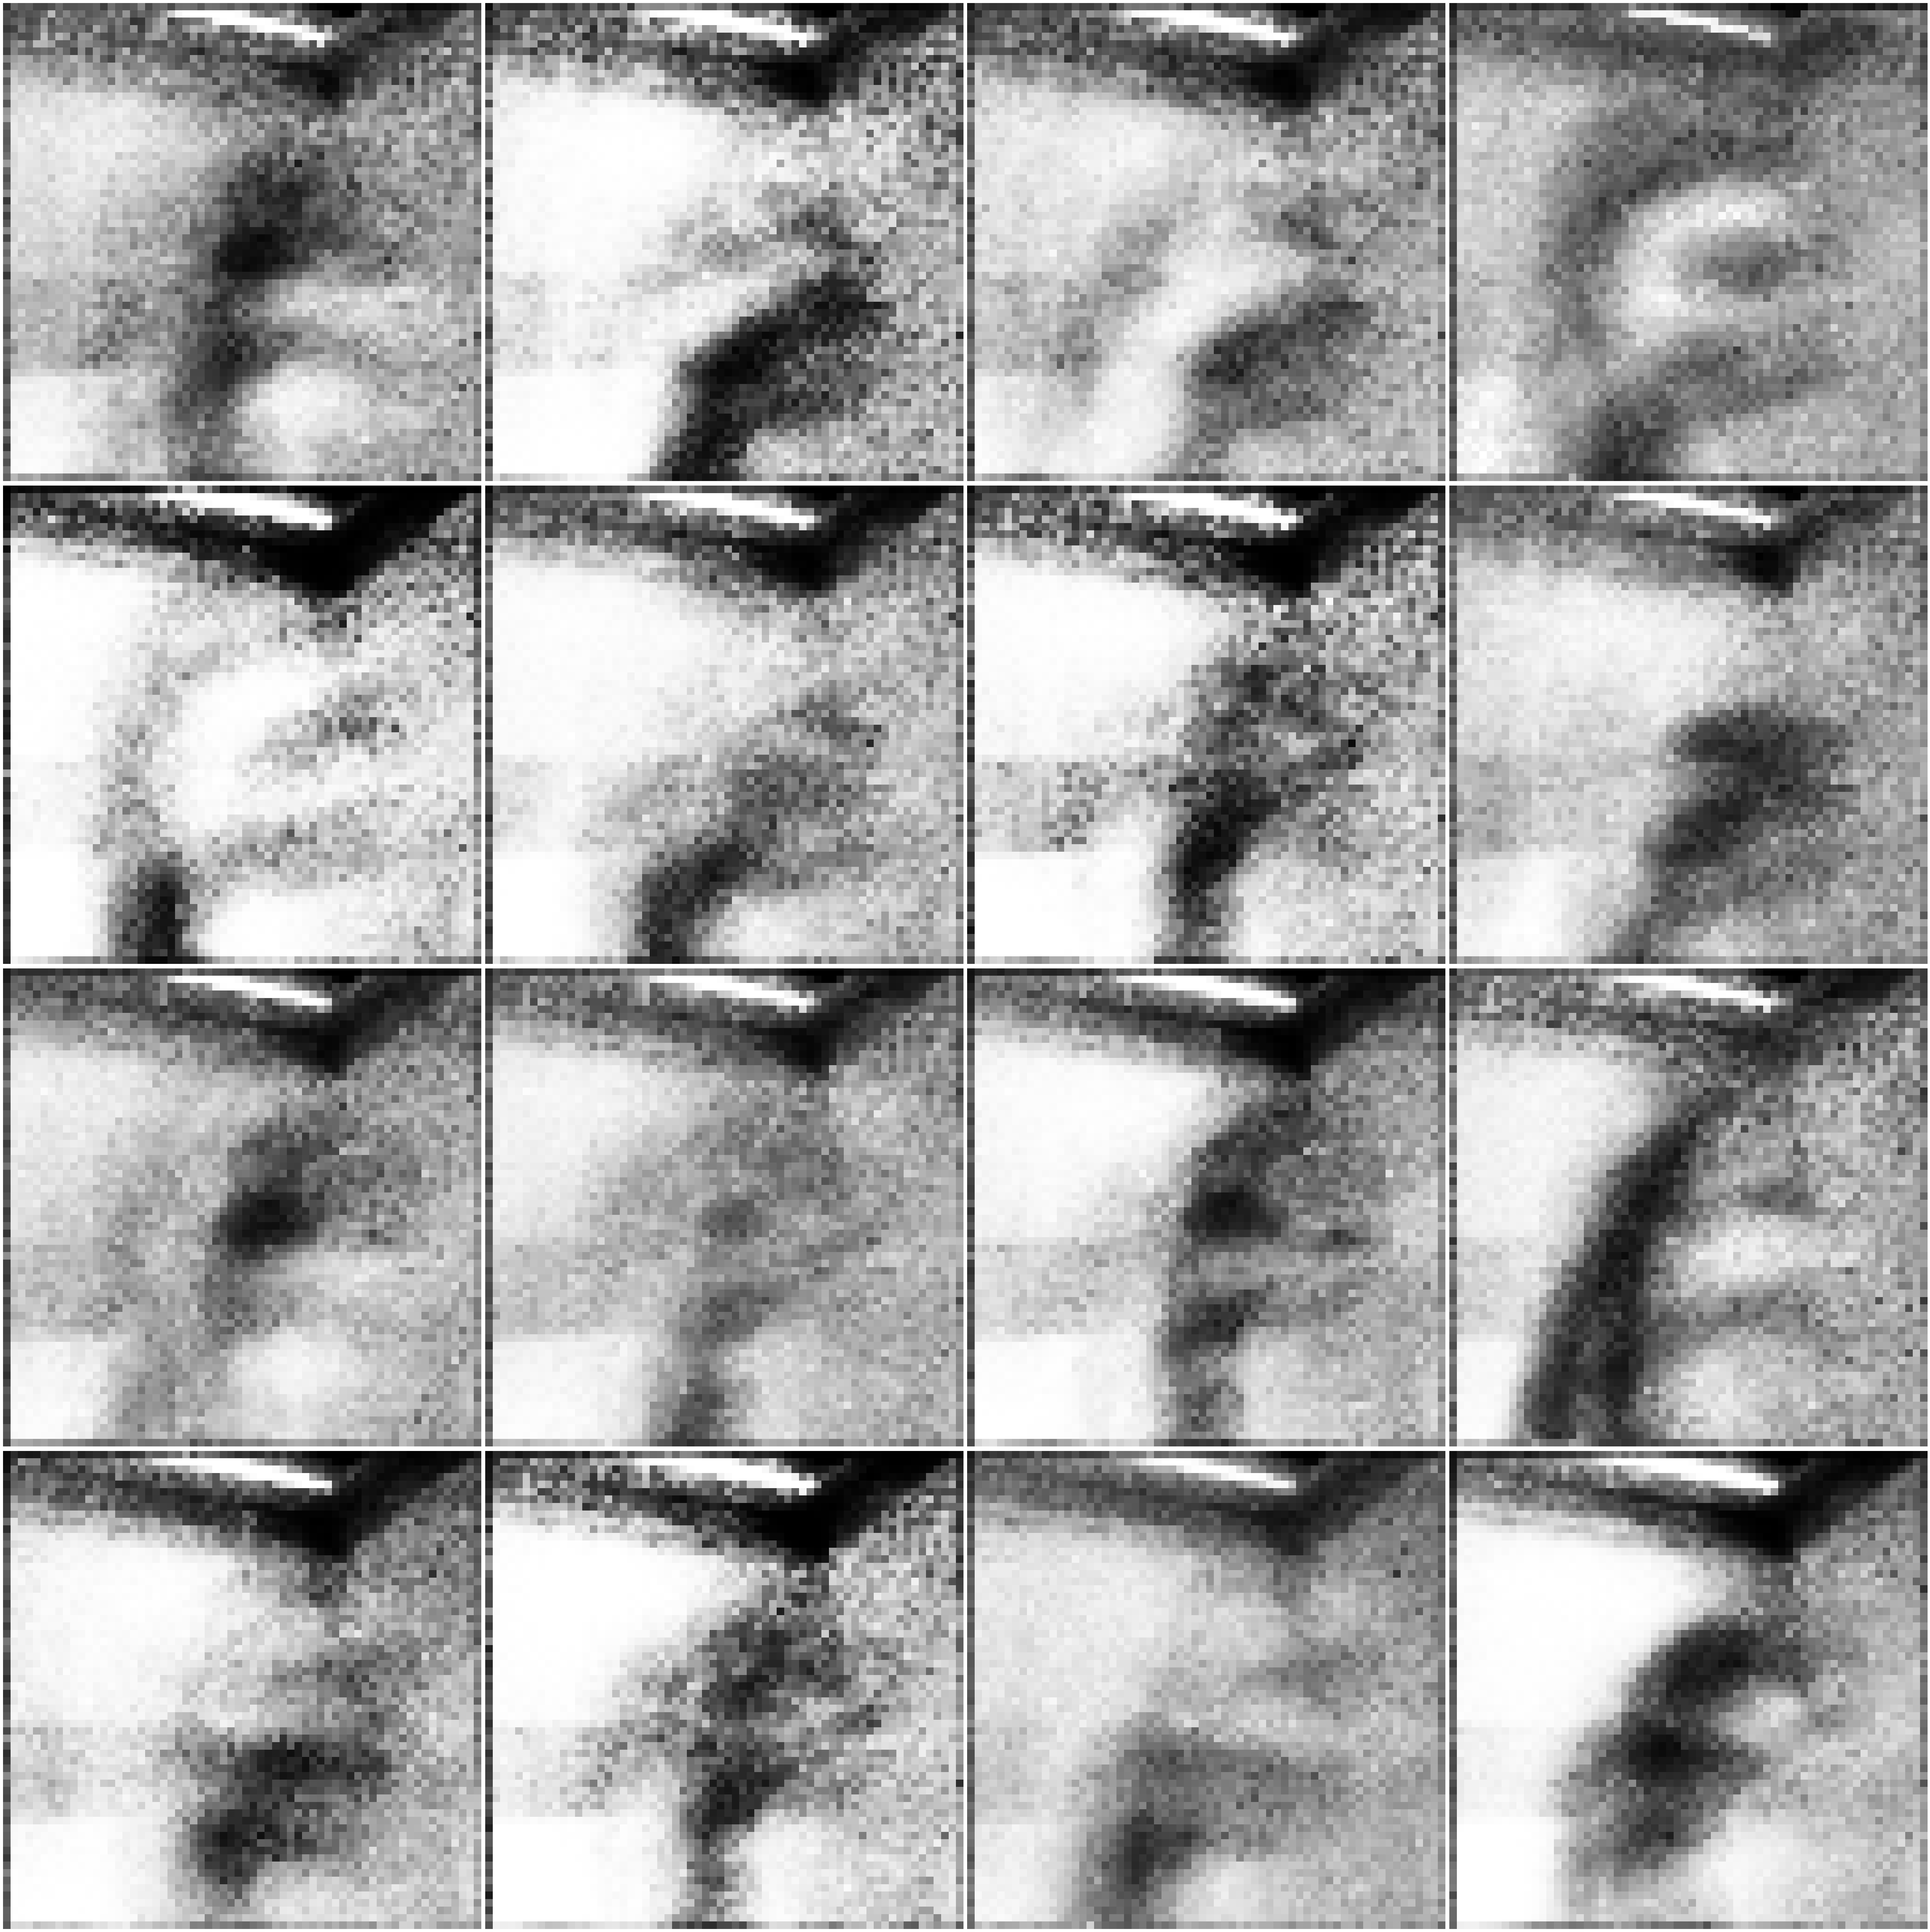

Currently trying combinations:
lr: 0.0005, batch_size: 32, epochs: 100, dropout: 0.3
Completed Epoch 1/100, Epoch Duration: 6.96s, Total Loss D.: 0.0557, Total Loss G.: 10.8832
Completed Epoch 2/100, Epoch Duration: 7.03s, Total Loss D.: 12.3785, Total Loss G.: 99.4562
Completed Epoch 3/100, Epoch Duration: 7.07s, Total Loss D.: 11.2290, Total Loss G.: 49.5685
Completed Epoch 4/100, Epoch Duration: 6.96s, Total Loss D.: 50.0440, Total Loss G.: 0.0000
Completed Epoch 5/100, Epoch Duration: 6.98s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 6/100, Epoch Duration: 7.06s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 7/100, Epoch Duration: 7.12s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 8/100, Epoch Duration: 7.10s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 9/100, Epoch Duration: 6.97s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 10/100, Epoch Duration: 6.99s, Total Loss D.: 50.0000, Total Loss G.:

Completed Epoch 89/100, Epoch Duration: 7.61s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 90/100, Epoch Duration: 7.21s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 91/100, Epoch Duration: 7.21s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 92/100, Epoch Duration: 6.93s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 93/100, Epoch Duration: 7.53s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 94/100, Epoch Duration: 6.87s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 95/100, Epoch Duration: 7.01s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 96/100, Epoch Duration: 7.08s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 97/100, Epoch Duration: 7.07s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 98/100, Epoch Duration: 7.34s, Total Loss D.: 50.0000, Total Loss G.: 0.0000
Completed Epoch 99/100, Epoch Duration: 6.97s, Total Loss D.: 50.0000,

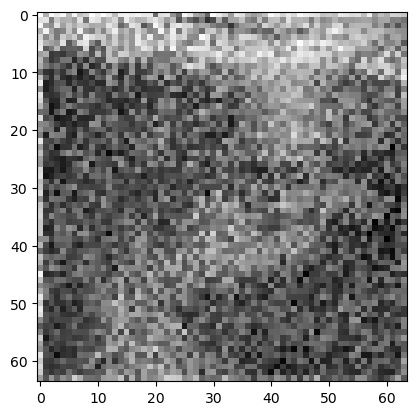

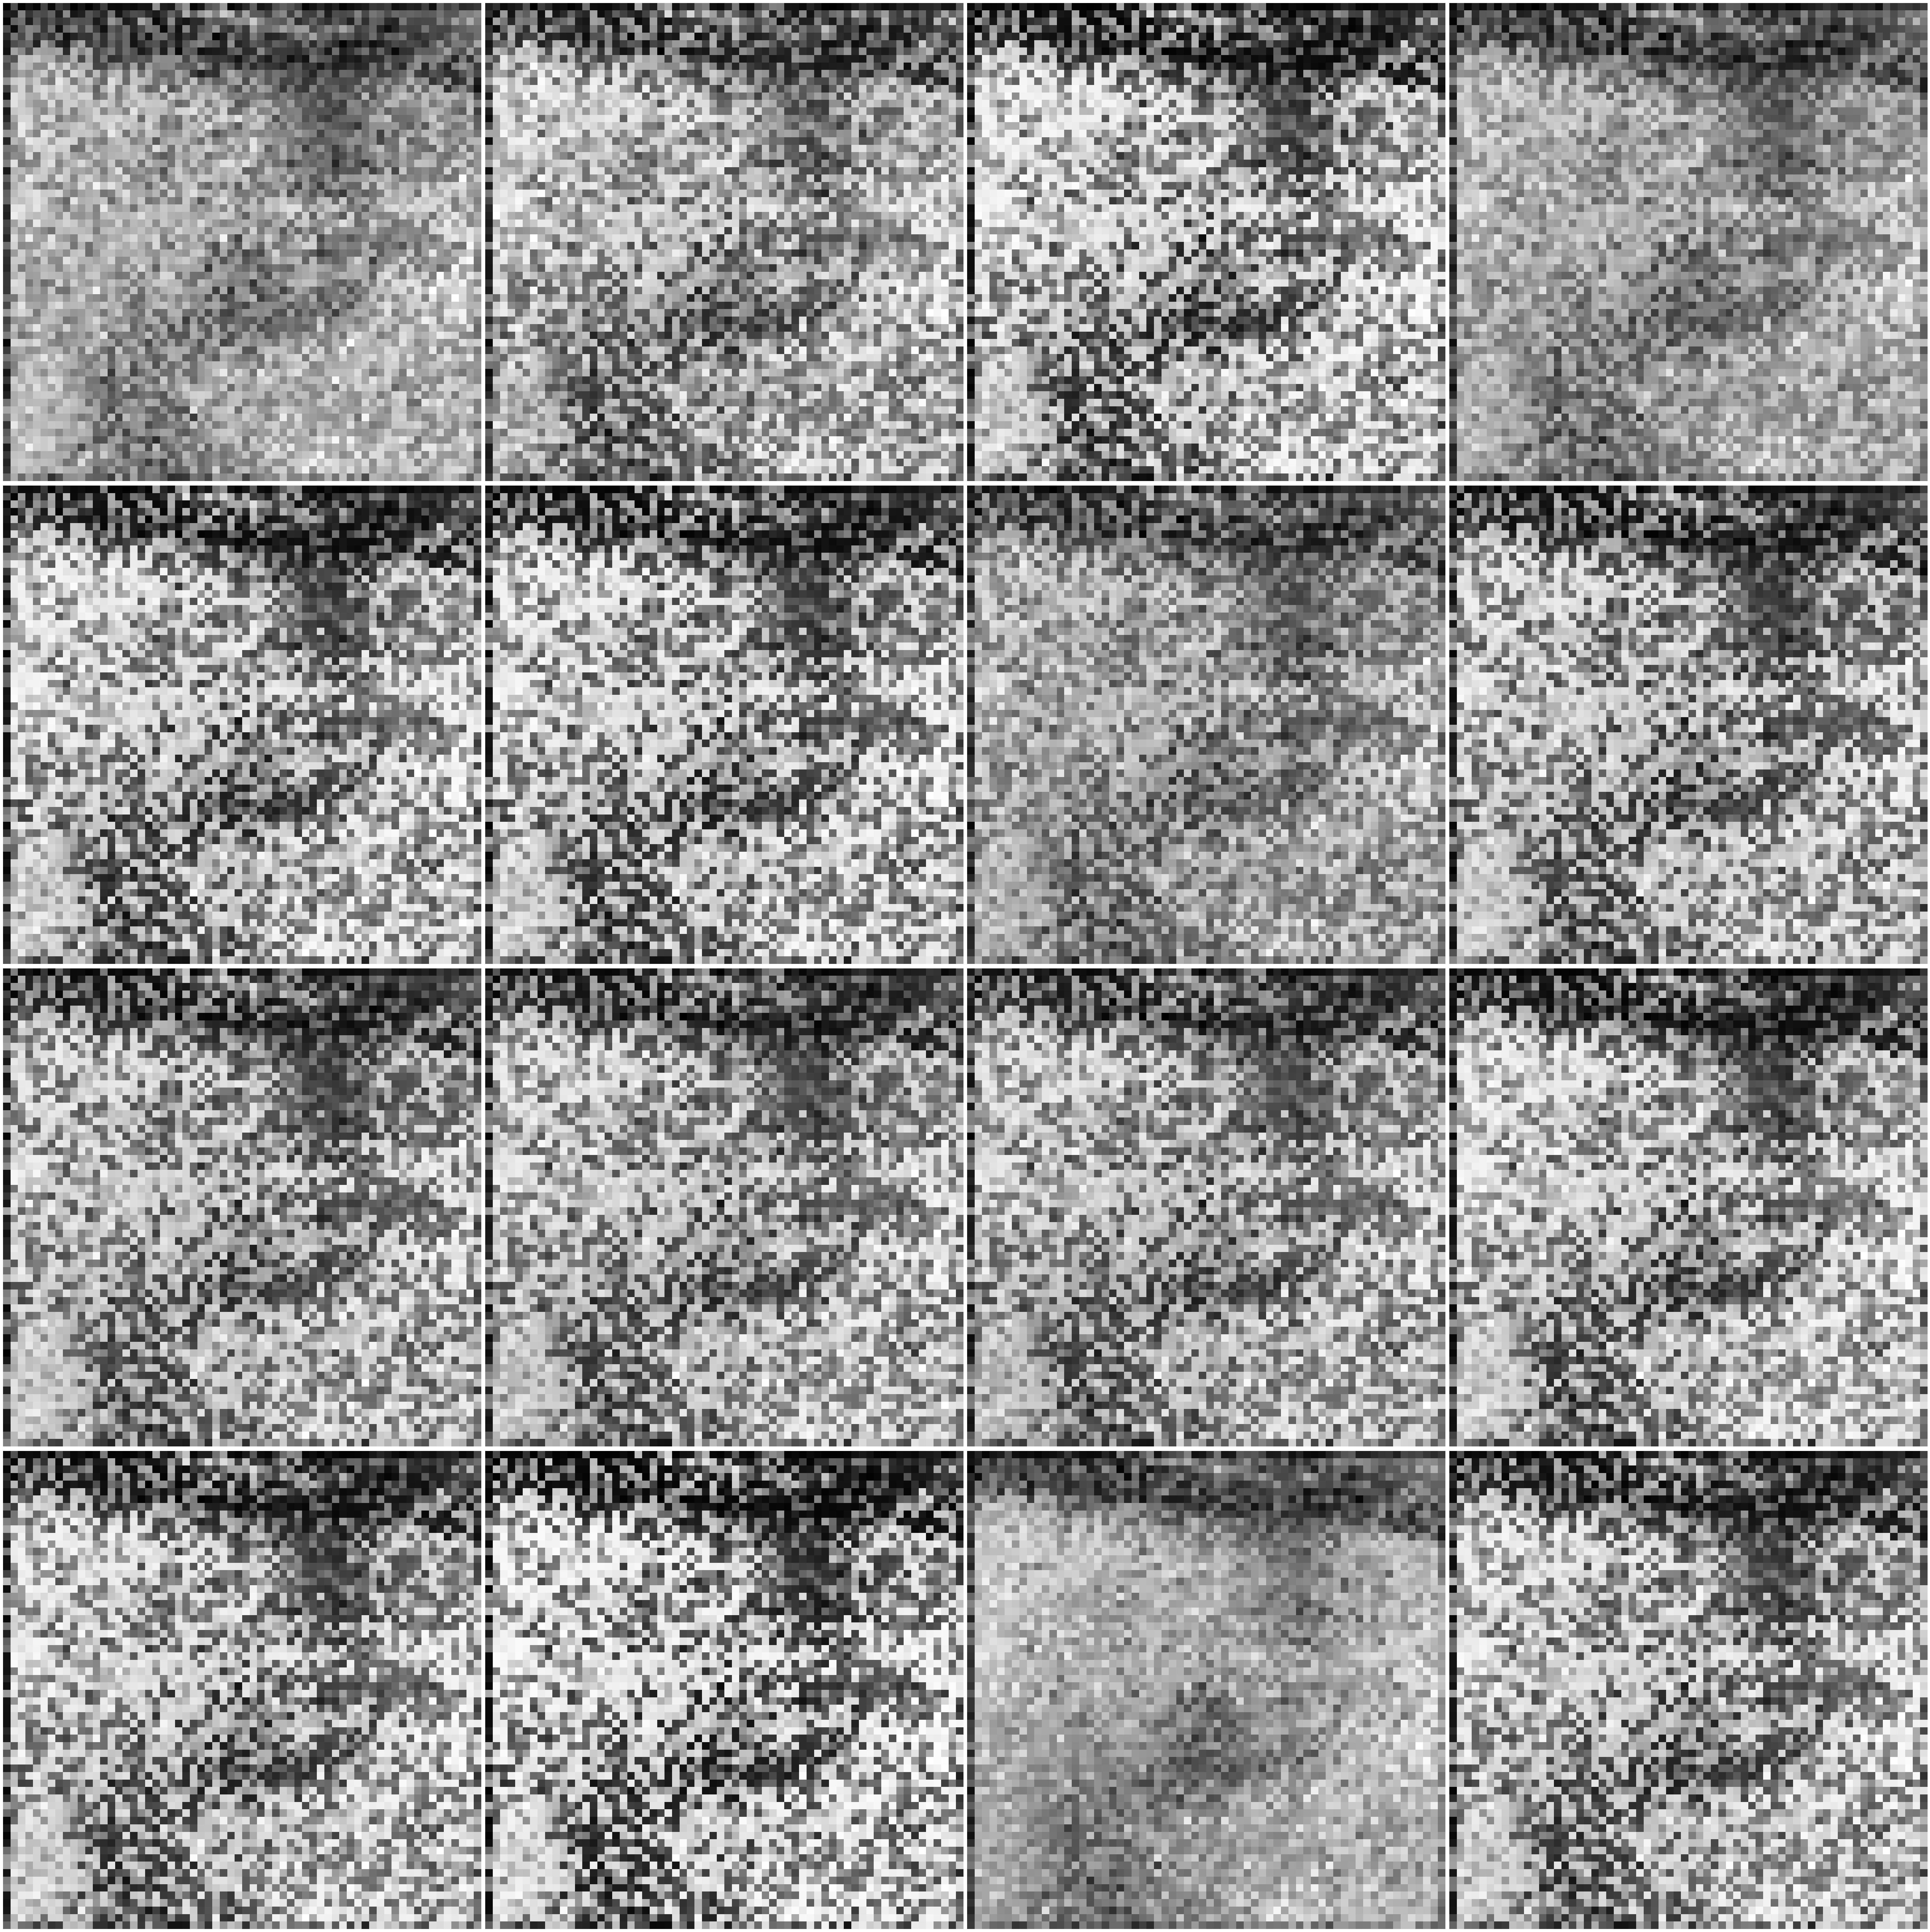

Currently trying combinations:
lr: 0.0005, batch_size: 32, epochs: 100, dropout: 0.5
Completed Epoch 1/100, Epoch Duration: 7.07s, Total Loss D.: 0.1381, Total Loss G.: 5.7742
Completed Epoch 2/100, Epoch Duration: 7.16s, Total Loss D.: 2.3063, Total Loss G.: 2.5565
Completed Epoch 3/100, Epoch Duration: 7.19s, Total Loss D.: 1.8379, Total Loss G.: 1.0603
Completed Epoch 4/100, Epoch Duration: 6.90s, Total Loss D.: 0.4694, Total Loss G.: 0.8436
Completed Epoch 5/100, Epoch Duration: 6.76s, Total Loss D.: 0.4665, Total Loss G.: 1.1655
Completed Epoch 6/100, Epoch Duration: 6.72s, Total Loss D.: 0.4203, Total Loss G.: 0.7294
Completed Epoch 7/100, Epoch Duration: 6.74s, Total Loss D.: 0.3314, Total Loss G.: 1.8808
Completed Epoch 8/100, Epoch Duration: 6.76s, Total Loss D.: 0.3140, Total Loss G.: 1.6027
Completed Epoch 9/100, Epoch Duration: 6.82s, Total Loss D.: 0.2928, Total Loss G.: 1.2924
Completed Epoch 10/100, Epoch Duration: 6.94s, Total Loss D.: 0.1409, Total Loss G.: 1.7789
Comp

Completed Epoch 90/100, Epoch Duration: 6.79s, Total Loss D.: 0.1593, Total Loss G.: 4.8954
Completed Epoch 91/100, Epoch Duration: 6.79s, Total Loss D.: 0.0039, Total Loss G.: 4.9531
Completed Epoch 92/100, Epoch Duration: 6.78s, Total Loss D.: 0.0024, Total Loss G.: 5.2698
Completed Epoch 93/100, Epoch Duration: 6.79s, Total Loss D.: 0.0023, Total Loss G.: 5.2128
Completed Epoch 94/100, Epoch Duration: 6.79s, Total Loss D.: 0.0015, Total Loss G.: 5.7011
Completed Epoch 95/100, Epoch Duration: 6.84s, Total Loss D.: 0.0015, Total Loss G.: 5.8919
Completed Epoch 96/100, Epoch Duration: 6.78s, Total Loss D.: 0.1076, Total Loss G.: 5.8638
Completed Epoch 97/100, Epoch Duration: 6.96s, Total Loss D.: 0.0016, Total Loss G.: 5.8038
Completed Epoch 98/100, Epoch Duration: 6.77s, Total Loss D.: 0.0019, Total Loss G.: 6.0433
Completed Epoch 99/100, Epoch Duration: 6.77s, Total Loss D.: 0.0251, Total Loss G.: 4.8122
Completed Epoch 100/100, Epoch Duration: 6.74s, Total Loss D.: 0.0070, Total Los

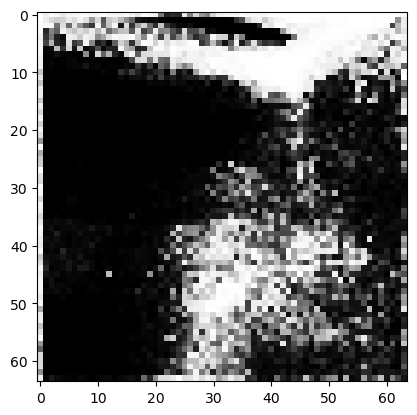

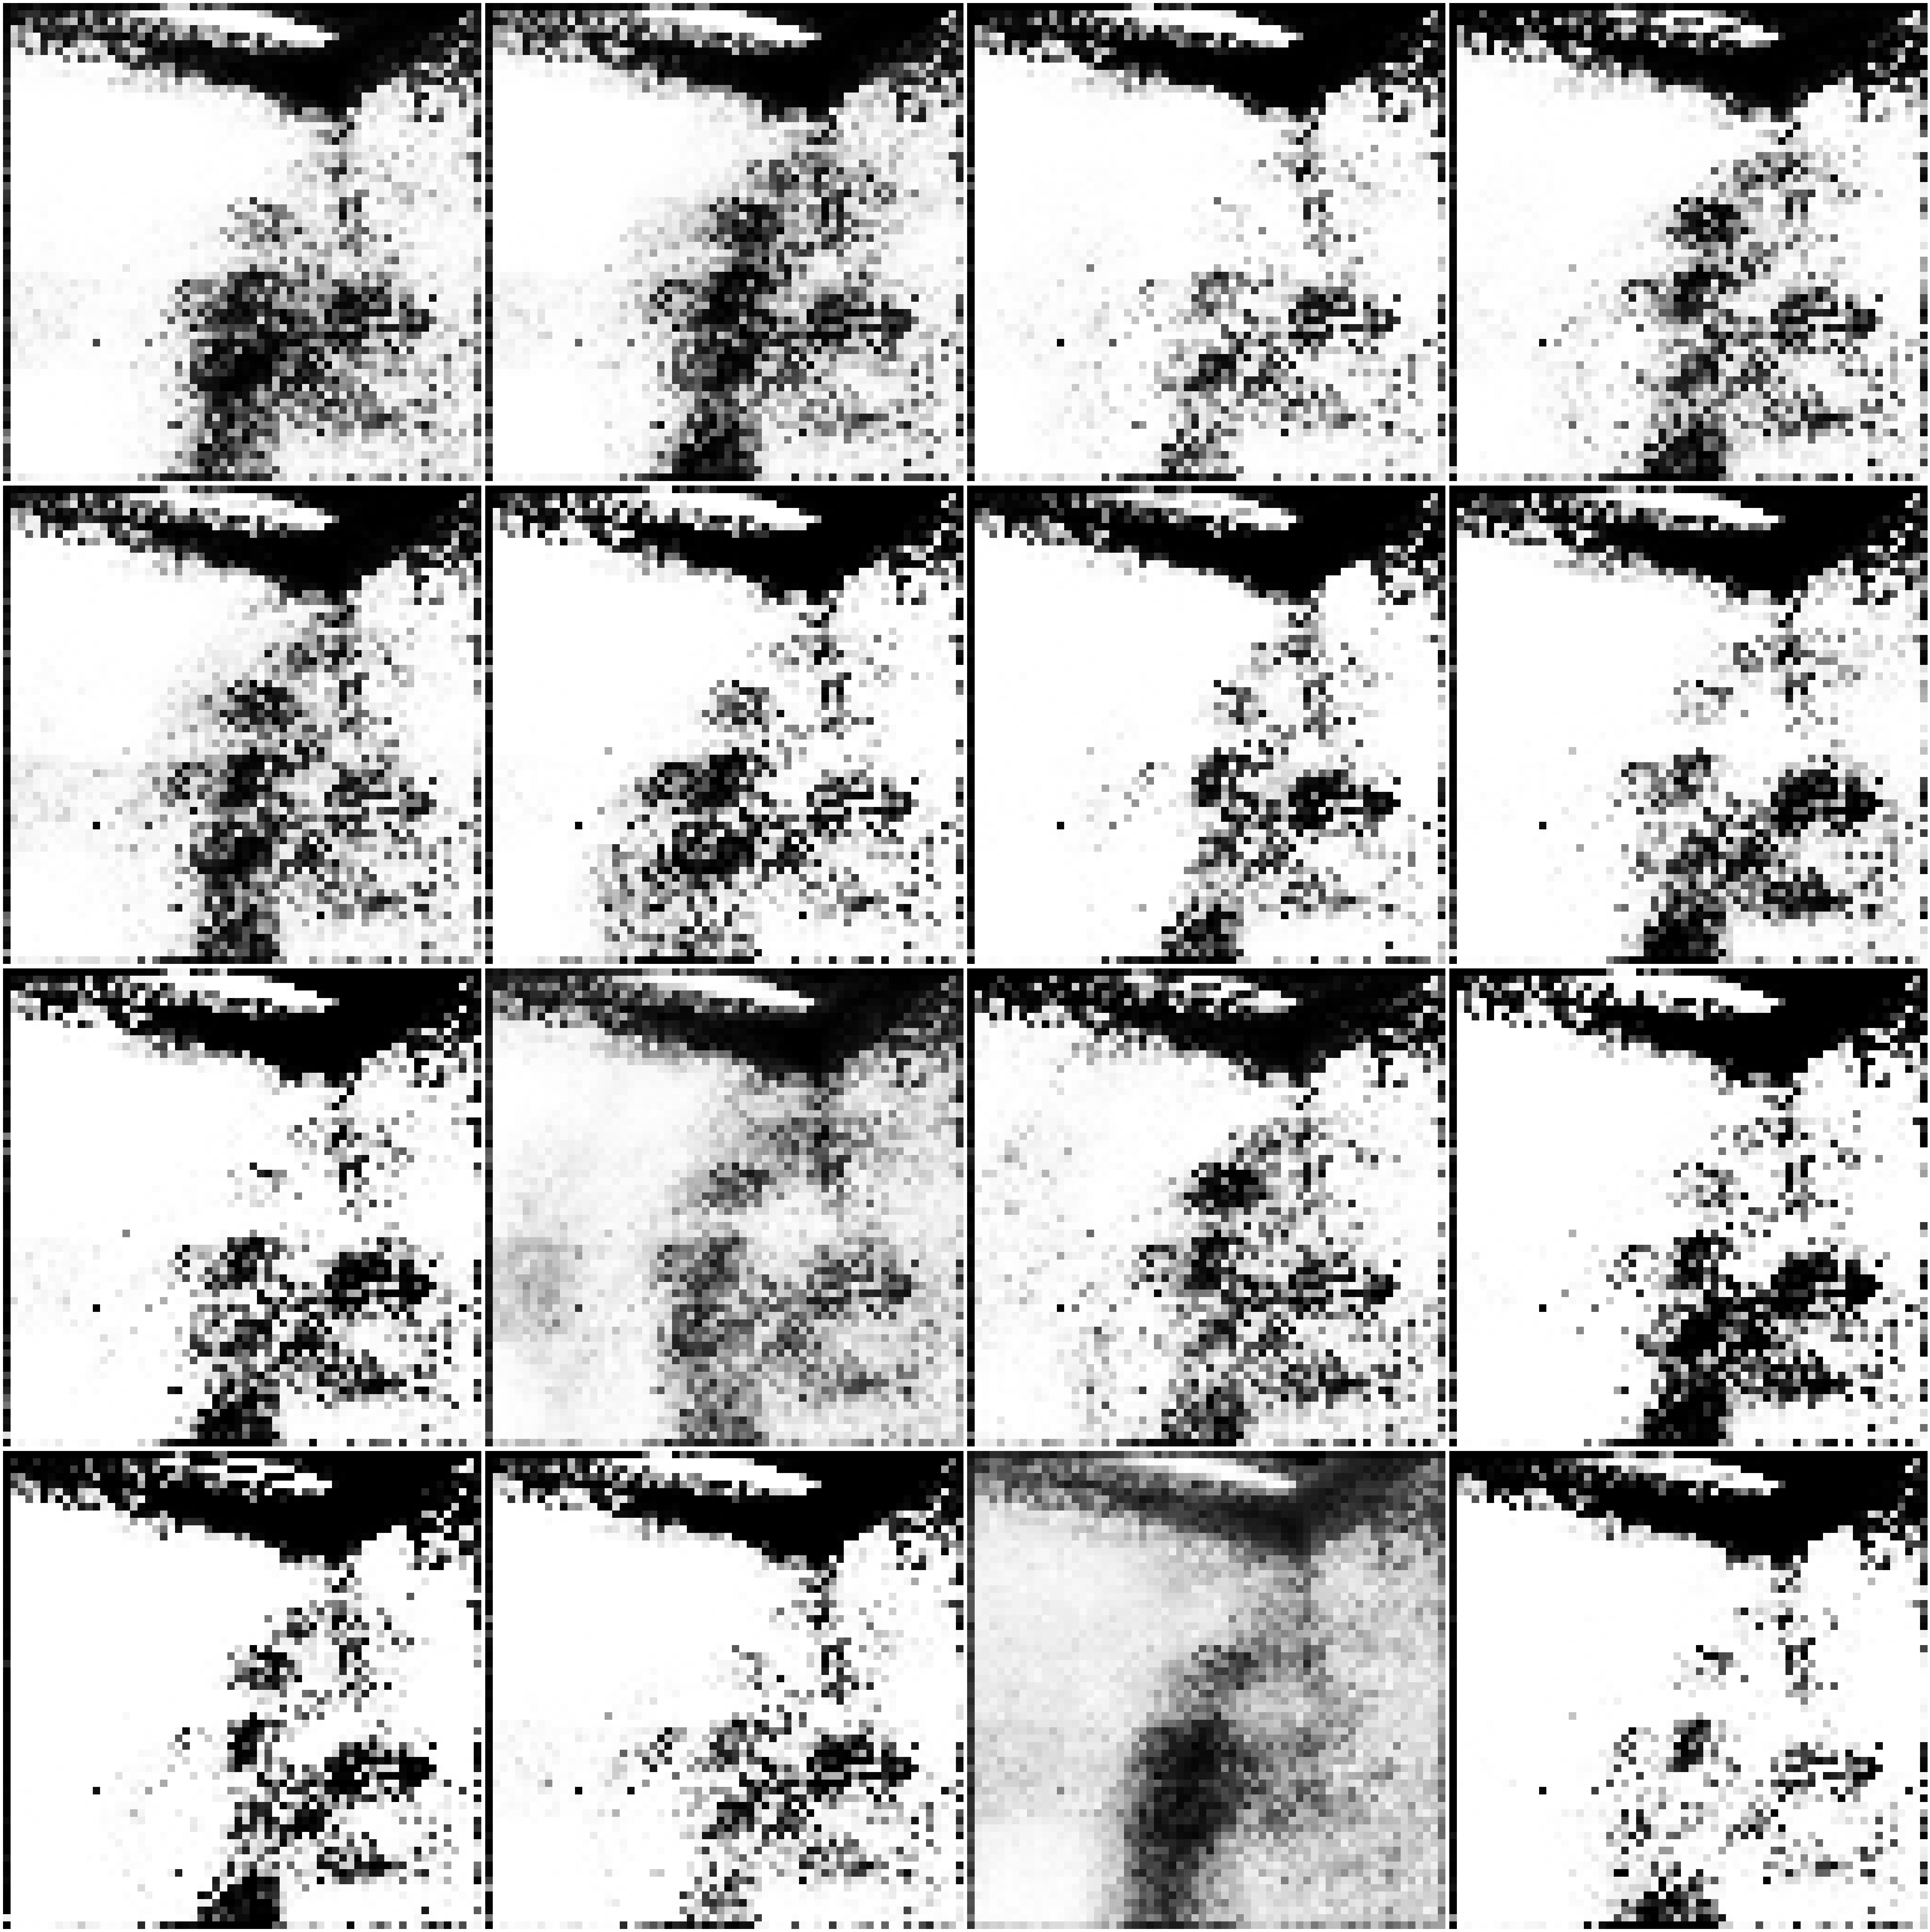

In [33]:
for lr, batch_size, epochs, dropout in parameter_combinations:
    run_training(lr, batch_size, epochs, dropout)